## PRODUCTION -  Severity prediction GLM using computational parameters (with statsmodels and bambi)

Date: 30.May.2023

### Purpose

Production-level predictions of clinical severity scores from computational parameter, model-less metrics, and demographics

commit

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from scipy import stats
import bambi as bmb
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler, normalize
from sklearn_pandas import DataFrameMapper

from patsy import PatsyError

from sys import path
import os
from IPython.display import clear_output, display
import warnings

root_dir = "/Users/kulkarnik/LocalProjects/SlotsTasks/"
model_functions_path = f'{root_dir}/bayesian_models/slotscraving/'

## Add model_functions to system path
path.append(model_functions_path)

from sepblock_decision.utils import load_data

In [2]:
import seaborn as sns
sns.set_style("white")
sns.set_context('poster')
sns.set_style({'font.family': 'Cambria Math'})
# sns.set(font='Cambria')
import matplotlib.pyplot as plt
import arviz as az
# plt.rcParams["font.family"] = "Cambria Math"

import warnings

## Load data

### Join round 1 and round 2 df_summary and longform data

In [3]:
df_summary = pd.read_csv(f'{root_dir}/online/factorial_v4/group_agg_factorial_v4/clean_df_longform.csv', index_col=0)
longform = pd.read_csv(f'{root_dir}/online/factorial_v4/group_agg_factorial_v4/clean_df_longform.csv', index_col=0)

### Load model comparison information df

In [4]:
model_comp_df = pd.DataFrame()
chosen_ic = 'waic'
#for group in ['alcohol', 'cannabis', 'binge']:
for group in ['binge']:
    for round_num in [1, 2]:
        model_comp_save_path = f'{root_dir}/online/factorial_v4/group_agg_factorial_v4/model_comparison/{chosen_ic}_{group}_model_comparison_df_round{round_num}.csv'
        project_dir = f'{root_dir}/online/factorial/{group}/'
        subset_longform = longform[(longform['Group']==group) & (longform['Round']==round_num)]
        subset_df_summary = df_summary[(df_summary['Group']==group) & (df_summary['Round']==round_num)]
        subset_pid_list = subset_longform['PID'].unique()

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            if os.path.exists(model_comp_save_path):
                print('Loading model comparison data...')
                subset_model_comp_df = pd.read_csv(model_comp_save_path, index_col=0).reset_index(drop=True)

            else:
                raise ValueError('Model comparison data not found. Please run model comparison script first.')
        
        subset_model_comp_df['Round'] = round_num
        subset_model_comp_df['Group'] = group
        model_comp_df = pd.concat([model_comp_df, subset_model_comp_df])

model_comp_df = model_comp_df.reset_index(drop=True)
# LOO scores are flipped from typical IC scores
model_comp_df[f'like_{chosen_ic}'] = -model_comp_df[f'like_{chosen_ic}']
model_comp_df[f'craving_like_{chosen_ic}'] = -model_comp_df[f'craving_like_{chosen_ic}']
model_comp_df['joint_like_waic'] = model_comp_df['like_waic'] + model_comp_df['craving_like_waic']

model_comp_df['PID'].unique().shape

Loading model comparison data...
Loading model comparison data...
Loading model comparison data...
Loading model comparison data...
Loading model comparison data...
Loading model comparison data...


(198,)

In [5]:
# subset_model_names = ['RWCEC', 'A_RWSep_2stepDecay', 'A_Beta_RWSep_2stepDecay', 'P_RWSep_2stepDecay']
# model_comp_df = model_comp_df[model_comp_df['Model'].isin(subset_model_names)].reset_index(drop=True)

### Load mean parameter estimates

In [6]:
param_df = pd.DataFrame()

for group in ['alcohol', 'cannabis', 'binge']:
    for round_num in [1, 2]:
        round_param_save_path = f'{root_dir}/online/factorial_v4/group_agg_factorial_v4/parameter_estimates/{group}_param_round{round_num}.csv'
        if os.path.exists(round_param_save_path):
            round_param_df = pd.read_csv(round_param_save_path, index_col=0)
        else:
            raise ValueError(f'Param data not found for {group.capitalize()} Group - Round {round_num}. Please run 3_sim_metrics script first.')
        round_param_df['Round'] = round_num
        round_param_df['Group'] = group
        param_df = pd.concat([param_df, round_param_df])
param_df.rename(columns={'Model Name':'Model', 'Model Type': 'Type', 'Decision Type': 'Decision', 'Craving Type': 'Craving'}, inplace=True)
# Obtain only magnitudes of parameter values
param_df['Param Value Magnitude'] = param_df['Param Value'].apply(lambda x: np.abs(x))
param_df = param_df.pivot(index=['Model', 'Decision', 'Craving', 'Block', "Pred Type", 'PID', 'Round', 'Group'], columns='Parameter', values='Param Value').reset_index()
param_df

Parameter         Model  Decision Craving  Block Pred Type  \
0               Heu_CEC       Heu     CEC  money   craving   
1               Heu_CEC       Heu     CEC  money   craving   
2               Heu_CEC       Heu     CEC  money   craving   
3               Heu_CEC       Heu     CEC  money   craving   
4               Heu_CEC       Heu     CEC  money   craving   
...                 ...       ...     ...    ...       ...   
4035       TempBias_JEC  TempBias     JEC  other   craving   
4036       TempBias_JEC  TempBias     JEC  other   craving   
4037       TempBias_JEC  TempBias     JEC  other   craving   
4038       TempBias_JEC  TempBias     JEC  other   craving   
4039       TempBias_JEC  TempBias     JEC  other   craving   

Parameter                       PID  Round     Group  alpha_neg  alpha_pos  \
0          546e3778fdf99b2bc7ebcff6      2     binge        NaN        NaN   
1          558955ebfdf99b6bd06016c9      1     binge        NaN        NaN   
2          55c4fc3dfdf99b559867a416      2  cannabis        NaN        NaN   
3          5608a73fd7def20012b7389d      1  cannabis        NaN        NaN   
4          562eb896733ea000051638c6      2     binge        NaN        NaN   
...                             ...    ...       ...        ...        ...   
4035       62e03f34dd2156c66495ec77      2     binge   0.350285   0.563493   
4036       62e1f3f870894e12168113c5      2     binge   0.781172   0.343397   
4037       62e2f0f23427f0ab91180313      2   alcohol   0.529910   0.690009   
4038       62e83262c4e50f1eb9eb2391      2     binge   0.940080   0.658471   
4039       62ee947379c835f0530d70fa      2  cannabis   0.418935   0.748911   

Parameter      beta  cec_weight       eps       mod  untr_alpha_neg  \
0               NaN         NaN  0.729612       NaN             NaN   
1               NaN         NaN  0.746271       NaN             NaN   
2               NaN         NaN  0.727768       NaN             NaN   
3               NaN         NaN  0.820294       NaN             NaN   
4               NaN         NaN  0.936555       NaN             NaN   
...             ...         ...       ...       ...             ...   
4035       0.668013   -0.704706       NaN  0.077862       -0.673790   
4036       0.222091    0.316568       NaN -0.032167        1.408060   
4037       0.317114   -0.113058       NaN -0.376424        0.137241   
4038       0.339111    2.972861       NaN -0.177768        2.869212   
4039       0.560725    0.342001       NaN  0.027096       -0.343332   

Parameter  untr_alpha_pos  untr_eps  weight_one  weight_two  weight_zero  
0                     NaN  1.010930   -0.580787         NaN     0.189777  
1                     NaN  1.098992   -0.623350         NaN    -0.115681  
2                     NaN  1.000841   -0.239908         NaN    -2.761904  
3                     NaN  1.554224   -0.125255         NaN    -1.890222  
4                     NaN  2.786522   -0.049633         NaN     0.380955  
...                   ...       ...         ...         ...          ...  
4035             0.314112       NaN   -1.853247    0.735419    -3.154001  
4036            -0.723751       NaN    0.400678   -0.000046     1.155927  
4037             0.892312       NaN    0.675780    0.017875    -0.126270  
4038             0.701912       NaN    1.366089    1.843387     3.509413  
4039             1.206089       NaN   -0.817736   -0.234133    -0.742072  

[4040 rows x 20 columns]

In [7]:
merged_df_unfiltered = pd.merge(
    model_comp_df, 
    param_df, 
    on=list(set(model_comp_df.columns).intersection(set(param_df.columns))), how='left'
)
merged_df_unfiltered

Model                       PID  PID Num  Decision Craving  \
0       NoBias_CEC  6111c95332b4f21de44a25c7        0    NoBias     CEC   
1       NoBias_EEC  6111c95332b4f21de44a25c7        0    NoBias     EEC   
2       NoBias_JEC  6111c95332b4f21de44a25c7        0    NoBias     JEC   
3       LRBias_CEC  6111c95332b4f21de44a25c7        0    LRBias     CEC   
4       LRBias_EEC  6111c95332b4f21de44a25c7        0    LRBias     EEC   
...            ...                       ...      ...       ...     ...   
4035    LRBias_JEC  5f70ff16b9894a71cb8f5d91       35    LRBias     JEC   
4036  TempBias_CEC  5f70ff16b9894a71cb8f5d91       35  TempBias     CEC   
4037  TempBias_EEC  5f70ff16b9894a71cb8f5d91       35  TempBias     EEC   
4038  TempBias_JEC  5f70ff16b9894a71cb8f5d91       35  TempBias     JEC   
4039       Heu_CEC  5f70ff16b9894a71cb8f5d91       35       Heu     CEC   

      Block  like_waic  like_d_waic  craving_like_waic  craving_like_d_waic  \
0     money  22.786181     0.164457          33.410021             0.236998   
1     money  22.699553     0.077829          33.173023             0.000000   
2     money  22.743301     0.121577          33.629285             0.456262   
3     money  22.741402     0.119678          33.397539             0.224516   
4     money  22.809256     0.187532          33.369093             0.196070   
...     ...        ...          ...                ...                  ...   
4035  other  40.407283     1.651704         112.971191            26.992193   
4036  other  42.873980     4.118401         188.438781           102.459783   
4037  other  39.981294     1.225714          95.770576             9.791578   
4038  other  40.314666     1.559087          88.061889             2.082891   
4039  other  38.755579     0.000000         187.057722           101.078724   

      ...      beta cec_weight       eps       mod  untr_alpha_neg  \
0     ...  0.247982  -0.249463       NaN       NaN        0.945857   
1     ...  0.256180        NaN       NaN       NaN        0.974975   
2     ...  0.239633  -0.136409       NaN       NaN        0.984977   
3     ...  0.259381  -0.264901       NaN  0.103465        0.932325   
4     ...  0.253415        NaN       NaN  0.084025        0.910539   
...   ...       ...        ...       ...       ...             ...   
4035  ...  1.356936  -0.562249       NaN -0.659700       -1.271496   
4036  ...  1.975640   0.244537       NaN -0.335474       -0.200272   
4037  ...  2.274330        NaN       NaN  0.053761       -3.743420   
4038  ...  1.074487  -0.896377       NaN -0.004960       -3.388147   
4039  ...       NaN        NaN  0.648844       NaN             NaN   

      untr_alpha_pos  untr_eps  weight_one  weight_two  weight_zero  
0           0.192843       NaN         NaN         NaN    -2.745024  
1           0.260655       NaN   -0.277266   -0.103320    -2.803560  
2           0.056141       NaN   -0.252345   -0.001597    -2.784211  
3           0.259430       NaN         NaN         NaN    -2.743789  
4           0.217309       NaN   -0.341401   -0.076969    -2.767829  
...              ...       ...         ...         ...          ...  
4035       -0.414909       NaN   -1.528674    0.438981    -0.117361  
4036       -0.545817       NaN         NaN         NaN    -1.419445  
4037       -3.338722       NaN   -2.240760   -0.186842     0.191511  
4038       -3.036269       NaN   -1.971432    0.714521    -0.108203  
4039             NaN  0.624677    0.244566         NaN    -1.413781  

[4040 rows x 26 columns]

### Load round 1 and round 2 redcap data

In [8]:
### Posttask loading
path_to_posttask_redcap = f'./post_task_all_drugs.csv'
posttask_df = pd.read_csv(path_to_posttask_redcap)

### Posttask Round 2 loading
round2_path_to_posttask_redcap = f'./round2_post_task_all_drugs.csv'
round2_posttask_df = pd.read_csv(round2_path_to_posttask_redcap)

post_task_df = pd.concat([posttask_df, round2_posttask_df]).reset_index(drop=True)

In [9]:
### Pretask loading for round 1 and 2
path_to_pretask_redcap = f'./surveys/screening_surveys_r1r2.csv'
pretask_df = pd.read_csv(path_to_pretask_redcap).filter(regex='assist3|edeq|socialmediause|prolific_pid$')

### Group-specific joined_df

In [10]:
joined_dfs = {
    'alcohol': None,
    'cannabis': None,
    'binge': None,
}

#### Alcohol

In [11]:
tmp_df = posttask_df[
    (posttask_df['study_id']=='flask-drug-craving')
].copy()

tmp_df = pd.merge(tmp_df, pretask_df, on='prolific_pid', how='left')

tmp_df['ASSIST_Alcohol'] = tmp_df.filter(regex='assist3_q.*b').sum(axis=1, numeric_only=True, skipna=True)
tmp_df['AUDIT_Alcohol'] = tmp_df['audit_score']
tmp_df['ADS_Alcohol'] = tmp_df.filter(regex='ads').sum(axis=1, numeric_only=True, skipna=True)

tmp_df = tmp_df[['prolific_pid', 'ASSIST_Alcohol', 'AUDIT_Alcohol', 'ADS_Alcohol', 'age', 'sex', 'edu_level']]
joined_dfs['alcohol'] = pd.merge(
    tmp_df,
    df_summary[
        (df_summary['Group']=='alcohol')
    ],
    left_on='prolific_pid',
    right_on='PID',
    how='inner'
).drop_duplicates(subset='prolific_pid').drop(columns=['prolific_pid'])

<AxesSubplot: ylabel='Density'>

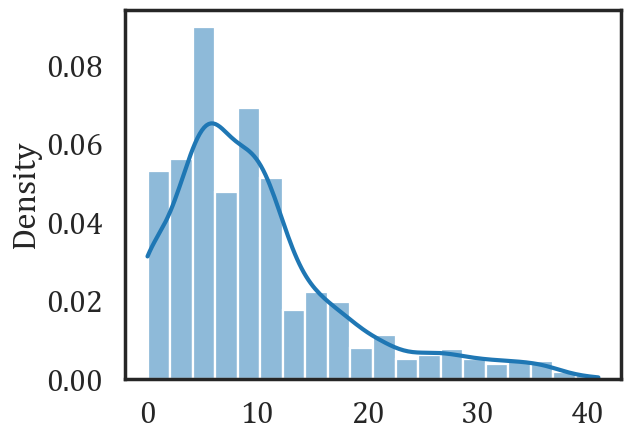

In [12]:
sns.histplot(pretask_df.filter(regex='assist3_q.*b').sum(axis=1, numeric_only=True, skipna=True).values, kde=True, stat='density', bins=20)

In [13]:
pd.DataFrame(pretask_df.filter(regex='assist3_q.*b').sum(axis=1, numeric_only=True, skipna=True).describe())

0
count  2043.000000
mean      9.880568
std       8.039352
min       0.000000
25%       5.000000
50%       8.000000
75%      12.000000
max      41.000000

#### Cannabis

In [14]:
tmp_df = posttask_df[
    (posttask_df['study_id']=='flask-cannabis-craving')
].copy()

tmp_df = pd.merge(tmp_df, pretask_df, on='prolific_pid', how='left')

tmp_df['ASSIST_Cannabis'] = tmp_df.filter(regex='assist3_q[0-9]*c_sc').sum(axis=1, numeric_only=True, skipna=True)
tmp_df['CAST_Cannabis'] = tmp_df.filter(regex='cast').sum(axis=1, numeric_only=True, skipna=True) - 6
tmp_df['SDS_Cannabis'] = tmp_df.filter(regex='sds').sum(axis=1, numeric_only=True, skipna=True) - 5

tmp_df = tmp_df[['prolific_pid', 'ASSIST_Cannabis', 'CAST_Cannabis', 'SDS_Cannabis', 'age', 'sex', 'edu_level']]
joined_dfs['cannabis'] = pd.merge(
    tmp_df,
    df_summary[
        (df_summary['Group']=='cannabis')
    ],
    left_on='prolific_pid',
    right_on='PID',
    how='inner'
).drop_duplicates(subset='prolific_pid').drop(columns=['prolific_pid'])

In [15]:
# Total # of cannabis users with weekly or greater use
num_weeklyplus_cannabis = (pretask_df['assist3_q2c_sc'].replace(np.nan, 0)>=4).sum()
print(f'Total # of cannabis users with weekly or greater use: {num_weeklyplus_cannabis}')
print(f'Percent of cannabis users with weekly or greater use: {num_weeklyplus_cannabis/len(pretask_df)}')

Total # of cannabis users with weekly or greater use: 332
Percent of cannabis users with weekly or greater use: 0.16250611845325502


<AxesSubplot: ylabel='Density'>

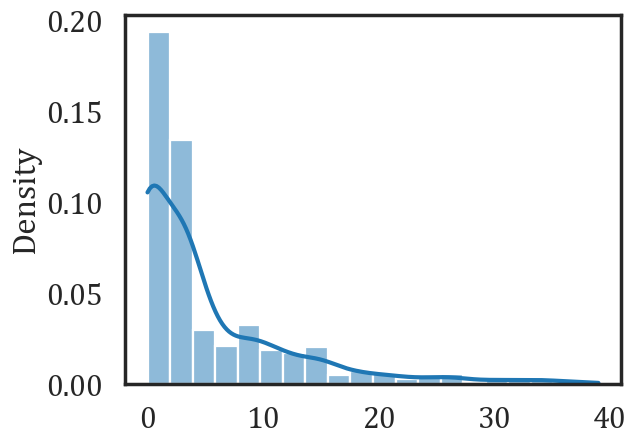

In [16]:
sns.histplot(pretask_df.filter(regex='assist3_q[0-9]*c_sc').sum(axis=1, numeric_only=True, skipna=True).values, kde=True, stat='density', bins=20)

In [17]:
pd.DataFrame(pretask_df.filter(regex='assist3_q[0-9]*c_sc').sum(axis=1, numeric_only=True, skipna=True).describe())

0
count  2043.000000
mean      5.362212
std       7.336196
min       0.000000
25%       0.000000
50%       3.000000
75%       8.000000
max      39.000000

#### Binge eating

In [18]:
tmp_df = posttask_df[
    (posttask_df['study_id']=='flask-food-craving')
].copy()

tmp_df = pd.merge(tmp_df, pretask_df, on='prolific_pid', how='left')

tmp_df['LOCES_Total'] = tmp_df['locesb_total']
tmp_df['EDEQ_Bingefrq'] = tmp_df['edeq_14'] # want to replace this column name with edeq_14
tmp_df['EDEQ_EatingConcern'] = tmp_df['edeq_eating']#replace xxx with the column name for eating concern
tmp_df['ELOCS_Item6'] = tmp_df['locesb_6']
tmp_df['EDEQ_Item7'] = tmp_df['edeq_7_eating']



tmp_df = tmp_df[['prolific_pid', 'LOCES_Total', 'EDEQ_Bingefrq', 'age', 'sex', 'edu_level', 'EDEQ_EatingConcern', 'ELOCS_Item6','EDEQ_Item7']] #add the new variables here
joined_dfs['binge'] = pd.merge(
    tmp_df,
    df_summary[
        (df_summary['Group']=='binge')
    ],
    left_on='prolific_pid',
    right_on='PID',
    how='inner'
).drop_duplicates(subset='prolific_pid').drop(columns=['prolific_pid'])

<AxesSubplot: ylabel='Density'>

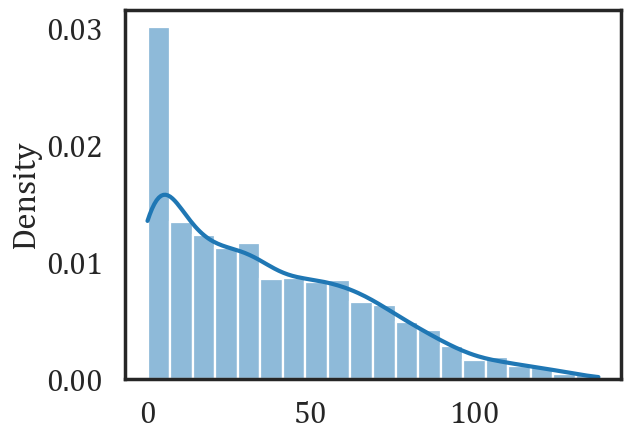

In [19]:
sns.histplot(pretask_df.filter(regex='edeq_global').sum(axis=1, numeric_only=True, skipna=True).values, kde=True, stat='density', bins=20)

In [20]:
pd.DataFrame(pretask_df.filter(regex='edeq_global').sum(axis=1, numeric_only=True, skipna=True).describe())

0
count  2043.000000
mean     36.854626
std      31.055082
min       0.000000
25%      10.000000
50%      31.000000
75%      58.000000
max     138.000000

In [21]:
pd.DataFrame(pretask_df.filter(regex='edeq_14').replace(np.nan, 0)['edeq_14'].value_counts()).sort_index()

edeq_14
0.0      1410
1.0       147
2.0       147
3.0        75
4.0        46
5.0        66
6.0        11
7.0        14
8.0        20
9.0         1
10.0       39
12.0        7
13.0        2
14.0        7
15.0       23
16.0        2
18.0        1
19.0        1
20.0       13
21.0        1
23.0        1
25.0        4
28.0        2
30.0        1
35.0        1
50.0        1

In [22]:
### Calculate mean and std of cravings and mood
for group, joined_df in joined_dfs.items():
    mean_craving_ratings = []
    std_craving_ratings = []
    mean_mood_ratings = [] 
    std_mood_ratings = []
    for pid in joined_df['PID'].unique():
        if pid in longform['PID'].unique():
            raw_cravings = longform[
                (longform['PID']==pid) &
                (longform['Group']==group) &
                (longform['Type']=='other') &
                (longform['Craving Rating']!=-1) 
            ]['Craving Rating'].values
            mean_craving_ratings.append(np.mean(raw_cravings))
            std_craving_ratings.append(np.std(raw_cravings))

            raw_mood_ratings = longform[
                (longform['PID']==pid) &
                (longform['Group']==group) &
                (longform['Type']=='other') &
                (longform['Mood Rating']!=-1)
            ]['Mood Rating'].values
            mean_mood_ratings.append(np.mean(raw_mood_ratings))
            std_mood_ratings.append(np.std(raw_mood_ratings))
        else:
            print(f'PID {pid} not found in longform data')

    joined_df['mean_craving_ratings'] = mean_craving_ratings
    joined_df['std_craving_ratings'] = std_craving_ratings
    joined_df['mean_mood_ratings'] = mean_mood_ratings
    joined_df['std_mood_ratings'] = std_mood_ratings

### Calculate demographic variables of interest

In [23]:
for group, joined_df in joined_dfs.items():
    joined_df['DEMO_age'] = joined_df['age']

In [24]:
def sex_filter(arr):
    if arr.sex==1:
        return 'Male'
    elif arr.sex==2:
        return 'Female'
    elif arr.sex==3:
        return 'Other'
for group, joined_df in joined_dfs.items():
    joined_df['DEMO_sex'] = joined_df.filter(regex='^sex').apply(sex_filter, axis=1)

In [25]:
def edu_filter(arr):
    if arr.edu_level==1:
        return '< High School'
    elif arr.edu_level==2:
        return 'Some HS'
    elif arr.edu_level==3:
        return 'High School'
    elif arr.edu_level==4:
        return 'Some college'
    elif arr.edu_level==5:
        return 'College'
    elif arr.edu_level==6:
        return 'Graduate'
for group, joined_df in joined_dfs.items():
    joined_df['DEMO_edu'] = joined_df.filter(regex='^edu_level').apply(edu_filter, axis=1)

## Plot distributions of dependent vars

In [26]:
alc_descriptor_df = pd.DataFrame()
for var in ['ASSIST_Alcohol', 'AUDIT_Alcohol', 'ADS_Alcohol']:
    alc_descriptor_df = pd.concat([alc_descriptor_df, pd.DataFrame(joined_dfs['alcohol'][var].describe())], axis=1)
display(alc_descriptor_df)

ASSIST_Alcohol  AUDIT_Alcohol  ADS_Alcohol
count       62.000000      62.000000    62.000000
mean        17.064516       6.758065     7.935484
std          8.389828       6.570389    11.267058
min          5.000000       1.000000     0.000000
25%         10.000000       3.000000     1.000000
50%         16.500000       4.000000     4.000000
75%         22.000000       8.750000    10.000000
max         36.000000      33.000000    50.000000

<AxesSubplot: xlabel='ASSIST_Alcohol', ylabel='Density'>

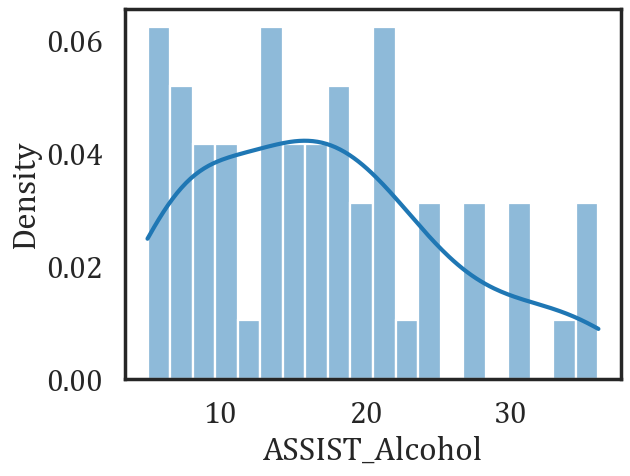

In [27]:
sns.histplot(joined_dfs['alcohol']['ASSIST_Alcohol'], kde=True, stat='density', bins=20)

### Calculate ASSIST, CAST, SDS scores for cannabis users

In [28]:
cannabis_descriptor_df = pd.DataFrame()
for var in ['CAST_Cannabis', 'SDS_Cannabis', 'ASSIST_Cannabis']:
    cannabis_descriptor_df = pd.concat([cannabis_descriptor_df, pd.DataFrame(joined_dfs['cannabis'][var].describe())], axis=1)
cannabis_descriptor_df

CAST_Cannabis  SDS_Cannabis  ASSIST_Cannabis
count      61.000000     61.000000        61.000000
mean        7.737705      3.065574        13.983607
std         3.586557      1.869660         7.898295
min         2.000000      2.000000         5.000000
25%         5.000000      2.000000         8.000000
50%         7.000000      2.000000        12.000000
75%         9.000000      3.000000        15.000000
max        20.000000     10.000000        34.000000

<AxesSubplot: xlabel='CAST_Cannabis', ylabel='Density'>

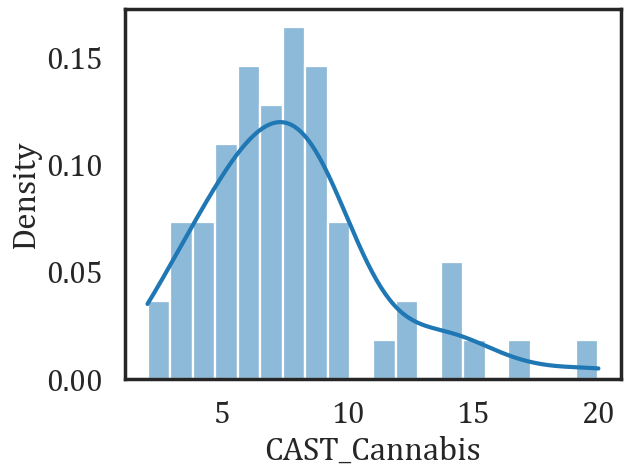

In [29]:
sns.histplot(joined_dfs['cannabis']['CAST_Cannabis'], kde=True, stat='density', bins=20)

### Calculate edeq_*, locesb_total for binge eaters
- edeq_global, edeq_restraint, edeq_eating, edeq_weight, edeq_shape
- Done automatically

In [30]:
binge_descriptor_df = pd.DataFrame()
for var in ['EDEQ_Binge', 'LOCES_Binge']:
    binge_descriptor_df = pd.concat([binge_descriptor_df, pd.DataFrame(joined_dfs['binge'][var].describe())], axis=1)
binge_descriptor_df

EDEQ_Binge  LOCES_Binge
count   67.000000    68.000000
mean    72.611940    18.691176
std     28.442901     6.055113
min      1.000000     8.000000
25%     55.500000    13.750000
50%     73.000000    19.000000
75%     94.000000    23.000000
max    128.000000    32.000000

<AxesSubplot: xlabel='EDEQ_Binge', ylabel='Density'>

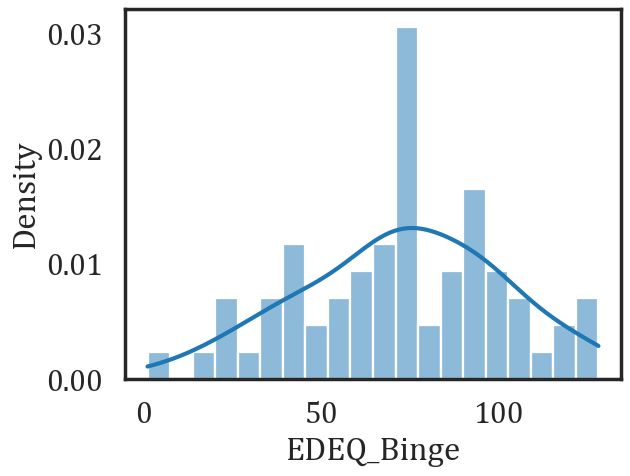

In [31]:
sns.histplot(joined_dfs['binge']['EDEQ_Binge'], kde=True, stat='density', bins=20)

## Merge parameter and redcap data

In [32]:
master_dfs = {
    #'alcohol': None,
   # 'cannabis': None,
    'binge': None,
   # 'social': None
}
for group in joined_dfs.keys():
    print(f'{group}: {joined_dfs[group].shape[0]}')
    master_dfs[group] = pd.merge(
        #merged_df_unfiltered[merged_df_unfiltered['Group']==group],
        joined_dfs[group],
        on=list(set(merged_df_unfiltered.columns).intersection(set(joined_dfs[group].columns))),
        how='right'
        # on=['PID', 'Group', 'Round'], how='right'
    )
    # master_dfs[group] = merged_df.merge(joined_dfs[group], left_on=['PID', 'Group'], right_on=['prolific_pid', 'Group'])
    print(f'{group}: {master_dfs[group]["PID"].unique().shape[0]}')

alcohol: 62
alcohol: 62
cannabis: 61
cannabis: 61
binge: 68
binge: 68


## Demographics

In [33]:
print(joined_dfs['alcohol'].AUDIT_Alcohol.describe())
# print(joined_dfs['alcohol'].DEMO_age.value_counts())

count    62.000000
mean      6.758065
std       6.570389
min       1.000000
25%       3.000000
50%       4.000000
75%       8.750000
max      33.000000
Name: AUDIT_Alcohol, dtype: float64


## Correlations between severity and mod/weights

### Alcohol

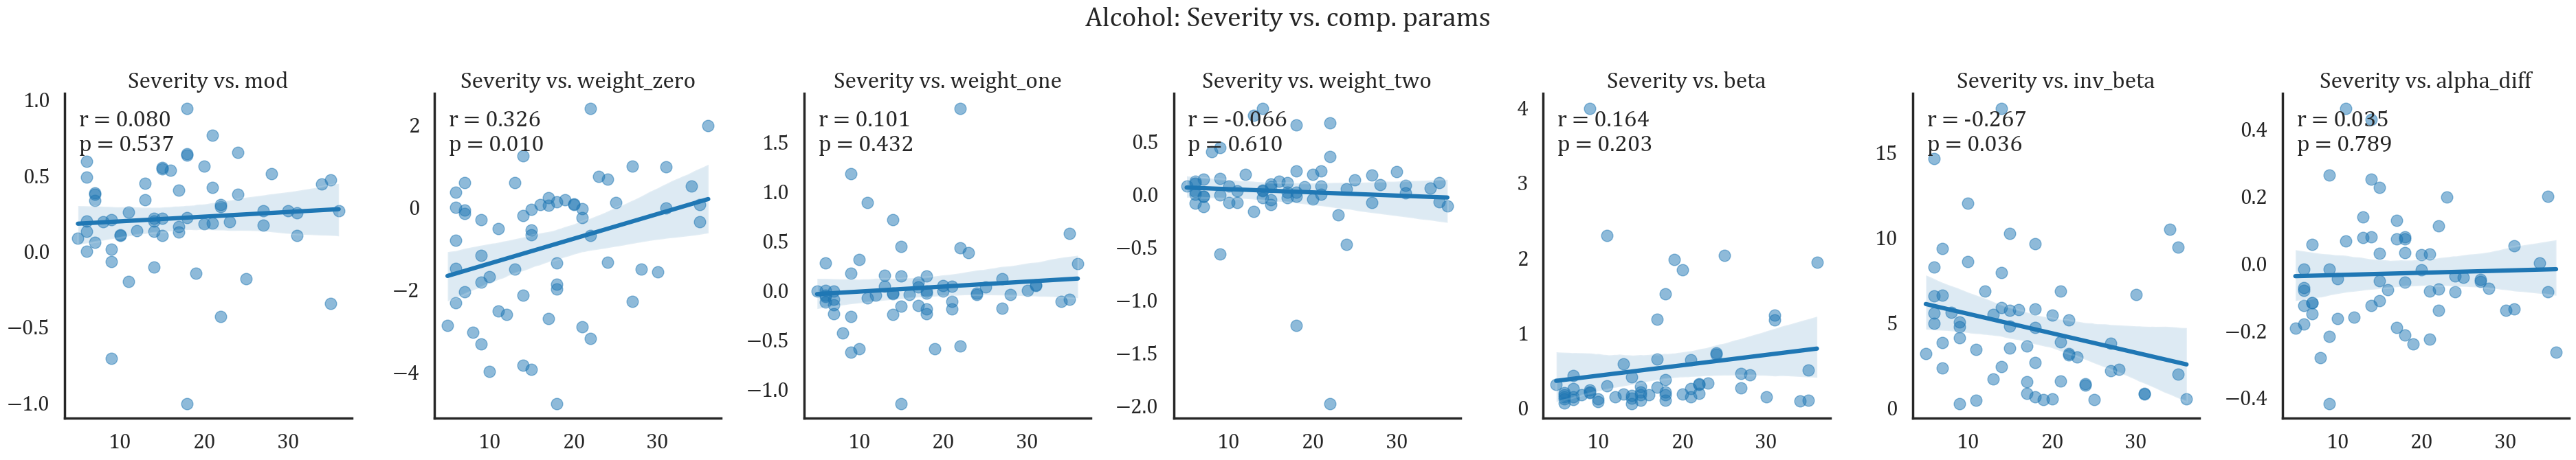

In [43]:
group_df = master_dfs['alcohol']
block_df = group_df[
    (group_df['Model']=='LRBias_JEC') &
    (group_df['Block']=='other')
].copy()
block_df['inv_beta'] = 1 / block_df['beta']
block_df['alpha_diff'] = block_df['alpha_pos'] - block_df['alpha_neg']

x_var = 'ASSIST_Alcohol'
y_vars = ['mod', 'weight_zero', 'weight_one', 'weight_two', 'beta', 'inv_beta', 'alpha_diff']
fig, ax = plt.subplots(1, len(y_vars), figsize=(38, 7))
for i, y_var in enumerate(y_vars):
    sns.regplot(
        data=block_df,
        x=x_var, y=y_var,
        ax=ax[i],
        scatter_kws={'alpha': 0.5}
    )
    # Annotate with correlation coefficient and p-value
    corr, p = stats.pearsonr(block_df[x_var], block_df[y_var])
    ax[i].annotate(f'r = {corr:.3f}\np = {p:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')
    ax[i].set_title(f'Severity vs. {y_var}')
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')

fig.suptitle(f'Alcohol: Severity vs. comp. params')
sns.despine()
plt.tight_layout()
plt.show()

### Cannabis

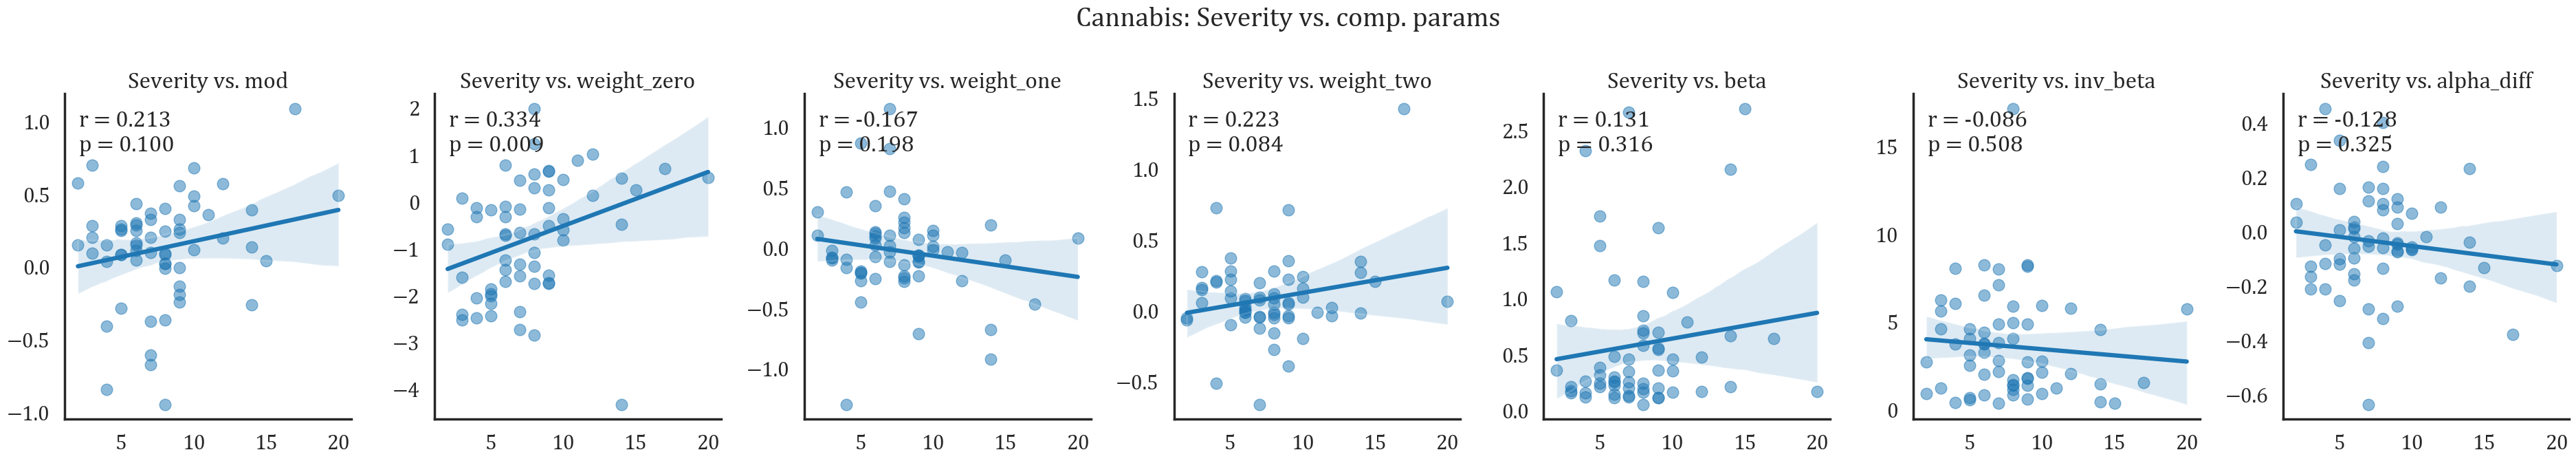

In [45]:
group_df = master_dfs['cannabis']
block_df = group_df[
    (group_df['Model']=='LRBias_JEC') &
    (group_df['Block']=='other')
].copy()
block_df['inv_beta'] = 1 / block_df['beta']
block_df['alpha_diff'] = block_df['alpha_pos'] - block_df['alpha_neg']

x_var = 'CAST_Cannabis'
y_vars = ['mod', 'weight_zero', 'weight_one', 'weight_two', 'beta', 'inv_beta', 'alpha_diff']
fig, ax = plt.subplots(1, len(y_vars), figsize=(38, 7))
for i, y_var in enumerate(y_vars):
    sns.regplot(
        data=block_df,
        x=x_var, y=y_var,
        ax=ax[i],
        scatter_kws={'alpha': 0.5}
    )
    # Annotate with correlation coefficient and p-value
    corr, p = stats.pearsonr(block_df[x_var], block_df[y_var])
    ax[i].annotate(f'r = {corr:.3f}\np = {p:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')
    ax[i].set_title(f'Severity vs. {y_var}')
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')

fig.suptitle(f'Cannabis: Severity vs. comp. params')
sns.despine()
plt.tight_layout()
plt.show()

### Binge

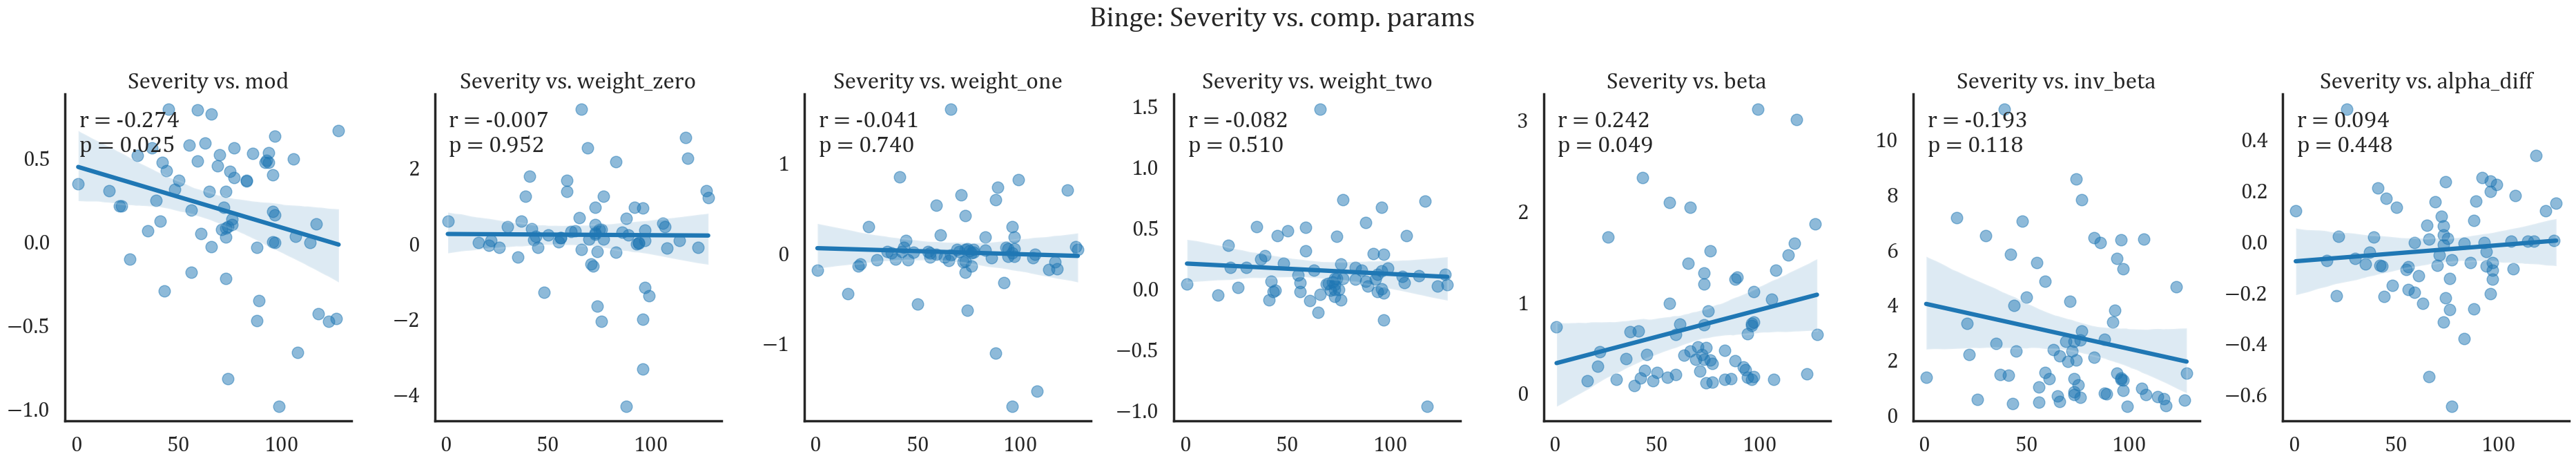

In [47]:
group_df = master_dfs['binge']
block_df = group_df[
    (group_df['Model']=='LRBias_JEC') &
    (group_df['Block']=='other')
].dropna(subset=['EDEQ_Binge']).copy()
block_df['inv_beta'] = 1 / block_df['beta']
block_df['alpha_diff'] = block_df['alpha_pos'] - block_df['alpha_neg']

x_var = 'EDEQ_Binge'
y_vars = ['mod', 'weight_zero', 'weight_one', 'weight_two', 'beta', 'inv_beta', 'alpha_diff']
fig, ax = plt.subplots(1, len(y_vars), figsize=(38, 7))
for i, y_var in enumerate(y_vars):
    sns.regplot(
        data=block_df,
        x=x_var, y=y_var,
        ax=ax[i],
        scatter_kws={'alpha': 0.5}
    )
    # Annotate with correlation coefficient and p-value
    corr, p = stats.pearsonr(block_df[x_var], block_df[y_var])
    ax[i].annotate(f'r = {corr:.3f}\np = {p:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')
    ax[i].set_title(f'Severity vs. {y_var}')
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')

fig.suptitle(f'Binge: Severity vs. comp. params')
sns.despine()
plt.tight_layout()
plt.show()

## Regression models (both runs)
Analysis is limited to addictive cue block only

### Functions

In [45]:
## Regression functions

def get_normed_model(mdf, reg_params, model_name, block):
    _model_df = mdf.loc[
        (mdf['Group']==reg_params['group']) &
        (mdf['Model']==model_name) & 
        (mdf['Block']==block)
    ].dropna(how='all', axis=1).dropna(how='any', axis=0, subset=reg_params['dependent_var']).reset_index(drop=True)

    # Normalize the data
    model_param_names = []
    for param in (reg_params['full_param_list']+reg_params['full_demo_list']+reg_params['full_nonmodel_param_list']):
        if param in _model_df.columns:
            model_param_names.append(param)
    _columns_to_use = [reg_params['dependent_var']] + model_param_names
    _numerics = _model_df[_columns_to_use].select_dtypes(include=[np.number])
    _nonnumerics = _model_df[_columns_to_use].select_dtypes(exclude=[np.number])
    scaler = StandardScaler()
    _normed_model_df = pd.concat([
        pd.DataFrame(
            scaler.fit_transform(_numerics), 
            columns=_numerics.columns
        ),
        _nonnumerics
    ], axis=1)

    # Add dummy variables for categorical demographics
    normed_model_df = pd.get_dummies(_normed_model_df, columns=['DEMO_sex', 'DEMO_edu'])
    normed_model_df.columns = normed_model_df.columns.str.replace(' ', '_')
    return normed_model_df

def build_equation(nmdf, reg_params, typ):
    # Build the model equation
    equation = reg_params['dependent_var'] + ' ~ '
    model_param_names = []
    if typ in ['comp', 'combined']:
        for param in reg_params['full_param_list']:
            if param in nmdf.columns:
                equation += param + ' + '
                model_param_names.append(param)
        for demo in reg_params['full_demo_list']:
            for col in nmdf.columns:
                if demo in col:
                    equation += col + ' + '
                    model_param_names.append(col)
    if typ in ['nonmodel', 'combined']:
        for param in reg_params['full_nonmodel_param_list']:
            if param in nmdf.columns:
                equation += param + ' + '
                model_param_names.append(param)
    equation = equation[:-3]
    # print(f'Number {i}:\t{model_name}\t{equation}')
    return equation

def fit_unfiltered(equation, nmdf, model_name, sm_model_dict, bmb_model_dict, reg_params):
    # Fit the model with statsmodels
    sm_results = smf.ols(formula=equation, data=nmdf).fit()
    # display(sm_results.summary())
    sm_model_dict[model_name] = sm_results

    if reg_params['bambi_flag']:
        # Fit the model with bambi
        bmb_model = bmb.Model(equation, nmdf, family=reg_params['family'])
        bmb_results = bmb_model.fit()
        ppc = bmb_model.predict(bmb_results, kind='pps')
        bmb_model_dict[model_name] = bmb_results
    
    return sm_model_dict, bmb_model_dict

def build_filtered_equation(equation, nmdf, reg_params):
    # Filtering of the model (remove predictors with significance < 0.05)
    filtered_equation = equation
    least_sig = 1
    success = True
    while least_sig > reg_params['sig_threshold']:
        try:
            _sm_results = smf.ols(formula=filtered_equation, data=nmdf).fit()
        except:
            success = False
            break
        x = pd.read_html(_sm_results.summary().tables[1].as_html())[0]
        y = x.iloc[0].astype(str)
        y[0] = 'Predictor'
        x.columns = y
        x = x.iloc[1:]
        x = pd.concat([
            x['Predictor'],
            x[[elem for elem in x.columns if 'Predictor' not in elem]].astype(str).astype(float)
        ], axis=1)
        x = x[x['Predictor']!='Intercept']
        least_sig = x.sort_values(by='P>|t|', ascending=False)['P>|t|'].values[0]
        predictors = [elem for elem in x.sort_values(by='P>|t|', ascending=False)['Predictor'].values.astype(str) if 'Intercept' not in elem]
        if least_sig > reg_params['sig_threshold']:
            filtered_equation = reg_params['dependent_var'] + ' ~ ' + ' + '.join(predictors[1:])
        else:
            filtered_equation = reg_params['dependent_var'] + ' ~ ' + ' + '.join(predictors)
    # print(f'Number {i}:\t{model_name}\t{filtered_equation}')
    return filtered_equation, success

def fit_filtered(filtered_equation, nmdf, model_name, sm_model_dict, bmb_model_dict, reg_params):
    # Fit the filtered model with statsmodels
    filtered_sm_results = smf.ols(formula=filtered_equation, data=nmdf).fit()
    # display(filtered_sm_results.summary())
    sm_model_dict[f'{model_name}_filtered'] = filtered_sm_results

    if reg_params['bambi_flag']:
        # Fit the filtered model with bambi
        filtered_bmb_model = bmb.Model(filtered_equation, nmdf, family=reg_params['family'])
        filtered_bmb_results = filtered_bmb_model.fit()
        filtered_ppc = filtered_bmb_model.predict(filtered_bmb_results, kind='pps')
        bmb_model_dict[f'{model_name}_filtered'] = filtered_bmb_results
    
    return sm_model_dict, bmb_model_dict

def run_group_regression(
    mdf,
    group,
    model_names,
    dependent_var,
    typ,
    block,
    sm_model_dict=None,
    bmb_model_dict=None,
    full_demo_list=['DEMO_age', 'DEMO_sex', 'DEMO_edu'],
    full_param_list = [
        'alpha', 'alpha_pos', 'alpha_neg',
        'beta',
        'weight_zero', 'weight_one', 'weight_two',
        'weight_three', 'weight_four', 'weight_five',
        'weight_six', 'cec_weight', 'mod',
        'bias', 'eps',
    ],
    full_nonmodel_param_list = ['mean_craving_ratings', 'std_craving_ratings', 'mean_mood_ratings', 'std_mood_ratings'],
    family = 'gaussian',
    bambi_flag = True,
    sig_threshold = 0.05,
):
    if typ not in ['comp', 'nonmodel', 'combined']:
        raise ValueError('typ must be one of "comp", "nonmodel", or "combined"')
    reg_params = {
        'group': group,
        'dependent_var': dependent_var,
        'full_demo_list': full_demo_list,
        'full_param_list': full_param_list,
        'full_nonmodel_param_list': full_nonmodel_param_list,
        'family': family,
        'bambi_flag': bambi_flag,
        'sig_threshold': sig_threshold,
    }
    if sm_model_dict is None:
        print('sm_model_dict is None')
        sm_model_dict = {}
    if bmb_model_dict is None:
        bmb_model_dict = {}

    for model_name in model_names:
        nmdf = get_normed_model(mdf, reg_params, model_name, block)
        # print(f'Number of participants: {len(nmdf)}')

        # Rename model_name
        if typ=='nonmodel':
            model_name = f'model_agnostic'
        elif typ=='combined':
            model_name = f'combined_{model_name}'

        print(f'Running regression for {group} {model_name} {dependent_var}...')
        equation = build_equation(nmdf, reg_params, typ)
        # print(f'{model_name}\t{equation}')
        sm_model_dict, bmb_model_dict = fit_unfiltered(equation, nmdf, model_name, sm_model_dict, bmb_model_dict, reg_params)
        filtered_equation, success = build_filtered_equation(equation, nmdf, reg_params)
        if success:
            # print('Successful filtering')
            # print(f'{model_name}\t{filtered_equation}')
            sm_model_dict, bmb_model_dict = fit_filtered(filtered_equation, nmdf, model_name, sm_model_dict, bmb_model_dict, reg_params)
    return sm_model_dict, bmb_model_dict, reg_params


###

In [46]:
## Plotting functions
def performance_comp(sm_model_dict, bmb_model_dict, bambi_flag=False):
    performance_df = pd.DataFrame(columns=['Model', 'R2', 'R2_adj', 'AIC', 'BIC'])
    for model in sm_model_dict:
        sm_results = sm_model_dict[model]
        performance_df = pd.concat([
            performance_df,
            pd.DataFrame({
                'Model': [model],
                'R2': [sm_results.rsquared],
                'R2_adj': [sm_results.rsquared_adj],
                'AIC': [sm_results.aic],
                'BIC': [sm_results.bic]
            })
        ], axis=0)
    performance_df = performance_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    display(performance_df)
    
    if bambi_flag:
        fig, ax = plt.subplots(1, 1, figsize=(5, 4))
        name_dict = {
            'agnostic': 'Agnostic-R',
            'comp': 'Comp-R',
            'combined': 'Joint-R'
        }
        filtered_bmb_dict = {k: v for k, v in bmb_model_dict.items() if 'filtered' in k}
        model_agnostic_present = False
        for k, v in filtered_bmb_dict.items():
            if 'agnostic' in k:
                model_agnostic_present = True
        if not model_agnostic_present:
            filtered_bmb_dict['model_agnostic_filtered'] = bmb_model_dict['model_agnostic']
        filtered_bmb_dict_renamed = {}
        for k, v in filtered_bmb_dict.items():
            if 'agnostic' in k:
                filtered_bmb_dict_renamed[f'{name_dict["agnostic"]}'] = v
            elif 'combined' in k:
                filtered_bmb_dict_renamed[f'{name_dict["combined"]}'] = v
            else:
                filtered_bmb_dict_renamed[f'{name_dict["comp"]}'] = v
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            df_compare = az.compare(filtered_bmb_dict_renamed, ic='waic')
            display(df_compare)
            az.plot_compare(df_compare, insample_dev=True, plot_ic_diff=True, ax=ax, legend=False);
            ax.set_title(f'')
            ax.set_ylabel('')
    return performance_df

def plot_r2_adj(performance_df):
    fig, ax = plt.subplots(figsize=(5, 3))
    sns.barplot(x='Model', y='R2_adj', data=performance_df, dodge=False, ax=ax, palette='Set2', edgecolor='black', linewidth=2)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12);

def plot_sig_predictive(sm_model_dict, bmb_model_dict, reg_params):
    cand_param_list = reg_params['full_param_list'] + reg_params['full_nonmodel_param_list'] + reg_params['full_demo_list']
    fig, ax = plt.subplots(figsize=(17, 5), ncols=3, nrows=1)
    i_count = -1
    for i, model_name in enumerate(bmb_model_dict.keys()):
        if 'filtered' not in model_name:
            continue
        if i>8:
            break
        else:
            i_count += 1
            if 'model_agnostic' in model_name:
                ax[i_count].set_title('model_agnostic')
            elif 'combined' in model_name:
                ax[i_count].set_title('Combined')
            else:
                ax[i_count].set_title('Model parameters')
        vars = []
        summary_model_df = az.summary(bmb_model_dict[model_name])
        candidate_vars = np.array([
            elem for elem in az.summary(bmb_model_dict[model_name]).index if elem in cand_param_list
        ])
        for var in candidate_vars:
            if np.abs(summary_model_df.loc[var]['hdi_3%'] + summary_model_df.loc[var]['hdi_97%']) > np.abs(summary_model_df.loc[var]['hdi_97%']):
                vars.append(var)
        az.plot_forest(
            bmb_model_dict[model_name], 
            var_names=vars,
            figsize=(5,4), combined=True, 
            kind='ridgeplot', ridgeplot_alpha=0.3, 
            hdi_prob=0.89,
            # ridgeplot_quantiles=[.25, .5, .75],
            ridgeplot_overlap=1, 
            ridgeplot_truncate=False,
            colors='gray',
            ax=ax[i_count],
        )
        # plt.xlim(-15, 15)
        # ax[i_count].set_title(model_name)
        ax[i_count].axvline(0, color='k', linestyle='--')
        ax[i_count].set_yticklabels(ax[i_count].get_yticklabels(), rotation=45, ha='right')
    plt.tight_layout()

def plot_posterior_predictive(bmb_model_dict, performance_df, reg_params, group_name):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
    for i, prefix in enumerate(['model_agnostic', 'LRBias', 'combined']):
        if prefix=='model_agnostic':
            c = 'grey'
        elif prefix=='LRBias':
            c = sns.color_palette('Set2')[0]
        else:
            c = sns.color_palette('Set2')[1]
        best_representative_model = performance_df[performance_df['Model'].str.startswith(prefix)].iloc[0]['Model']
        best_model_results = bmb_model_dict[best_representative_model]

        # az.plot_hdi(
        #     best_model_results.observed_data[reg_params["dependent_var"]].values,
        #     best_model_results.posterior_predictive[reg_params["dependent_var"]].values,
        #     hdi_prob=0.84, smooth=True, color=c, ax=ax,
        #     fill_kwargs={'alpha': 0.03}
        # )
        # az.plot_hdi(
        #     best_model_results.observed_data[reg_params["dependent_var"]].values,
        #     best_model_results.posterior_predictive[reg_params["dependent_var"]].values,
        #     hdi_prob=0.68, smooth=True, color=c, ax=ax,
        #     fill_kwargs={'alpha': 0.1}
        # )
        sns.regplot(
            x=best_model_results.observed_data[reg_params["dependent_var"]].values,
            y=np.vstack(best_model_results.posterior_predictive[reg_params["dependent_var"]].values).mean(axis=0),
            color=c, ci=95, ax=ax, scatter_kws=dict(s=20, alpha=0.4), line_kws=dict(lw=2, alpha=1), marker='D'
        )
    
    sns.despine()
    ax.set_xlabel(f'True Score')
    ax.set_ylabel(f'Predicted Score')
    ax.text(0.05, 0.95, f'{group_name.capitalize()}', transform=ax.transAxes, va='top', ha='left', fontsize=18)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

def plot_sig_improvement(bmb_model_dict, reg_params, perf_df):
    best_model_name = perf_df.iloc[0]['Model']
    best_model_results = bmb_model_dict[best_model_name]
    try:
        predicted = np.hstack((
            np.vstack(best_model_results.posterior_predictive[reg_params["dependent_var"]].values).mean(axis=0),
            np.vstack(bmb_model_dict['model_agnostic_filtered'].posterior_predictive[reg_params["dependent_var"]].values).mean(axis=0)
        ))
    except KeyError:
        predicted = np.hstack((
            np.vstack(best_model_results.posterior_predictive[reg_params["dependent_var"]].values).mean(axis=0),
            np.vstack(bmb_model_dict['model_agnostic'].posterior_predictive[reg_params["dependent_var"]].values).mean(axis=0)
        ))
    true = np.hstack((
        best_model_results.observed_data[reg_params["dependent_var"]].values,
        best_model_results.observed_data[reg_params["dependent_var"]].values
    ))
    model_labels = np.hstack((
        # np.repeat(r2_df.loc[0]['Model'], len(sample_model_df)),
        np.repeat(1, len(best_model_results.observed_data[reg_params["dependent_var"]].values)),
        # np.repeat('model-free', len(sample_model_df))
        np.repeat(0, len(best_model_results.observed_data[reg_params["dependent_var"]].values))
    ))
    predict_df = pd.DataFrame({
        'predicted': predicted,
        'true': true,
        'model': model_labels
    })

    equation = 'predicted ~ true * model'
    print(equation)
    pred_model = bmb.Model(equation, predict_df)
    results = pred_model.fit()

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
    az.plot_forest(
        results, 
        filter_vars='regex',
        var_names=['^true'],
        figsize=(5,2), combined=True, 
        kind='ridgeplot', ridgeplot_alpha=0.3, 
        hdi_prob=0.89,
        # ridgeplot_quantiles=[.25, .5, .75],
        ridgeplot_overlap=1, 
        ridgeplot_truncate=False,
        colors='gray',
        ax=ax,
    )
    ax.axvline(0, color='k', linestyle='--')
    plt.tight_layout()
    display(smf.ols(equation, predict_df).fit().summary())

def plot_sig_improvement2(bmb_model_dict, reg_params, perf_df):
    best_model_name = perf_df.iloc[0]['Model']
    best_model_results = bmb_model_dict[best_model_name]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4), sharey=True)
    try:
        sns.regplot(
            x=best_model_results.observed_data[reg_params["dependent_var"]].values,
            y=np.vstack(bmb_model_dict['model_agnostic_filtered'].posterior_predictive[reg_params["dependent_var"]].values).mean(axis=0),
            color='gray', ci=89, ax=ax, scatter_kws=dict(s=50, alpha=0.3), line_kws=dict(lw=2, alpha=0.3)
        )
    except KeyError:
        sns.regplot(
            x=best_model_results.observed_data[reg_params["dependent_var"]].values,
            y=np.vstack(bmb_model_dict['model_agnostic'].posterior_predictive[reg_params["dependent_var"]].values).mean(axis=0),
            color='gray', ci=89, ax=ax, scatter_kws=dict(s=50, alpha=0.3), line_kws=dict(lw=2, alpha=0.3)
        )
    sns.regplot(
        x=best_model_results.observed_data[reg_params["dependent_var"]].values,
        y=np.vstack(best_model_results.posterior_predictive[reg_params["dependent_var"]].values).mean(axis=0),
        color=sns.palettes.color_palette('Set2')[1], ci=89, ax=ax, scatter_kws=dict(s=50)
    )
    sns.despine()
    # ax.set_xlabel(f'True {reg_params["dependent_var"].capitalize()}')
    # ax.set_ylabel(f'Predicted {reg_params["dependent_var"].capitalize()}')
    # ax.set_xlabel(f'True score')
    # ax.set_ylabel(f'Predicted score')
    # ax.text(0.05, 1.01, f'Best model', transform=ax.transAxes, va='top', ha='left', bbox=dict(edgecolor=sns.palettes.color_palette('Set2')[1], facecolor='white'))
    # ax.text(0.05, 0.84, 'Model-free', transform=ax.transAxes, va='top', ha='left', bbox=dict(edgecolor='gray', facecolor='white'))
    plt.tight_layout()

# Function to generate the dataframe of parameter estimates and confidence intervals from statsmodels model
def generate_param_estimates_df(sm_results, model_name):
    x = pd.read_html(sm_results.summary().tables[1].as_html())[0]
    y = x.iloc[0].astype(str)
    y[0] = 'Predictor'
    x.columns = y
    x = x.iloc[1:]
    x = pd.concat([
        x['Predictor'],
        x[[elem for elem in x.columns if 'Predictor' not in elem]].astype(str).astype(float)
    ], axis=1)
    x = x[x['Predictor']!='Intercept']
    x = x.sort_values(by='P>|t|', ascending=False)
    x['Model'] = model_name
    x = x[['Model', 'Predictor', 'coef', 'std err', 't', 'P>|t|', '[0.025', '0.975]']]
    x.columns = ['Model', 'Predictor', 'coef', 'std err', 't', 'P>|t|', 'lower', 'upper']
    x['mean'] = x['coef']
    x['ci'] = (x['upper'] - x['lower']) / 2
    x['pval'] = x['P>|t|']
    x = x[['Model', 'Predictor', 'mean', 'ci', 'pval']]
    return x.sort_values(by='pval', ascending=True).reset_index(drop=True)

# Function to plot from mean and confidence interval from a dataframe of multiple parameters
def plot_from_df(glm_param_df, ax, group):
    sns.scatterplot(
        x=glm_param_df['mean'],
        y=glm_param_df.index,
        ax=ax, color='grey'
    )
    ax.errorbar(
        x=glm_param_df['mean'],
        y=glm_param_df.index,
        xerr=glm_param_df['ci'],
        elinewidth=3, capsize=3, capthick=3, fmt='none',
        ecolor='grey'
    )
    sig_df = glm_param_df[glm_param_df['pval']<0.05]
    # display(sig_df)
    sns.scatterplot(
        x=sig_df['mean'],
        y=sig_df.index,
        ax=ax, color='red'
    )
    ax.errorbar(
        x=sig_df['mean'],
        y=sig_df.index,
        xerr=sig_df['ci'],
        elinewidth=3, capsize=3, capthick=3, fmt='none',
        ecolor='red'
    )
    ax.set_xlabel('Parameter value')
    ax.set_ylabel('Parameter name')
    ax.set_title(f'Parameter values for {group} group', pad=20)
    ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    # Add y-axis labels with parameter names
    ax.set_yticklabels(glm_param_df['Predictor'], rotation=45)
    ax.set_yticks(glm_param_df.index)
    sns.despine()

### Alcohol modular

In [47]:
master_dfs['alcohol'][master_dfs['alcohol']['Block'] == 'other']['ASSIST_Alcohol']

10       5.0
11       5.0
12       5.0
13       5.0
14       5.0
        ... 
1235    19.0
1236    19.0
1237    19.0
1238    19.0
1239    19.0
Name: ASSIST_Alcohol, Length: 620, dtype: float64

In [75]:
alc_sm_model_dict = {}
alc_bmb_model_dict = {}
for typ in ['comp', 'nonmodel', 'combined']:
    alc_sm_model_dict, alc_bmb_model_dict, alc_reg_params = run_group_regression(
        mdf=master_dfs['alcohol'],
        group='alcohol',
        model_names=['LRBias_JEC'],
        dependent_var='ASSIST_Alcohol',
        typ=typ,
        block='other',
        sm_model_dict=alc_sm_model_dict,
        bmb_model_dict=alc_bmb_model_dict,
        bambi_flag=True,
        sig_threshold=0.05
    )

Running regression for alcohol LRBias_JEC ASSIST_Alcohol...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, alpha_pos, alpha_neg, beta, weight_zero, weight_one, weight_two, cec_weight, mod, DEMO_age, DEMO_sex_Female, DEMO_sex_Male, DEMO_sex_Other, DEMO_edu_College, DEMO_edu_Graduate, DEMO_edu_High_School, DEMO_edu_Some_HS, DEMO_edu_Some_college, ASSIST_Alcohol_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, beta, cec_weight, weight_zero, ASSIST_Alcohol_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Running regression for alcohol model_agnostic ASSIST_Alcohol...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, mean_craving_ratings, std_craving_ratings, mean_mood_ratings, std_mood_ratings, ASSIST_Alcohol_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, std_craving_ratings, ASSIST_Alcohol_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Running regression for alcohol combined_LRBias_JEC ASSIST_Alcohol...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, alpha_pos, alpha_neg, beta, weight_zero, weight_one, weight_two, cec_weight, mod, DEMO_age, DEMO_sex_Female, DEMO_sex_Male, DEMO_sex_Other, DEMO_edu_College, DEMO_edu_Graduate, DEMO_edu_High_School, DEMO_edu_Some_HS, DEMO_edu_Some_college, mean_craving_ratings, std_craving_ratings, mean_mood_ratings, std_mood_ratings, ASSIST_Alcohol_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, beta, cec_weight, weight_zero, ASSIST_Alcohol_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Model        R2    R2_adj         AIC         BIC
0           LRBias_JEC_filtered  0.234415  0.194816  167.387242  175.895779
1  combined_LRBias_JEC_filtered  0.234415  0.194816  167.387242  175.895779
2       model_agnostic_filtered  0.110962  0.096144  172.656259  176.910528
3                model_agnostic  0.134916  0.074208  176.962816  187.598488
4                    LRBias_JEC  0.303723  0.076676  185.503893  219.538044
5           combined_LRBias_JEC  0.358301  0.068009  188.442926  230.985614

rank  elpd_waic    p_waic  elpd_diff        weight        se  \
Comp-R         0 -84.358248  3.835014   0.000000  8.629857e-01  4.929229   
Joint-R        1 -84.491359  3.947632   0.133111  5.019643e-16  4.934560   
Agnostic-R     2 -87.180349  2.462247   2.822101  1.370143e-01  4.792966   

                 dse  warning scale  
Comp-R      0.000000     True   log  
Joint-R     0.041070     True   log  
Agnostic-R  2.917264    False   log

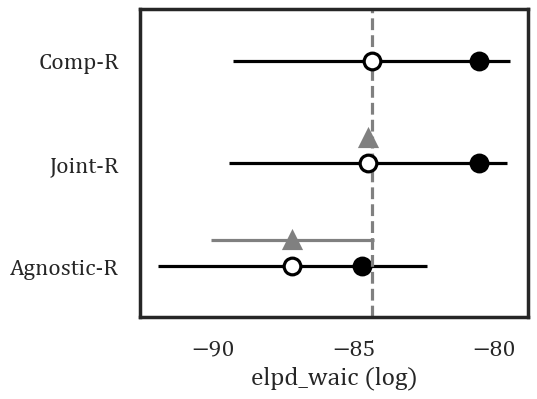

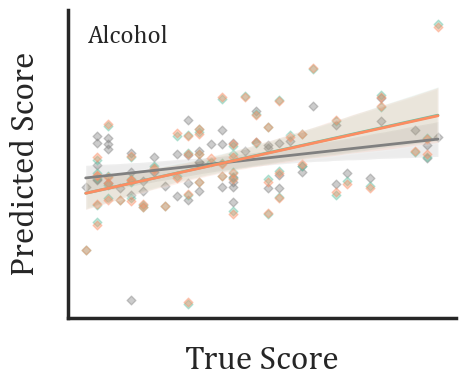

In [76]:
alc_perf_df = performance_comp(alc_sm_model_dict, alc_bmb_model_dict, bambi_flag=True)
plot_posterior_predictive(alc_bmb_model_dict, alc_perf_df, alc_reg_params, 'alcohol')

Model        R2    R2_adj         AIC         BIC
0           LRBias_JEC_filtered  0.234415  0.194816  167.387242  175.895779
1  combined_LRBias_JEC_filtered  0.234415  0.194816  167.387242  175.895779
2       model_agnostic_filtered  0.110962  0.096144  172.656259  176.910528
3                model_agnostic  0.134916  0.074208  176.962816  187.598488
4                    LRBias_JEC  0.303723  0.076676  185.503893  219.538044
5           combined_LRBias_JEC  0.358301  0.068009  188.442926  230.985614

rank  elpd_waic    p_waic  elpd_diff        weight        se  \
Comp-R         0 -84.358248  3.835014   0.000000  8.629857e-01  4.929229   
Joint-R        1 -84.491359  3.947632   0.133111  5.019643e-16  4.934560   
Agnostic-R     2 -87.180349  2.462247   2.822101  1.370143e-01  4.792966   

                 dse  warning scale  
Comp-R      0.000000     True   log  
Joint-R     0.041070     True   log  
Agnostic-R  2.917264    False   log

predicted ~ true * model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, true, model, true:model, predicted_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              predicted   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     9.726
Date:                Thu, 01 Jun 2023   Prob (F-statistic):           8.56e-06
Time:                        12:20:54   Log-Likelihood:                -53.518
No. Observations:                 124   AIC:                             115.0
Df Residuals:                     120   BIC:                             126.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0020      0.048      0.041      0.968      -0.093       0.097
true           0.1157      0.048      2.405      0.018       0.020       0.211
model         -0.0005      0.068     -0.007      0.994      -0.135       0.134
true:model     0.1170      0.068      1.720      0.088      -0.018       0.252
==============================================================================
Omnibus:                       19.177   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.728
Skew:                          -0.632   Prob(JB):                     3.89e-09
Kurtosis:                       5.429   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

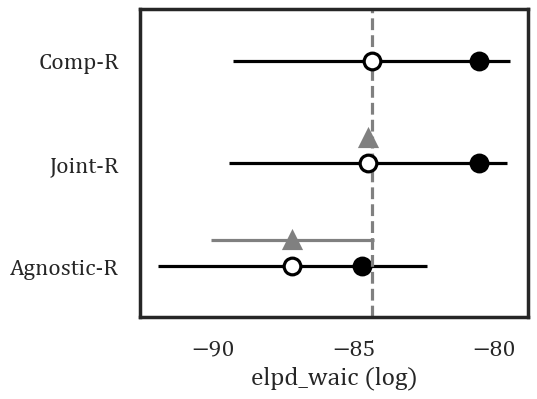

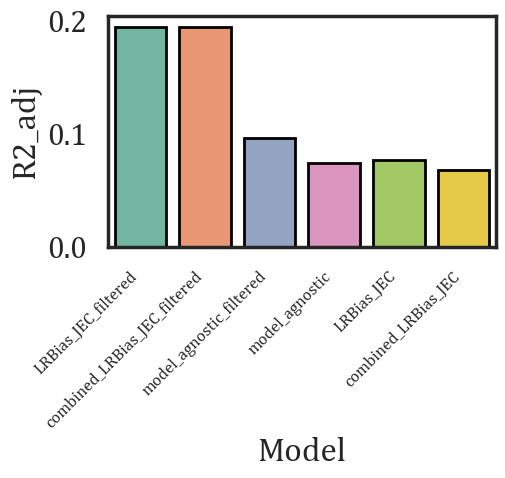

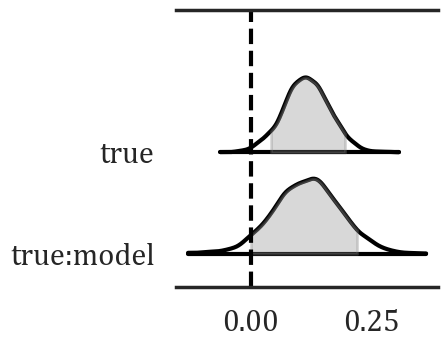

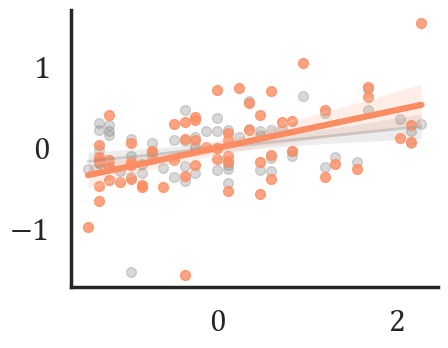

In [77]:
alc_perf_df = performance_comp(alc_sm_model_dict, alc_bmb_model_dict, bambi_flag=True)
plot_r2_adj(alc_perf_df)
plot_sig_improvement(alc_bmb_model_dict, alc_reg_params, alc_perf_df)
plot_sig_improvement2(alc_bmb_model_dict, alc_reg_params, alc_perf_df)

In [78]:
alc_sm_model_dict[alc_perf_df.iloc[0]['Model']].summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.195   
Dependent Variable: ASSIST_Alcohol   AIC:                167.3872
Date:               2023-06-01 12:20 BIC:                175.8958
No. Observations:   62               Log-Likelihood:     -79.694 
Df Model:           3                F-statistic:        5.920   
Df Residuals:       58               Prob (F-statistic): 0.00136 
R-squared:          0.234            Scale:              0.81838 
------------------------------------------------------------------
               Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -0.0000    0.1149  -0.0000  1.0000  -0.2300   0.2300
beta           0.3502    0.1318   2.6575  0.0102   0.0864   0.6140
cec_weight    -0.3658    0.1345  -2.7199  0.0086  -0.6350  -0.0966
weight_zero    0.4117    0.1187   3.4697  0.0010   0.1742   0.6492
-----------------------------------------------------------------
Omnibus:              4.061        Durbin-Watson:           1.358
Prob(Omnibus):        0.131        Jarque-Bera (JB):        3.990
Skew:                 0.595        Prob(JB):                0.136
Kurtosis:             2.641        Condition No.:           2    
=================================================================

"""

In [79]:
alc_sm_model_dict['LRBias_JEC'].summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:               OLS               Adj. R-squared:      0.077   
Dependent Variable:  ASSIST_Alcohol    AIC:                 185.5039
Date:                2023-06-01 12:20  BIC:                 219.5380
No. Observations:    62                Log-Likelihood:      -76.752 
Df Model:            15                F-statistic:         1.338   
Df Residuals:        46                Prob (F-statistic):  0.220   
R-squared:           0.304             Scale:               0.93846 
--------------------------------------------------------------------
                       Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
--------------------------------------------------------------------
Intercept             -0.0658   0.2480 -0.2653 0.7920 -0.5651 0.4335
alpha_pos              0.1733   0.1585  1.0930 0.2801 -0.1458 0.4924
alpha_neg              0.1233   0.1706  0.7230 0.4733 -0.2200 0.4667
beta                   0.1939   0.1864  1.0401 0.3037 -0.1814 0.5692
weight_zero            0.5561   0.2069  2.6876 0.0100  0.1396 0.9727
weight_one             0.1671   0.2013  0.8304 0.4106 -0.2380 0.5722
weight_two             0.1929   0.1815  1.0628 0.2934 -0.1724 0.5582
cec_weight            -0.3269   0.1755 -1.8624 0.0689 -0.6803 0.0264
mod                   -0.1865   0.2107 -0.8852 0.3806 -0.6106 0.2376
DEMO_age               0.0312   0.1451  0.2154 0.8304 -0.2607 0.3232
DEMO_sex_Female        0.3849   0.3447  1.1165 0.2700 -0.3090 1.0787
DEMO_sex_Male          0.0375   0.3238  0.1158 0.9083 -0.6142 0.6892
DEMO_sex_Other        -0.4882   0.7927 -0.6158 0.5410 -2.0837 1.1074
DEMO_edu_College      -0.1436   0.2457 -0.5845 0.5617 -0.6381 0.3509
DEMO_edu_Graduate      0.1151   0.3032  0.3797 0.7059 -0.4951 0.7254
DEMO_edu_High_School  -0.3124   0.4245 -0.7360 0.4655 -1.1668 0.5420
DEMO_edu_Some_HS       0.3337   0.6882  0.4849 0.6301 -1.0515 1.7189
DEMO_edu_Some_college -0.0586   0.3123 -0.1876 0.8520 -0.6873 0.5701
--------------------------------------------------------------------
Omnibus:           4.552     Durbin-Watson:        1.413            
Prob(Omnibus):     0.103     Jarque-Bera (JB):     4.198            
Skew:              0.637     Prob(JB):             0.123            
Kurtosis:          2.969     Condition No.:        22407135337866124
====================================================================
* The condition number is large (2e+16). This might indicate
strong multicollinearity or other numerical problems.
"""

/var/folders/p4/n3rrj_kd3n76hx_5y5q4qvfh0000gn/T/ipykernel_22060/3465972023.py:272: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(glm_param_df['Predictor'], rotation=45)


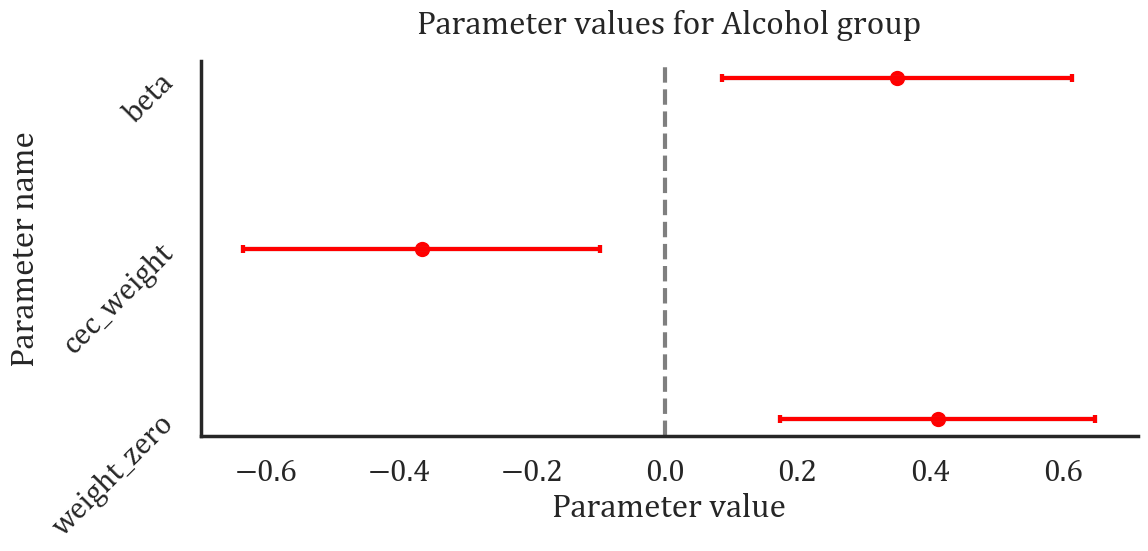

In [80]:
alc_glm_params_df = generate_param_estimates_df(alc_sm_model_dict[alc_perf_df.iloc[0]['Model']], 'Alcohol')
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plot_from_df(glm_param_df=alc_glm_params_df, ax=ax, group='Alcohol')
plt.tight_layout()
# alc_glm_params_df

/var/folders/p4/n3rrj_kd3n76hx_5y5q4qvfh0000gn/T/ipykernel_22060/3465972023.py:272: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(glm_param_df['Predictor'], rotation=45)


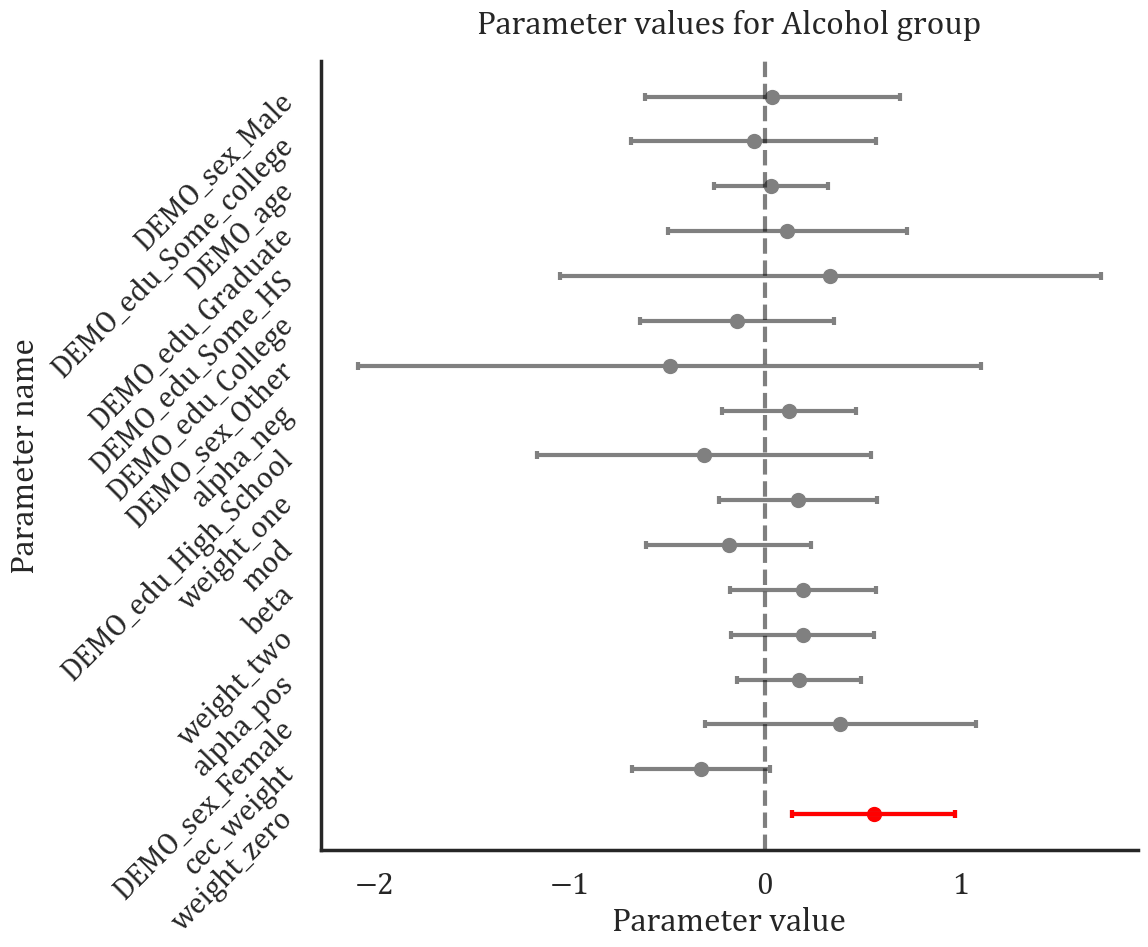

In [81]:
alc_glm_params_df_unfiltered = generate_param_estimates_df(alc_sm_model_dict['LRBias_JEC'], 'Alcohol')
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plot_from_df(glm_param_df=alc_glm_params_df_unfiltered, ax=ax, group='Alcohol')
plt.tight_layout()
# alc_glm_params_df_unfiltered

### Alcohol modular (run 1 only)

In [ ]:
alc_sm_model_dict = {}
alc_bmb_model_dict = {}
for typ in ['comp', 'nonmodel', 'combined']:
    alc_sm_model_dict, alc_bmb_model_dict, alc_reg_params = run_group_regression(
        mdf=master_dfs['alcohol'][master_dfs['alcohol']['Round_x'] == 1],
        group='alcohol',
        model_name=best_models['alcohol'][0],
        dependent_var='ASSIST_Alcohol',
        typ=typ,
        sm_model_dict=alc_sm_model_dict,
        bmb_model_dict=alc_bmb_model_dict,
        bambi_flag=True,
        sig_threshold=0.1
    )

Running regression for alcohol A_Rew_RWSep_2stepSep ASSIST_Alcohol...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, alpha_pos, alpha_neg, beta, weight_zero, weight_one, weight_two, weight_three, weight_four, weight_five, weight_six, cec_weight, mod, DEMO_age, DEMO_sex_Female, DEMO_sex_Male, DEMO_sex_Other, DEMO_edu_College, DEMO_edu_Graduate, DEMO_edu_High_School, DEMO_edu_Some_college, ASSIST_Alcohol_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, weight_zero, weight_two, DEMO_edu_College, DEMO_edu_Graduate, ASSIST_Alcohol_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Running regression for alcohol model_agnostic ASSIST_Alcohol...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, mean_craving_ratings, std_craving_ratings, mean_mood_ratings, std_mood_ratings, ASSIST_Alcohol_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Running regression for alcohol combined ASSIST_Alcohol...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, alpha_pos, alpha_neg, beta, weight_zero, weight_one, weight_two, weight_three, weight_four, weight_five, weight_six, cec_weight, mod, DEMO_age, DEMO_sex_Female, DEMO_sex_Male, DEMO_sex_Other, DEMO_edu_College, DEMO_edu_Graduate, DEMO_edu_High_School, DEMO_edu_Some_college, mean_craving_ratings, std_craving_ratings, mean_mood_ratings, std_mood_ratings, ASSIST_Alcohol_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, DEMO_sex_Male, std_mood_ratings, weight_two, DEMO_edu_Graduate, DEMO_edu_College, ASSIST_Alcohol_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Model        R2    R2_adj         AIC         BIC
0              combined_filtered  0.448314  0.346150   86.022343   95.001389
1  A_Rew_RWSep_2stepSep_filtered  0.384417  0.296476   87.638841   95.121379
2                 model_agnostic  0.092945 -0.036634  100.430705  107.913243
3           A_Rew_RWSep_2stepSep  0.555843 -0.015216  104.867894  133.301538
4                       combined  0.643432 -0.141018  105.619365  140.039039

rank  elpd_waic     p_waic  elpd_diff  \
combined_filtered                 0 -44.286909   5.752286   0.000000   
A_Rew_RWSep_2stepSep_filtered     1 -44.987472   5.078156   0.700563   
model_agnostic                    2 -51.510059   5.206004   7.223150   
A_Rew_RWSep_2stepSep              3 -57.013754  13.373058  12.726845   
combined                          4 -59.228602  14.846248  14.941693   

                                     weight        se       dse  warning scale  
combined_filtered              6.517145e-01  3.502270  0.000000     True   log  
A_Rew_RWSep_2stepSep_filtered  3.482855e-01  3.316659  2.177648     True   log  
model_agnostic                 0.000000e+00  3.450030  3.104852     True   log  
A_Rew_RWSep_2stepSep           0.000000e+00  2.651178  3.463848     True   log  
combined                       2.839950e-13  1.788811  2.796255     True   log

predicted ~ true * model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, true, model, true:model, predicted_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              predicted   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     12.97
Date:                Sat, 18 Mar 2023   Prob (F-statistic):           1.12e-06
Time:                        21:02:41   Log-Likelihood:                -34.374
No. Observations:                  66   AIC:                             76.75
Df Residuals:                      62   BIC:                             85.51
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0010      0.073     -0.013      0.989      -0.147       0.145
true           0.0925      0.073      1.265      0.211      -0.054       0.239
model          0.0028      0.103      0.027      0.979      -0.204       0.210
true:model     0.3543      0.103      3.425      0.001       0.148       0.561
==============================================================================
Omnibus:                        8.077   Durbin-Watson:                   1.666
Prob(Omnibus):                  0.018   Jarque-Bera (JB):               10.752
Skew:                          -0.439   Prob(JB):                      0.00463
Kurtosis:                       4.771   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

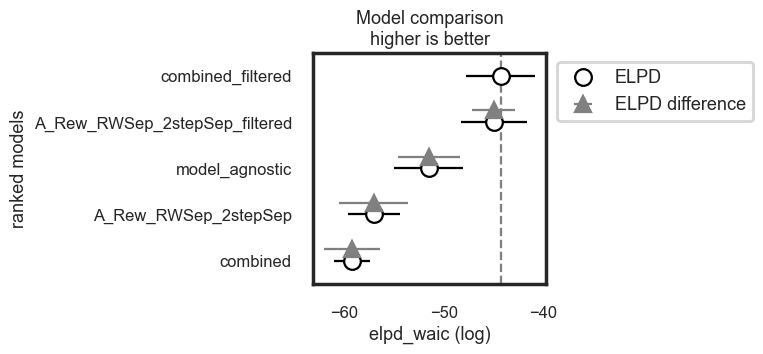

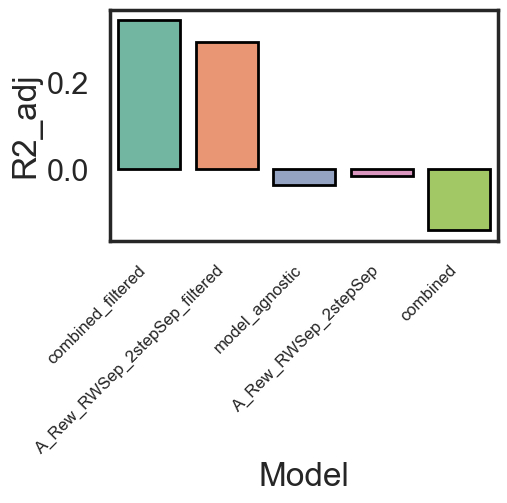

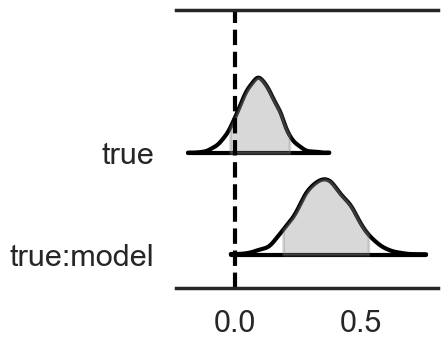

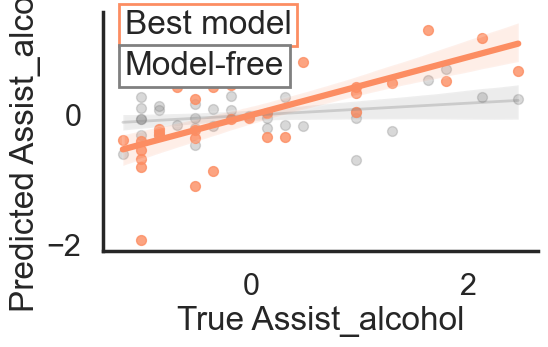

In [ ]:
alc_perf_df = performance_comp(alc_sm_model_dict, alc_bmb_model_dict, bambi_flag=True)
plot_r2_adj(alc_perf_df)
plot_sig_improvement(alc_bmb_model_dict, alc_reg_params, alc_perf_df)
plot_sig_improvement2(alc_bmb_model_dict, alc_reg_params, alc_perf_df)

In [ ]:
alc_sm_model_dict[alc_perf_df.iloc[0]['Model']].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ASSIST_Alcohol   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     4.388
Date:                Sat, 18 Mar 2023   Prob (F-statistic):            0.00472
Time:                        21:02:50   Log-Likelihood:                -37.011
No. Observations:                  33   AIC:                             86.02
Df Residuals:                      27   BIC:                             95.00
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.5629      0.336     -1.675      0.105      -1.252       0.127
DEMO_sex_Male        -0.6709      0.336     -1.995      0.056      -1.361       0.019
std_mood_ratings     -0.3600      0.156     -2.301      0.029      -0.681      -0.039
weight_two           -0.3844      0.151     -2.548      0.017      -0.694      -0.075
DEMO_edu_Graduate     1.2176      0.413      2.947      0.007       0.370       2.065
DEMO_edu_College      1.3879      0.382      3.632      0.001       0.604       2.172
==============================================================================
Omnibus:                        0.639   Durbin-Watson:                   2.155
Prob(Omnibus):                  0.727   Jarque-Bera (JB):                0.737
Skew:                           0.259   Prob(JB):                        0.692
Kurtosis:                       2.484   Cond. No.                         5.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/var/folders/p4/n3rrj_kd3n76hx_5y5q4qvfh0000gn/T/ipykernel_49386/1244148549.py:251: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(glm_param_df['Predictor'], rotation=45)


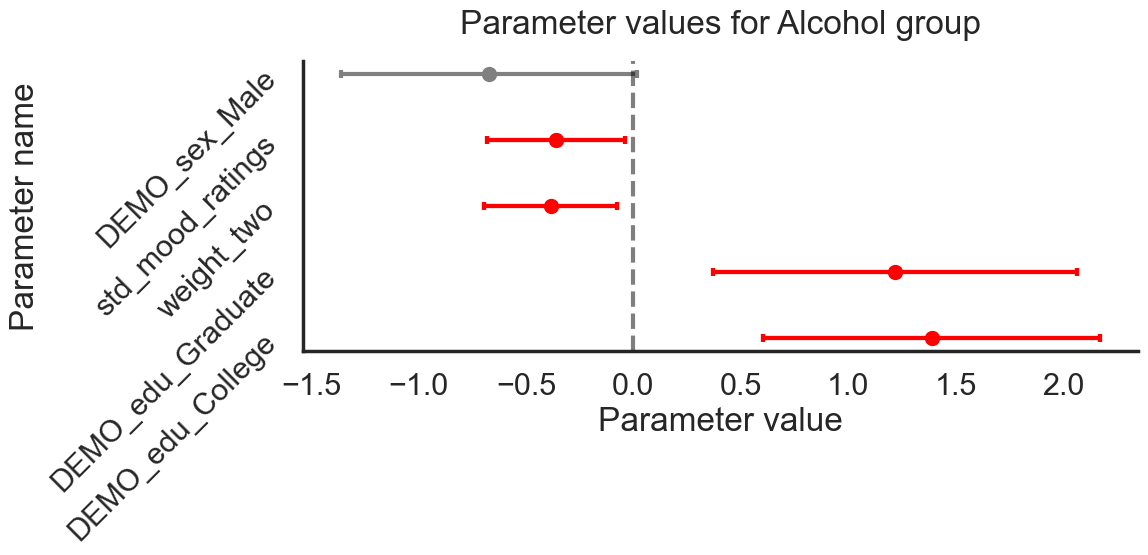

In [ ]:
alc_glm_params_df = generate_param_estimates_df(alc_sm_model_dict[alc_perf_df.iloc[0]['Model']], 'Alcohol')
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plot_from_df(glm_param_df=alc_glm_params_df, ax=ax, group='Alcohol')
plt.tight_layout()
# alc_glm_params_df

/var/folders/p4/n3rrj_kd3n76hx_5y5q4qvfh0000gn/T/ipykernel_49386/1244148549.py:251: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(glm_param_df['Predictor'], rotation=45)


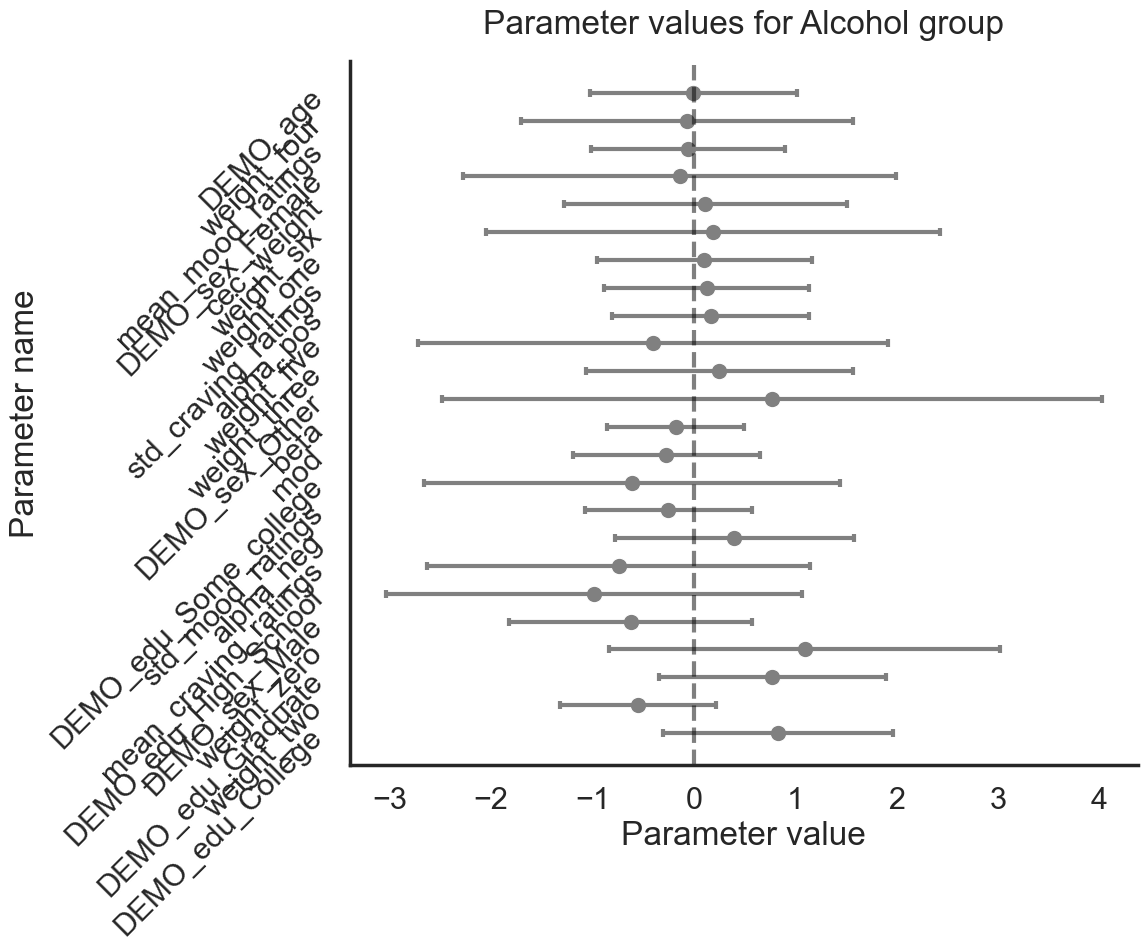

In [ ]:
alc_glm_params_df_unfiltered = generate_param_estimates_df(alc_sm_model_dict['combined'], 'Alcohol')
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plot_from_df(glm_param_df=alc_glm_params_df_unfiltered, ax=ax, group='Alcohol')
plt.tight_layout()
# alc_glm_params_df_unfiltered

### Alcohol modular (run 2 only)

In [ ]:
alc_sm_model_dict = {}
alc_bmb_model_dict = {}
for typ in ['comp', 'nonmodel', 'combined']:
    alc_sm_model_dict, alc_bmb_model_dict, alc_reg_params = run_group_regression(
        mdf=master_dfs['alcohol'][master_dfs['alcohol']['Round_x'] == 2],
        group='alcohol',
        model_name=best_models['alcohol'][0],
        dependent_var='ASSIST_Alcohol',
        typ=typ,
        sm_model_dict=alc_sm_model_dict,
        bmb_model_dict=alc_bmb_model_dict,
        bambi_flag=True,
        sig_threshold=0.1
    )

Running regression for alcohol A_Rew_RWSep_2stepSep ASSIST_Alcohol...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, alpha_pos, alpha_neg, beta, weight_zero, weight_one, weight_two, weight_three, weight_four, weight_five, weight_six, cec_weight, mod, DEMO_age, DEMO_sex_Female, DEMO_sex_Male, DEMO_edu_College, DEMO_edu_Graduate, DEMO_edu_High_School, DEMO_edu_Some_HS, DEMO_edu_Some_college, ASSIST_Alcohol_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, DEMO_sex_Male, DEMO_sex_Female, weight_six, weight_zero, weight_three, weight_one, weight_five, cec_weight, ASSIST_Alcohol_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


Running regression for alcohol model_agnostic ASSIST_Alcohol...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, mean_craving_ratings, std_craving_ratings, mean_mood_ratings, std_mood_ratings, ASSIST_Alcohol_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, mean_craving_ratings, ASSIST_Alcohol_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Running regression for alcohol combined ASSIST_Alcohol...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, alpha_pos, alpha_neg, beta, weight_zero, weight_one, weight_two, weight_three, weight_four, weight_five, weight_six, cec_weight, mod, DEMO_age, DEMO_sex_Female, DEMO_sex_Male, DEMO_edu_College, DEMO_edu_Graduate, DEMO_edu_High_School, DEMO_edu_Some_HS, DEMO_edu_Some_college, mean_craving_ratings, std_craving_ratings, mean_mood_ratings, std_mood_ratings, ASSIST_Alcohol_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, std_craving_ratings, weight_zero, weight_four, weight_six, cec_weight, ASSIST_Alcohol_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Model        R2    R2_adj        AIC         BIC
0              combined_filtered  0.482172  0.369601  75.213186   83.416961
1  A_Rew_RWSep_2stepSep_filtered  0.500874  0.334499  78.146433   89.084799
2        model_agnostic_filtered  0.103402  0.070194  83.133159   85.867751
3                 model_agnostic  0.193612  0.059214  86.057921   92.894400
4                       combined  0.719646 -0.308319  91.419068  122.866872
5           A_Rew_RWSep_2stepSep  0.578704 -0.179629  95.230264  121.208885

rank  elpd_waic     p_waic  elpd_diff  \
combined_filtered                 0 -38.503856   4.978834   0.000000   
A_Rew_RWSep_2stepSep_filtered     1 -39.843458   5.654025   1.339602   
model_agnostic_filtered           2 -42.326400   2.197943   3.822544   
model_agnostic                    3 -43.691508   4.165363   5.187652   
combined                          4 -51.450460  13.614489  12.946604   
A_Rew_RWSep_2stepSep              5 -51.581459  12.285122  13.077603   

                                     weight        se       dse  warning scale  
combined_filtered              6.656610e-01  4.111468  0.000000     True   log  
A_Rew_RWSep_2stepSep_filtered  3.343390e-01  3.132745  3.175633     True   log  
model_agnostic_filtered        1.383005e-12  2.652802  3.347934    False   log  
model_agnostic                 1.266900e-12  2.565953  3.353978     True   log  
combined                       4.401857e-13  2.037825  3.329933     True   log  
A_Rew_RWSep_2stepSep           0.000000e+00  2.541920  2.781391     True   log

predicted ~ true * model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, true, model, true:model, predicted_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              predicted   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     12.88
Date:                Sat, 18 Mar 2023   Prob (F-statistic):           1.85e-06
Time:                        21:05:13   Log-Likelihood:                -29.852
No. Observations:                  58   AIC:                             67.70
Df Residuals:                      54   BIC:                             75.95
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0024      0.078     -0.031      0.975      -0.159       0.154
true           0.1058      0.078      1.358      0.180      -0.050       0.262
model          0.0046      0.110      0.042      0.967      -0.216       0.226
true:model     0.3667      0.110      3.328      0.002       0.146       0.588
==============================================================================
Omnibus:                        2.963   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.227   Jarque-Bera (JB):                2.422
Skew:                           0.144   Prob(JB):                        0.298
Kurtosis:                       3.958   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

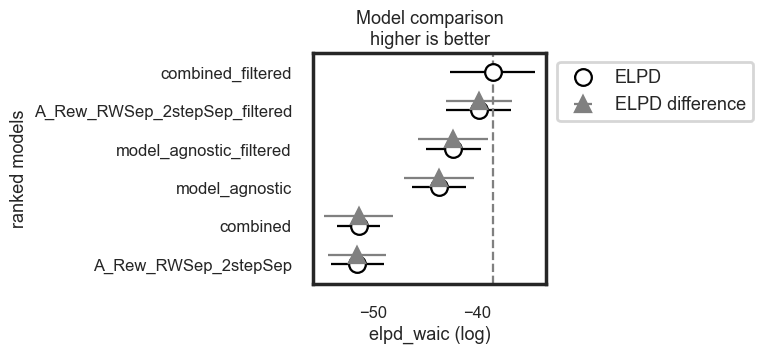

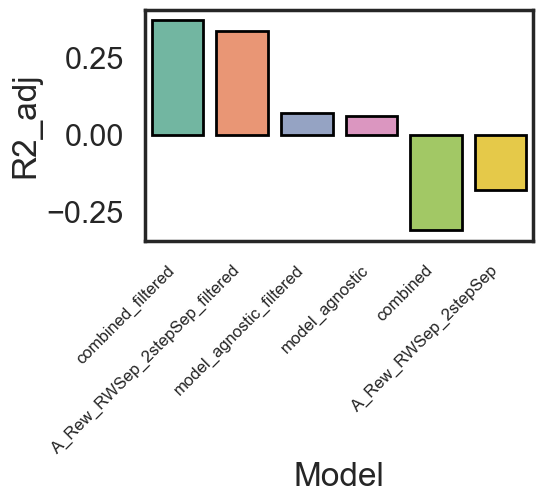

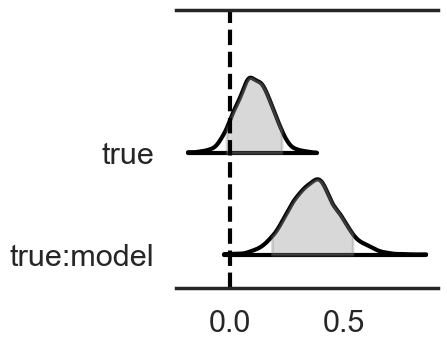

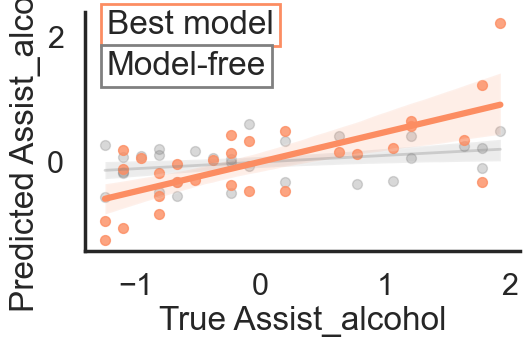

In [ ]:
alc_perf_df = performance_comp(alc_sm_model_dict, alc_bmb_model_dict, bambi_flag=True)
plot_r2_adj(alc_perf_df)
plot_sig_improvement(alc_bmb_model_dict, alc_reg_params, alc_perf_df)
plot_sig_improvement2(alc_bmb_model_dict, alc_reg_params, alc_perf_df)

In [ ]:
alc_sm_model_dict[alc_perf_df.iloc[0]['Model']].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ASSIST_Alcohol   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     4.283
Date:                Sat, 18 Mar 2023   Prob (F-statistic):            0.00671
Time:                        21:05:14   Log-Likelihood:                -31.607
No. Observations:                  29   AIC:                             75.21
Df Residuals:                      23   BIC:                             83.42
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            5.381e-17      0.150   3.59e-16      1.000      -0.310       0.310
std_craving_ratings    -0.4106      0.171     -2.397      0.025      -0.765      -0.056
weight_zero             0.5637      0.221      2.556      0.018       0.107       1.020
weight_four             0.5095      0.191      2.671      0.014       0.115       0.904
weight_six              0.6873      0.243      2.827      0.010       0.184       1.190
cec_weight             -0.5978      0.209     -2.859      0.009      -1.030      -0.165
==============================================================================
Omnibus:                        5.535   Durbin-Watson:                   2.190
Prob(Omnibus):                  0.063   Jarque-Bera (JB):                3.762
Skew:                           0.769   Prob(JB):                        0.152
Kurtosis:                       3.863   Cond. No.                         3.26
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/var/folders/p4/n3rrj_kd3n76hx_5y5q4qvfh0000gn/T/ipykernel_49386/1244148549.py:251: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(glm_param_df['Predictor'], rotation=45)


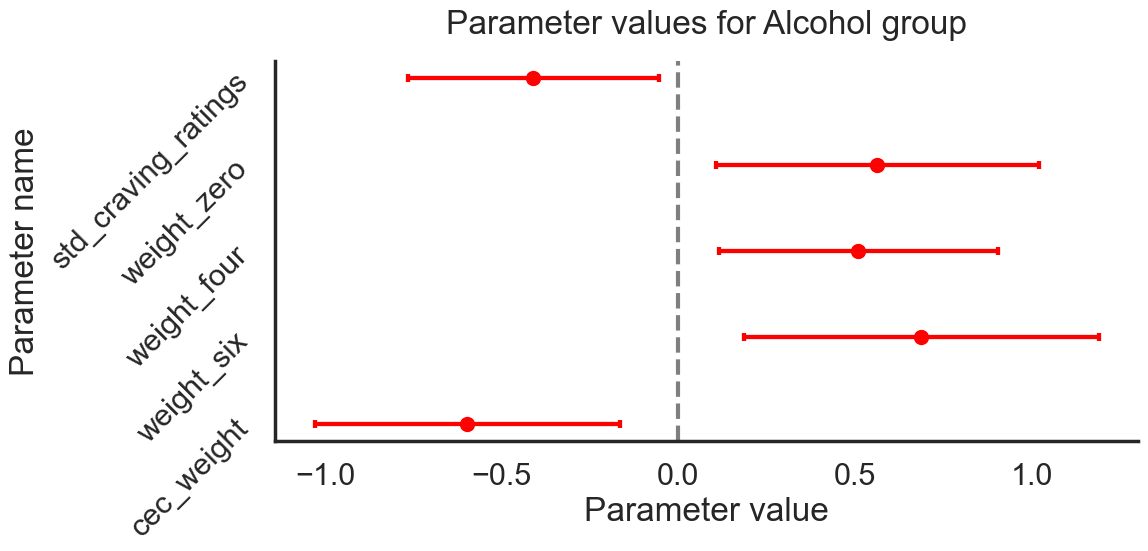

In [ ]:
alc_glm_params_df = generate_param_estimates_df(alc_sm_model_dict[alc_perf_df.iloc[0]['Model']], 'Alcohol')
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plot_from_df(glm_param_df=alc_glm_params_df, ax=ax, group='Alcohol')
plt.tight_layout()
# alc_glm_params_df

/var/folders/p4/n3rrj_kd3n76hx_5y5q4qvfh0000gn/T/ipykernel_49386/1244148549.py:251: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(glm_param_df['Predictor'], rotation=45)


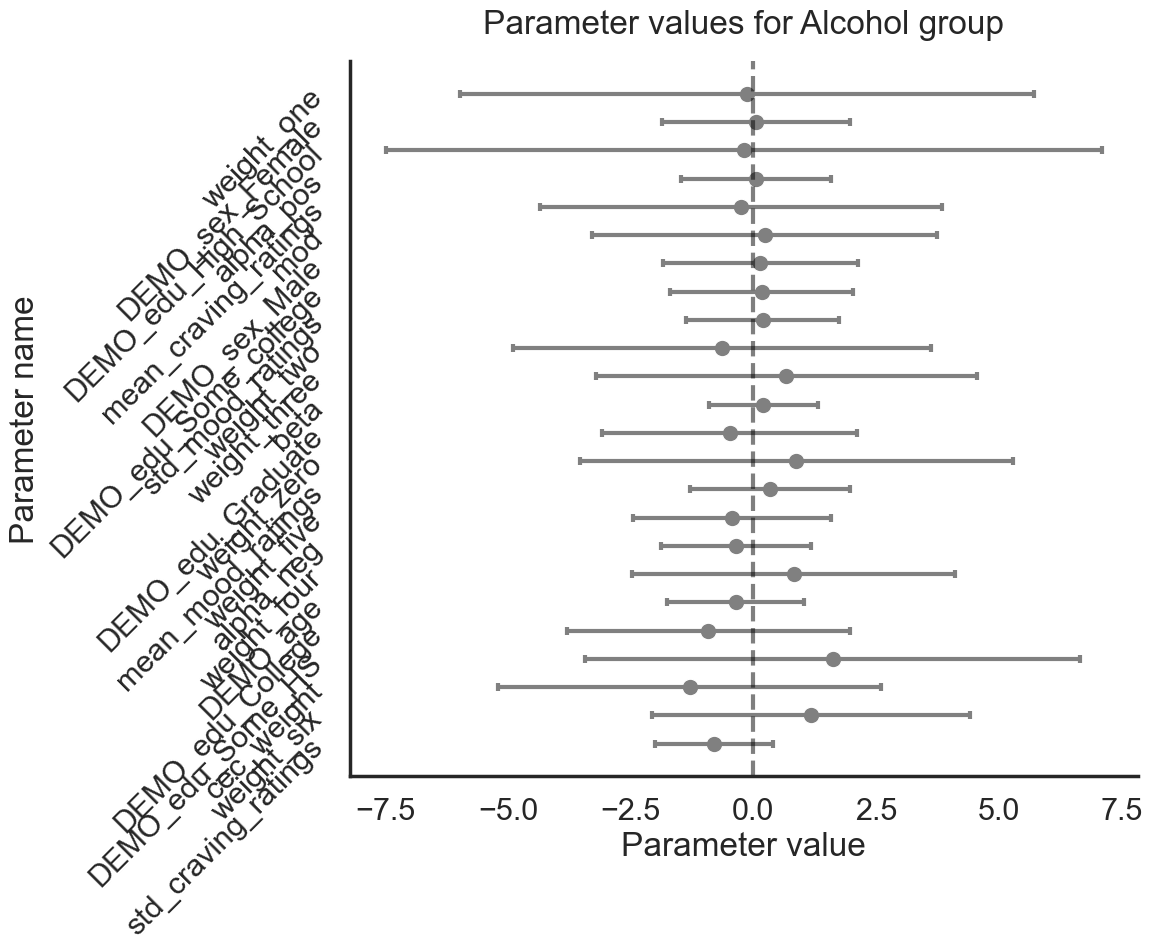

In [ ]:
alc_glm_params_df_unfiltered = generate_param_estimates_df(alc_sm_model_dict['combined'], 'Alcohol')
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plot_from_df(glm_param_df=alc_glm_params_df_unfiltered, ax=ax, group='Alcohol')
plt.tight_layout()
# alc_glm_params_df_unfiltered

### Cannabis modular

In [56]:
cannabis_sm_model_dict = {}
cannabis_bmb_model_dict = {}
for typ in ['comp', 'nonmodel', 'combined']:
    cannabis_sm_model_dict, cannabis_bmb_model_dict, cannabis_reg_params = run_group_regression(
        mdf=master_dfs['cannabis'],
        group='cannabis',
        model_names=['LRBias_JEC'],
        dependent_var='CAST_Cannabis',
        typ=typ,
        block='other',
        sm_model_dict=cannabis_sm_model_dict,
        bmb_model_dict=cannabis_bmb_model_dict,
        bambi_flag=True,
        sig_threshold=0.1
    )

Running regression for cannabis LRBias_JEC CAST_Cannabis...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, alpha_pos, alpha_neg, beta, weight_zero, weight_one, weight_two, cec_weight, mod, DEMO_age, DEMO_sex_Female, DEMO_sex_Male, DEMO_edu_College, DEMO_edu_Graduate, DEMO_edu_High_School, DEMO_edu_Some_college, CAST_Cannabis_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, beta, weight_zero, mod, weight_one, alpha_pos, CAST_Cannabis_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Running regression for cannabis model_agnostic CAST_Cannabis...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, mean_craving_ratings, std_craving_ratings, mean_mood_ratings, std_mood_ratings, CAST_Cannabis_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, mean_craving_ratings, CAST_Cannabis_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Running regression for cannabis combined_LRBias_JEC CAST_Cannabis...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, alpha_pos, alpha_neg, beta, weight_zero, weight_one, weight_two, cec_weight, mod, DEMO_age, DEMO_sex_Female, DEMO_sex_Male, DEMO_edu_College, DEMO_edu_Graduate, DEMO_edu_High_School, DEMO_edu_Some_college, mean_craving_ratings, std_craving_ratings, mean_mood_ratings, std_mood_ratings, CAST_Cannabis_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, DEMO_sex_Male, beta, mod, mean_craving_ratings, alpha_pos, weight_one, CAST_Cannabis_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Model        R2    R2_adj         AIC         BIC
0  combined_LRBias_JEC_filtered  0.438790  0.376433  151.873251  166.649369
1           LRBias_JEC_filtered  0.364951  0.307220  157.413228  170.078471
2           combined_LRBias_JEC  0.536100  0.352698  162.257211  200.252940
3                    LRBias_JEC  0.458348  0.308529  163.709499  193.261733
4       model_agnostic_filtered  0.166129  0.151996  166.028218  170.249966
5                model_agnostic  0.204808  0.148009  169.130999  179.685369

rank  elpd_waic    p_waic  elpd_diff        weight         se  \
Joint-R        0 -78.610068  9.185055   0.000000  8.163633e-01  10.426471   
Comp-R         1 -81.286518  8.385948   2.676449  1.318688e-16   9.279010   
Agnostic-R     2 -84.556582  3.751795   5.946514  1.836367e-01   7.555917   

                 dse  warning scale  
Joint-R     0.000000     True   log  
Comp-R      3.548606     True   log  
Agnostic-R  5.821593     True   log

predicted ~ true * model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, true, model, true:model, predicted_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              predicted   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     22.85
Date:                Thu, 01 Jun 2023   Prob (F-statistic):           9.82e-12
Time:                        12:14:52   Log-Likelihood:                -72.486
No. Observations:                 122   AIC:                             153.0
Df Residuals:                     118   BIC:                             164.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0018      0.057     -0.032      0.974      -0.115       0.111
true           0.1663      0.057      2.914      0.004       0.053       0.279
model          0.0037      0.081      0.045      0.964      -0.156       0.163
true:model     0.2760      0.081      3.420      0.001       0.116       0.436
==============================================================================
Omnibus:                        9.296   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               11.055
Skew:                           0.465   Prob(JB):                      0.00398
Kurtosis:                       4.144   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

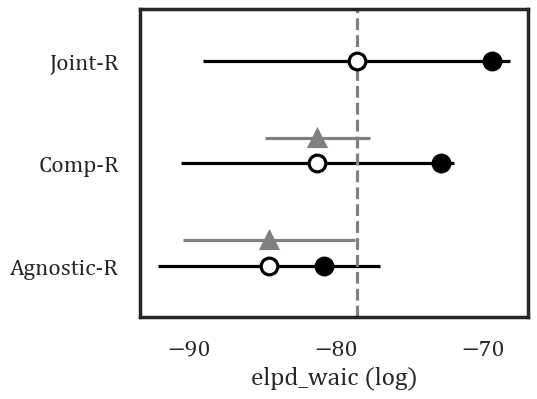

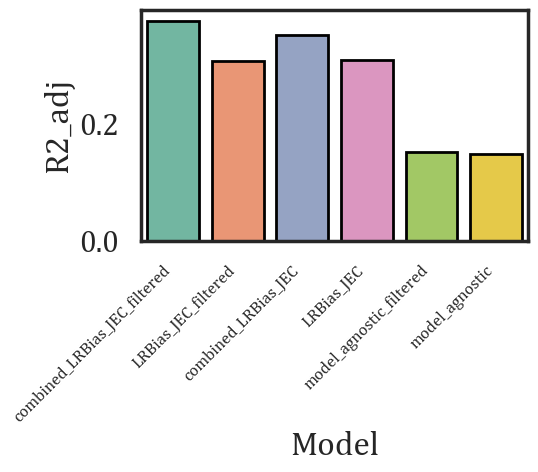

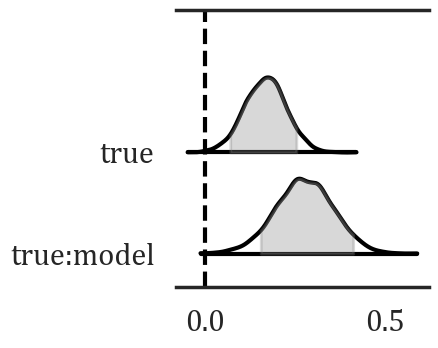

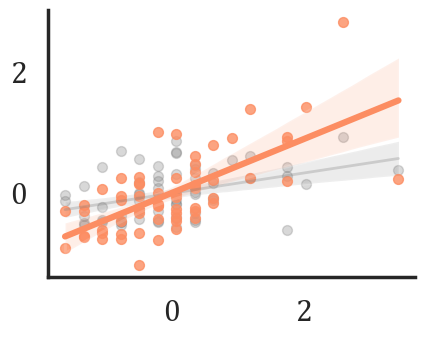

In [57]:
cannabis_perf_df = performance_comp(cannabis_sm_model_dict, cannabis_bmb_model_dict, bambi_flag=True)
plot_r2_adj(cannabis_perf_df)
plot_sig_improvement(cannabis_bmb_model_dict, cannabis_reg_params, cannabis_perf_df)
plot_sig_improvement2(cannabis_bmb_model_dict, cannabis_reg_params, cannabis_perf_df)

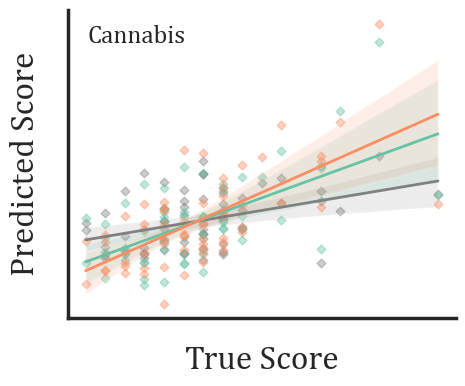

In [58]:
plot_posterior_predictive(cannabis_bmb_model_dict, cannabis_perf_df, cannabis_reg_params, 'cannabis')

In [59]:
cannabis_sm_model_dict[cannabis_perf_df.iloc[0]['Model']].summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:               OLS               Adj. R-squared:      0.376   
Dependent Variable:  CAST_Cannabis     AIC:                 151.8733
Date:                2023-06-01 12:14  BIC:                 166.6494
No. Observations:    61                Log-Likelihood:      -68.937 
Df Model:            6                 F-statistic:         7.037   
Df Residuals:        54                Prob (F-statistic):  1.44e-05
R-squared:           0.439             Scale:               0.63396 
--------------------------------------------------------------------
                      Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
--------------------------------------------------------------------
Intercept            -0.2058   0.1549 -1.3287 0.1895 -0.5164  0.1047
DEMO_sex_Male         0.3693   0.2092  1.7648 0.0832 -0.0502  0.7888
beta                  0.2056   0.1157  1.7772 0.0812 -0.0263  0.4376
mod                   0.2906   0.1167  2.4907 0.0159  0.0567  0.5246
mean_craving_ratings  0.3888   0.1133  3.4303 0.0012  0.1616  0.6160
alpha_pos            -0.3774   0.1110 -3.4002 0.0013 -0.5999 -0.1549
weight_one           -0.3939   0.1133 -3.4759 0.0010 -0.6212 -0.1667
--------------------------------------------------------------------
Omnibus:               23.523        Durbin-Watson:           2.239 
Prob(Omnibus):         0.000         Jarque-Bera (JB):        51.291
Skew:                  1.163         Prob(JB):                0.000 
Kurtosis:              6.843         Condition No.:           3     
====================================================================

"""

In [60]:
cannabis_sm_model_dict['combined_LRBias_JEC'].summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
=====================================================================
Model:                OLS               Adj. R-squared:      0.353   
Dependent Variable:   CAST_Cannabis     AIC:                 162.2572
Date:                 2023-06-01 12:14  BIC:                 200.2529
No. Observations:     61                Log-Likelihood:      -63.129 
Df Model:             17                F-statistic:         2.923   
Df Residuals:         43                Prob (F-statistic):  0.00228 
R-squared:            0.536             Scale:               0.65809 
---------------------------------------------------------------------
                       Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------
Intercept              0.0040   0.0707  0.0567 0.9551 -0.1385  0.1465
alpha_pos             -0.4092   0.1712 -2.3895 0.0213 -0.7545 -0.0638
alpha_neg             -0.0888   0.2054 -0.4323 0.6677 -0.5031  0.3255
beta                   0.1635   0.1460  1.1200 0.2689 -0.1309  0.4579
weight_zero           -0.4002   0.3223 -1.2415 0.2211 -1.0502  0.2498
weight_one            -0.3932   0.1748 -2.2492 0.0297 -0.7458 -0.0407
weight_two            -0.0178   0.1516 -0.1173 0.9072 -0.3236  0.2880
cec_weight            -0.1440   0.1588 -0.9070 0.3695 -0.4642  0.1762
mod                    0.4284   0.2014  2.1264 0.0393  0.0221  0.8346
DEMO_age              -0.0999   0.1245 -0.8024 0.4267 -0.3510  0.1512
DEMO_sex_Female       -0.1297   0.1212 -1.0700 0.2906 -0.3741  0.1147
DEMO_sex_Male          0.1337   0.1163  1.1494 0.2568 -0.1009  0.3682
DEMO_edu_College       0.0673   0.1811  0.3718 0.7119 -0.2979  0.4326
DEMO_edu_Graduate     -0.3633   0.2227 -1.6317 0.1101 -0.8124  0.0857
DEMO_edu_High_School   0.3690   0.3443  1.0716 0.2899 -0.3254  1.0634
DEMO_edu_Some_college -0.0690   0.2422 -0.2849 0.7771 -0.5574  0.4194
mean_craving_ratings   0.5235   0.4499  1.1637 0.2510 -0.3837  1.4307
std_craving_ratings   -0.3118   0.2355 -1.3242 0.1924 -0.7868  0.1631
mean_mood_ratings      0.1249   0.1295  0.9642 0.3404 -0.1363  0.3860
std_mood_ratings       0.1001   0.1515  0.6607 0.5123 -0.2054  0.4056
---------------------------------------------------------------------
Omnibus:           19.491     Durbin-Watson:        2.065            
Prob(Omnibus):     0.000      Jarque-Bera (JB):     35.495           
Skew:              1.028      Prob(JB):             0.000            
Kurtosis:          6.120      Condition No.:        73949512912976672
=====================================================================
* The condition number is large (7e+16). This might indicate
strong multicollinearity or other numerical problems.
"""

/var/folders/p4/n3rrj_kd3n76hx_5y5q4qvfh0000gn/T/ipykernel_22060/3465972023.py:272: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(glm_param_df['Predictor'], rotation=45)


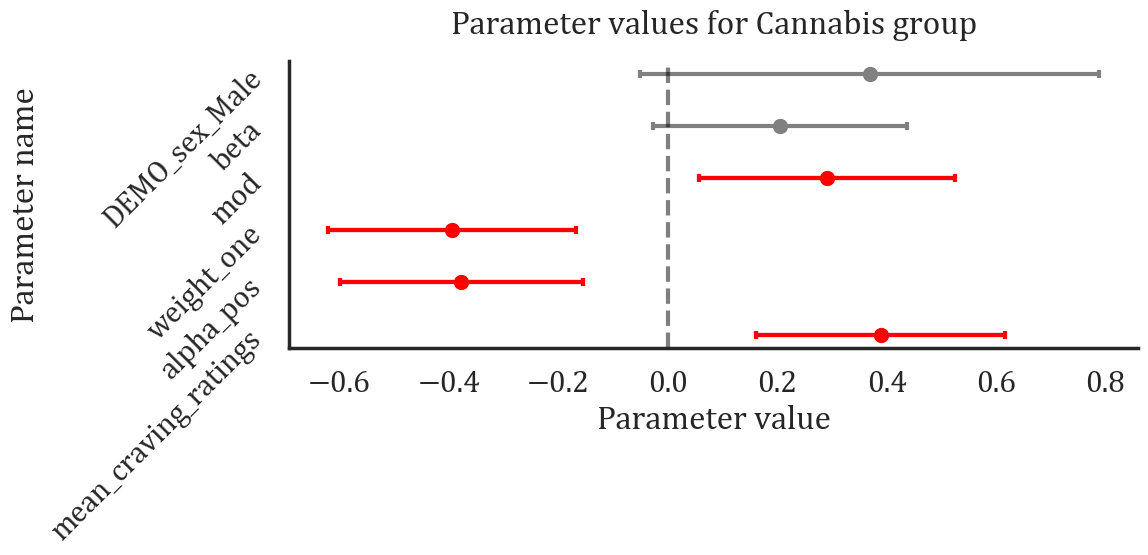

In [61]:
cannabis_glm_params_df = generate_param_estimates_df(cannabis_sm_model_dict[cannabis_perf_df.iloc[0]['Model']], 'Cannabis')
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plot_from_df(glm_param_df=cannabis_glm_params_df, ax=ax, group='Cannabis')
plt.tight_layout()
# cannabis_glm_params_df

/var/folders/p4/n3rrj_kd3n76hx_5y5q4qvfh0000gn/T/ipykernel_22060/3465972023.py:272: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(glm_param_df['Predictor'], rotation=45)


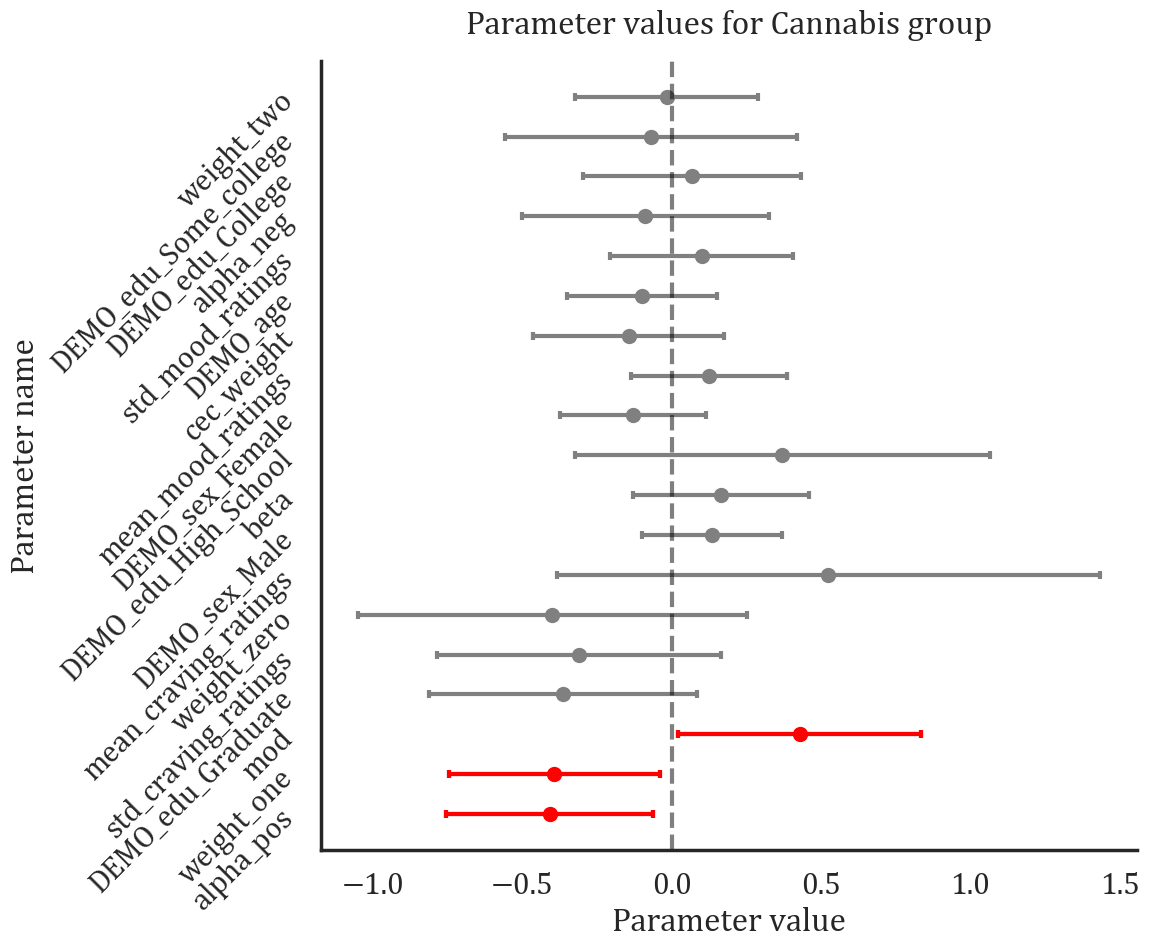

In [62]:
cannabis_glm_params_df_unfiltered = generate_param_estimates_df(cannabis_sm_model_dict['combined_LRBias_JEC'], 'Cannabis')
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plot_from_df(glm_param_df=cannabis_glm_params_df_unfiltered, ax=ax, group='Cannabis')
plt.tight_layout()
# cannabis_glm_params_df_unfiltered

### Binge-eating modular

In [63]:
binge_sm_model_dict = {}
binge_bmb_model_dict = {}
for typ in ['comp', 'nonmodel', 'combined']:
    binge_sm_model_dict, binge_bmb_model_dict, binge_reg_params = run_group_regression(
        mdf=master_dfs['binge'],
        group='binge',
        model_names=['LRBias_JEC'],
        dependent_var='EDEQ_Binge',
        typ=typ,
        block='other',
        sm_model_dict=binge_sm_model_dict,
        bmb_model_dict=binge_bmb_model_dict,
        bambi_flag=True,
        sig_threshold=0.1
    )

Running regression for binge LRBias_JEC EDEQ_Binge...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, alpha_pos, alpha_neg, beta, weight_zero, weight_one, weight_two, cec_weight, mod, DEMO_age, DEMO_sex_Female, DEMO_sex_Male, DEMO_edu_College, DEMO_edu_Graduate, DEMO_edu_High_School, DEMO_edu_Some_HS, DEMO_edu_Some_college, EDEQ_Binge_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, DEMO_sex_Female, DEMO_sex_Male, DEMO_age, beta, EDEQ_Binge_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


Running regression for binge model_agnostic EDEQ_Binge...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, mean_craving_ratings, std_craving_ratings, mean_mood_ratings, std_mood_ratings, EDEQ_Binge_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Running regression for binge combined_LRBias_JEC EDEQ_Binge...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, alpha_pos, alpha_neg, beta, weight_zero, weight_one, weight_two, cec_weight, mod, DEMO_age, DEMO_sex_Female, DEMO_sex_Male, DEMO_edu_College, DEMO_edu_Graduate, DEMO_edu_High_School, DEMO_edu_Some_HS, DEMO_edu_Some_college, mean_craving_ratings, std_craving_ratings, mean_mood_ratings, std_mood_ratings, EDEQ_Binge_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, DEMO_edu_Some_HS, mean_mood_ratings, DEMO_sex_Male, DEMO_age, beta, EDEQ_Binge_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Model        R2    R2_adj         AIC         BIC
0  combined_LRBias_JEC_filtered  0.255796  0.194796  182.343274  195.571430
1           LRBias_JEC_filtered  0.181196  0.142205  184.743783  193.562553
2                model_agnostic  0.029239 -0.033391  198.149544  209.173007
3                    LRBias_JEC  0.277903  0.083492  198.322855  231.393244
4           combined_LRBias_JEC  0.342844  0.096411  200.008864  241.898023

rank   elpd_waic    p_waic  elpd_diff    weight        se  \
Joint-R        0  -92.520005  6.434451   0.000000  0.754985  4.701161   
Comp-R         1  -93.660826  4.978732   1.140821  0.245015  5.213687   
Agnostic-R     2 -100.395533  5.865171   7.875527  0.000000  4.974920   

                 dse  warning scale  
Joint-R     0.000000     True   log  
Comp-R      2.138520     True   log  
Agnostic-R  3.351242     True   log

predicted ~ true * model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, true, model, true:model, predicted_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              predicted   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     13.18
Date:                Thu, 01 Jun 2023   Prob (F-statistic):           1.45e-07
Time:                        12:16:31   Log-Likelihood:                -42.439
No. Observations:                 134   AIC:                             92.88
Df Residuals:                     130   BIC:                             104.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0042      0.041     -0.102      0.919      -0.086       0.077
true           0.0285      0.041      0.692      0.490      -0.053       0.110
model          0.0032      0.058      0.056      0.956      -0.112       0.119
true:model     0.2289      0.058      3.930      0.000       0.114       0.344
==============================================================================
Omnibus:                       31.672   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              149.561
Skew:                           0.658   Prob(JB):                     3.34e-33
Kurtosis:                       8.005   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

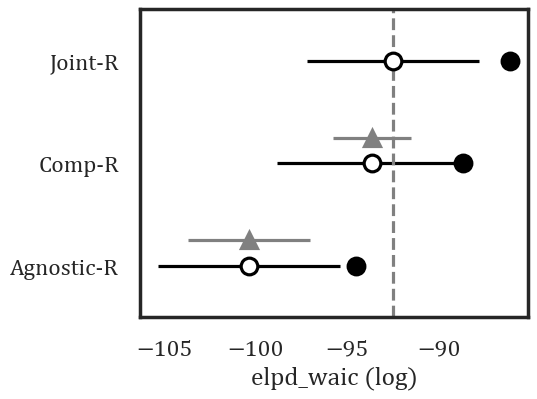

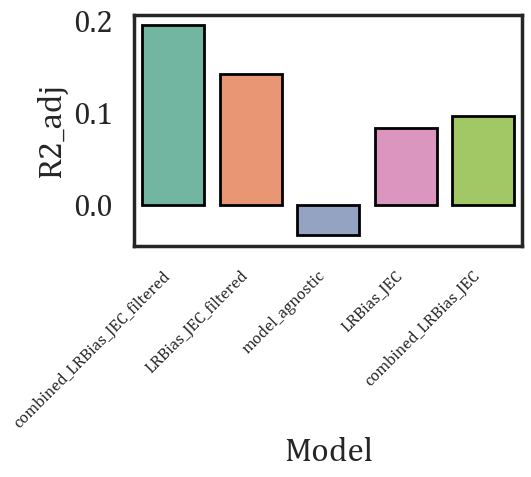

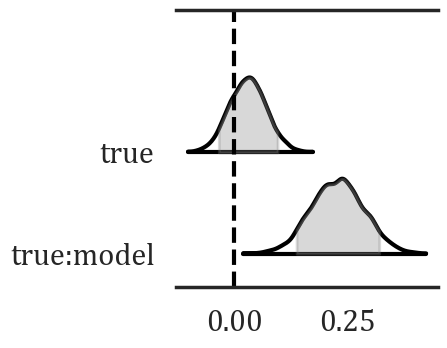

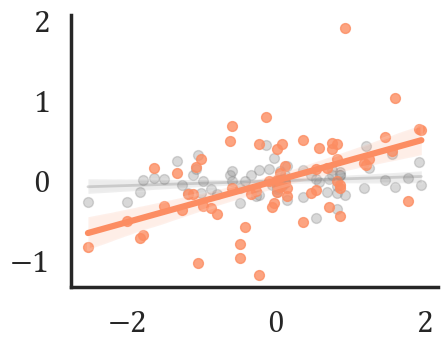

In [64]:
binge_perf_df = performance_comp(binge_sm_model_dict, binge_bmb_model_dict, bambi_flag=True)
plot_r2_adj(binge_perf_df)
plot_sig_improvement(binge_bmb_model_dict, binge_reg_params, binge_perf_df)
plot_sig_improvement2(binge_bmb_model_dict, binge_reg_params, binge_perf_df)

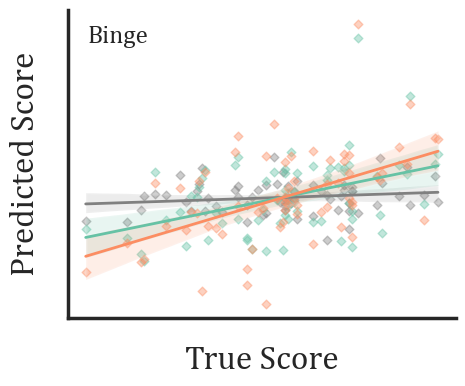

In [65]:
plot_posterior_predictive(binge_bmb_model_dict, binge_perf_df, binge_reg_params, 'Binge')

In [66]:
binge_sm_model_dict[binge_perf_df.iloc[0]['Model']].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             EDEQ_Binge   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     4.193
Date:                Thu, 01 Jun 2023   Prob (F-statistic):            0.00243
Time:                        12:16:31   Log-Likelihood:                -85.172
No. Observations:                  67   AIC:                             182.3
Df Residuals:                      61   BIC:                             195.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1964      0.138      1.421      0.161      -0.080       0.473
DEMO_edu_Some_HS     -1.7666      0.977     -1.808      0.075      -3.720       0.187
mean_mood_ratings    -0.2260      0.114     -1.979      0.052      -0.454       0.002
DEMO_sex_Male        -0.4747      0.234     -2.027      0.047      -0.943      -0.006
DEMO_age              0.2738      0.113      2.428      0.018       0.048       0.499
beta                  0.3482      0.116      3.002      0.004       0.116       0.580
==============================================================================
Omnibus:                        2.644   Durbin-Watson:                   1.271
Prob(Omnibus):                  0.267   Jarque-Bera (JB):                1.824
Skew:                          -0.199   Prob(JB):                        0.402
Kurtosis:                       2.296   Cond. No.                         9.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
binge_sm_model_dict['combined_LRBias_JEC'].summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
=====================================================================
Model:                OLS               Adj. R-squared:      0.096   
Dependent Variable:   EDEQ_Binge        AIC:                 200.0089
Date:                 2023-06-01 12:16  BIC:                 241.8980
No. Observations:     67                Log-Likelihood:      -81.004 
Df Model:             18                F-statistic:         1.391   
Df Residuals:         48                Prob (F-statistic):  0.180   
R-squared:            0.343             Scale:               0.91728 
---------------------------------------------------------------------
                       Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------
Intercept             -0.2550   0.1345 -1.8969 0.0639 -0.5254  0.0153
alpha_pos             -0.0543   0.2205 -0.2460 0.8067 -0.4976  0.3891
alpha_neg              0.0574   0.2729  0.2105 0.8342 -0.4912  0.6060
beta                   0.3109   0.1974  1.5748 0.1219 -0.0861  0.7079
weight_zero           -0.1777   0.4006 -0.4435 0.6594 -0.9832  0.6278
weight_one            -0.1504   0.1687 -0.8913 0.3772 -0.4897  0.1889
weight_two             0.1141   0.1735  0.6575 0.5140 -0.2348  0.4629
cec_weight             0.0322   0.1417  0.2276 0.8209 -0.2526  0.3171
mod                   -0.1766   0.2879 -0.6135 0.5424 -0.7555  0.4022
DEMO_age               0.3355   0.1388  2.4169 0.0195  0.0564  0.6146
DEMO_sex_Female        0.0737   0.1542  0.4783 0.6346 -0.2362  0.3837
DEMO_sex_Male         -0.3288   0.1613 -2.0383 0.0471 -0.6531 -0.0045
DEMO_edu_College       0.3322   0.2858  1.1621 0.2510 -0.2426  0.9069
DEMO_edu_Graduate      0.6149   0.3507  1.7535 0.0859 -0.0902  1.3201
DEMO_edu_High_School   0.0444   0.2999  0.1479 0.8830 -0.5586  0.6473
DEMO_edu_Some_HS      -1.7193   0.8770 -1.9604 0.0558 -3.4825  0.0440
DEMO_edu_Some_college  0.4727   0.2835  1.6675 0.1019 -0.0973  1.0427
mean_craving_ratings   0.4080   0.4641  0.8791 0.3837 -0.5252  1.3412
std_craving_ratings    0.0305   0.2210  0.1382 0.8907 -0.4138  0.4749
mean_mood_ratings     -0.3142   0.1652 -1.9014 0.0633 -0.6464  0.0181
std_mood_ratings      -0.1942   0.1698 -1.1434 0.2585 -0.5356  0.1473
---------------------------------------------------------------------
Omnibus:           0.412      Durbin-Watson:        1.260            
Prob(Omnibus):     0.814      Jarque-Bera (JB):     0.576            
Skew:              -0.127     Prob(JB):             0.750            
Kurtosis:          2.623      Condition No.:        46627902734293944
=====================================================================
* The condition number is large (5e+16). This might indicate
strong multicollinearity or other numerical problems.
"""

/var/folders/p4/n3rrj_kd3n76hx_5y5q4qvfh0000gn/T/ipykernel_22060/3465972023.py:272: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(glm_param_df['Predictor'], rotation=45)


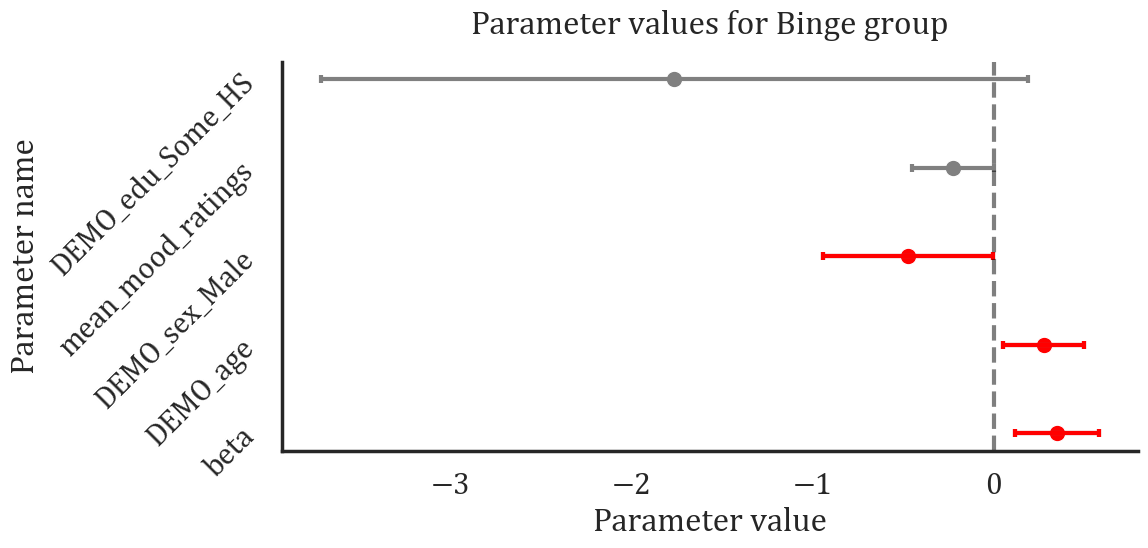

In [68]:
binge_glm_params_df = generate_param_estimates_df(binge_sm_model_dict[binge_perf_df.iloc[0]['Model']], 'Binge')
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plot_from_df(glm_param_df=binge_glm_params_df, ax=ax, group='Binge')
plt.tight_layout()
# binge_glm_params_df

/var/folders/p4/n3rrj_kd3n76hx_5y5q4qvfh0000gn/T/ipykernel_22060/3465972023.py:272: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(glm_param_df['Predictor'], rotation=45)


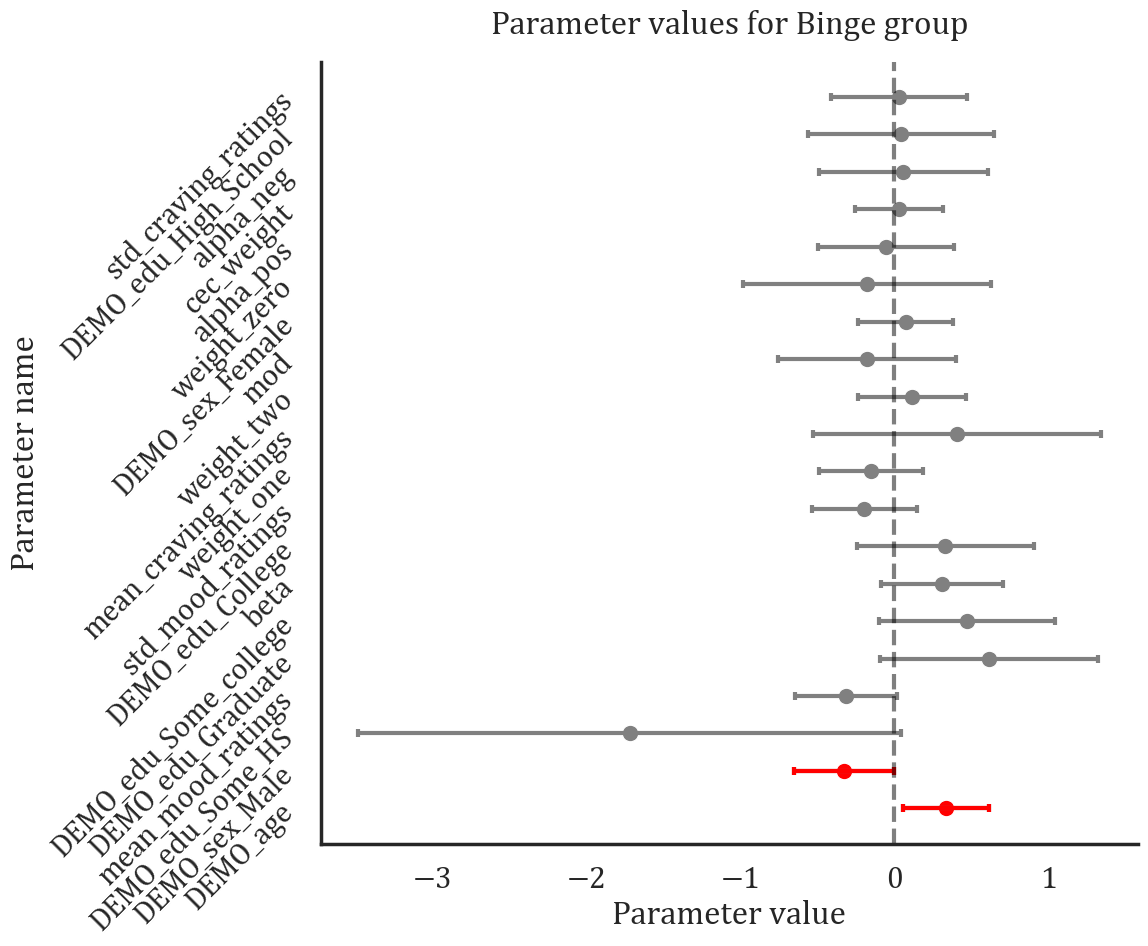

In [69]:
binge_glm_params_df_unfiltered = generate_param_estimates_df(binge_sm_model_dict['combined_LRBias_JEC'], 'Binge')
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plot_from_df(glm_param_df=binge_glm_params_df_unfiltered, ax=ax, group='Binge')
plt.tight_layout()
# binge_glm_params_df_unfiltered

## Best models across groups

In [70]:
# Combine the parameter estimates from all models
glm_params_df = pd.concat([
    alc_glm_params_df,
    cannabis_glm_params_df,
    binge_glm_params_df,
], axis=0).reset_index(drop=True)

# Combine the unfiltered estimates from all models
glm_params_df_unfiltered = pd.concat([
    alc_glm_params_df_unfiltered,
    cannabis_glm_params_df_unfiltered,
    binge_glm_params_df_unfiltered,
], axis=0).reset_index(drop=True)

/var/folders/p4/n3rrj_kd3n76hx_5y5q4qvfh0000gn/T/ipykernel_22060/447167772.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(glm_params_df['Predictor'])


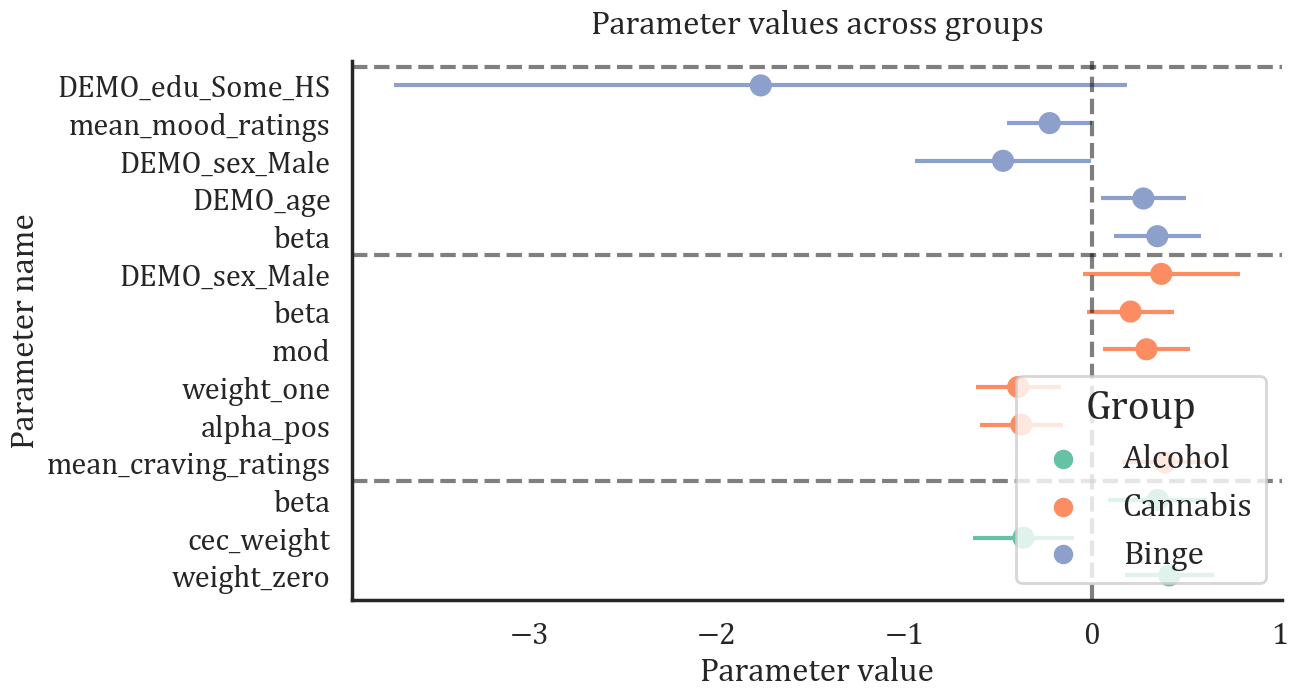

In [71]:
# Plot the parameter estimates from all models on the same plot
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.errorbar(
    x=glm_params_df['mean'],
    y=glm_params_df.index,
    xerr=glm_params_df['ci'],
    elinewidth=3, 
    # capsize=3, 
    capthick=3, fmt='none',
    ecolor=glm_params_df['Model'].map({
        'Alcohol': sns.color_palette('Set2')[0], 
        'Cannabis': sns.color_palette('Set2')[1], 
        'Binge': sns.color_palette('Set2')[2],
    })
)
sns.scatterplot(
    x=glm_params_df['mean'],
    y=glm_params_df.index,
    hue=glm_params_df['Model'],
    palette='Set2',
    ax=ax,
    s=300
)
ax.set_xlabel('Parameter value')
ax.set_ylabel('Parameter name')
ax.set_title('Parameter values across groups', pad=20)
ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
# Add y-axis labels with parameter names
ax.set_yticklabels(glm_params_df['Predictor'])
ax.set_yticks(glm_params_df.index)
# Add dividing lines between groups
ax.axhline(y=alc_glm_params_df.shape[0] - 0.5, color='black', linestyle='--', alpha=0.5)
ax.axhline(y=alc_glm_params_df.shape[0] + cannabis_glm_params_df.shape[0] - 0.5, color='black', linestyle='--', alpha=0.5)
ax.axhline(y=alc_glm_params_df.shape[0] + cannabis_glm_params_df.shape[0] + binge_glm_params_df.shape[0] - 0.5, color='black', linestyle='--', alpha=0.5)
# Add legend to bottom right
ax.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0), ncol=1, frameon=True, title='Group', title_fontsize=30, fontsize=24)
sns.despine()


/var/folders/p4/n3rrj_kd3n76hx_5y5q4qvfh0000gn/T/ipykernel_22060/1020266940.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(glm_params_df['Predictor'], rotation=45)


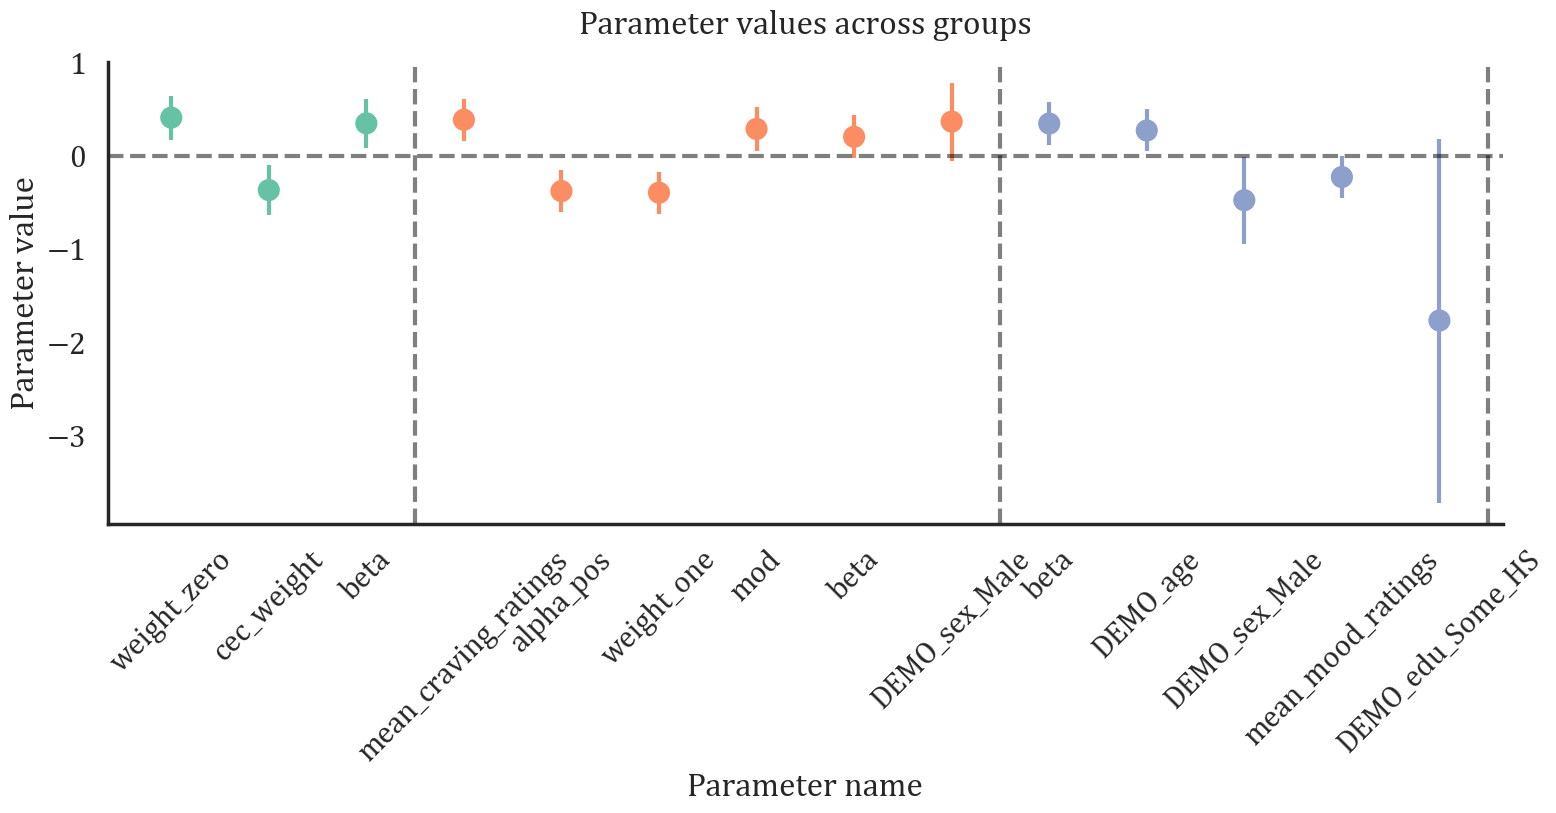

In [72]:
# Plot the parameter estimates from all models on the same plot
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
ax.errorbar(
    y=glm_params_df['mean'],
    x=glm_params_df.index,
    yerr=glm_params_df['ci'],
    elinewidth=3, 
    # capsize=3, 
    capthick=3, fmt='none',
    ecolor=glm_params_df['Model'].map({
        'Alcohol': sns.color_palette('Set2')[0], 
        'Cannabis': sns.color_palette('Set2')[1], 
        'Binge': sns.color_palette('Set2')[2],
    })
)
sns.scatterplot(
    y=glm_params_df['mean'],
    x=glm_params_df.index,
    hue=glm_params_df['Model'],
    palette='Set2',
    ax=ax,
    s=300
)
ax.set_ylabel('Parameter value')
ax.set_xlabel('Parameter name')
ax.set_title('Parameter values across groups', pad=20)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
# Add y-axis labels with parameter names
ax.set_xticklabels(glm_params_df['Predictor'], rotation=45)
ax.set_xticks(glm_params_df.index)
# Add dividing lines between groups
ax.axvline(x=alc_glm_params_df.shape[0] - 0.5, color='black', linestyle='--', alpha=0.5)
ax.axvline(x=alc_glm_params_df.shape[0] + cannabis_glm_params_df.shape[0] - 0.5, color='black', linestyle='--', alpha=0.5)
ax.axvline(x=alc_glm_params_df.shape[0] + cannabis_glm_params_df.shape[0] + binge_glm_params_df.shape[0] - 0.5, color='black', linestyle='--', alpha=0.5)
# Add legend to bottom right
# ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0), ncol=1, frameon=True, title='Group', title_fontsize=30, fontsize=24)
# Remove legend
ax.get_legend().remove()
sns.despine()


/var/folders/p4/n3rrj_kd3n76hx_5y5q4qvfh0000gn/T/ipykernel_22060/2809357591.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(subset_df['Predictor'], rotation=45, ha='right', fontsize=12)
/var/folders/p4/n3rrj_kd3n76hx_5y5q4qvfh0000gn/T/ipykernel_22060/2809357591.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(subset_df['Predictor'], rotation=45, ha='right', fontsize=12)
/var/folders/p4/n3rrj_kd3n76hx_5y5q4qvfh0000gn/T/ipykernel_22060/2809357591.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(subset_df['Predictor'], rotation=45, ha='right', fontsize=12)


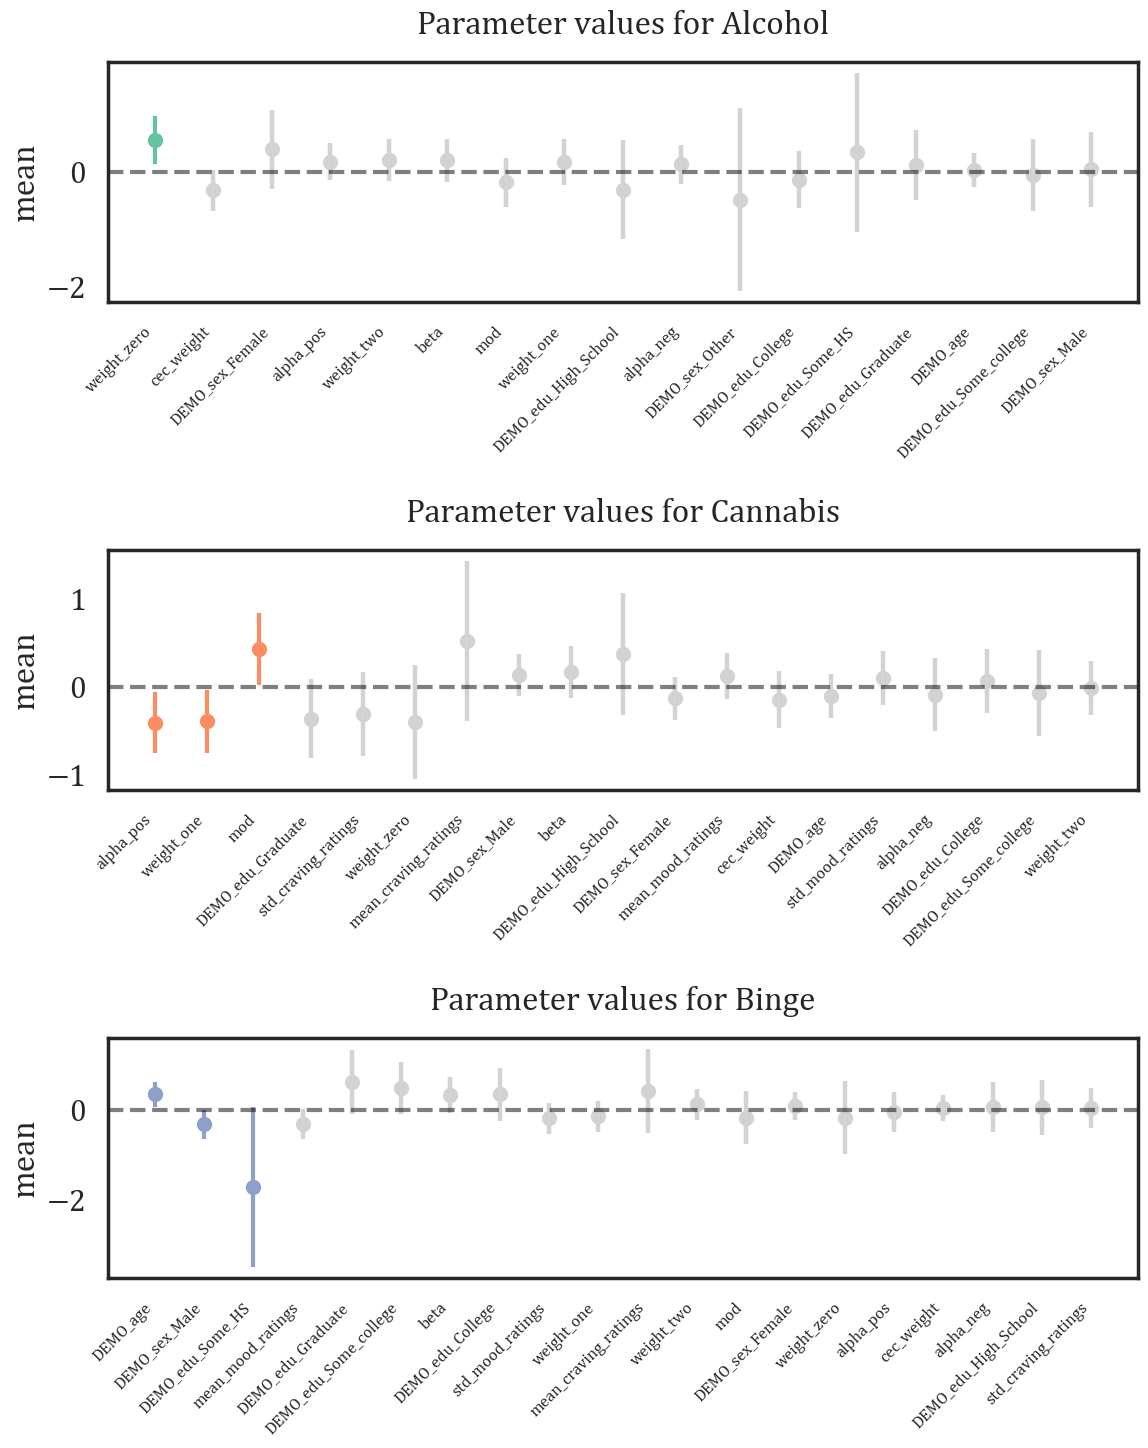

In [73]:
# Plot the parameter estimates from all models on 4 different subplots
fig, ax = plt.subplots(3, 1, figsize=(12, 15))
ax = ax.flatten()
for i, group in enumerate(['Alcohol', 'Cannabis', 'Binge']):
    subset_df = glm_params_df_unfiltered[glm_params_df_unfiltered['Model'] == group].reset_index(drop=True)
    sns.scatterplot(
        y=subset_df['mean'],
        x=subset_df.index,
        ax=ax[i],
        color=sns.color_palette('Set2')[i],    
    )
    ax[i].errorbar(
        y=subset_df['mean'],
        x=subset_df.index,
        yerr=subset_df['ci'],
        elinewidth=3, 
        # capsize=3, 
        capthick=3, fmt='none',
        ecolor=subset_df['Model'].map({
            'Alcohol': sns.color_palette('Set2')[0], 
            'Cannabis': sns.color_palette('Set2')[1], 
            'Binge': sns.color_palette('Set2')[2],
            'Social': sns.color_palette('Set2')[3]
        })
    )
    subset_df_nonsignificant = subset_df[subset_df['pval'] > 0.06]
    sns.scatterplot(
        y=subset_df_nonsignificant['mean'],
        x=subset_df_nonsignificant.index,
        ax=ax[i],
        color='lightgrey',    
    )
    ax[i].errorbar(
        y=subset_df_nonsignificant['mean'],
        x=subset_df_nonsignificant.index,
        yerr=subset_df_nonsignificant['ci'],
        elinewidth=3, 
        # capsize=3, 
        capthick=3, fmt='none',
        ecolor='lightgrey'
    )
    ax[i].set_xticklabels(subset_df['Predictor'], rotation=45, ha='right', fontsize=12)
    ax[i].set_xticks(subset_df.index)
    ax[i].set_title(f'Parameter values for {group}', pad=20)
    ax[i].axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()

## Non-modular (archive)

### Alcohol

In [ ]:
dependent_var = 'ASSIST_Alcohol'

full_demo_list = ['DEMO_age', 'DEMO_sex', 'DEMO_edu']

full_param_list = [
    'alpha', 'alpha_pos', 'alpha_neg',
    'beta',
    'weight_zero', 'weight_one', 'weight_two',
    'weight_three', 'weight_four', 'weight_five',
    'weight_six', 'cec_weight', 'mod',
    'bias', 'eps',
]

full_nonmodel_param_list = ['mean_craving_ratings', 'std_craving_ratings', 'mean_mood_ratings', 'std_mood_ratings']

family = 'gaussian'

#### Standard statsmodels/bambi GLM 

In [ ]:
# Set bambi flag on or off
bambi_flag = True

# Set significance threshold for stepwise regression
sig_threshold = 0.05

# Initialize empty dicts
statsmodels_alc_model_dict = {}
bambi_alc_model_dict = {}

In [ ]:
# Computational model parameters GLM
for i, model_name in enumerate(sorted(best_models['alcohol'])):
    # Subset of data for model in the addictive cue block
    _model_df = master_df.loc[
        (master_df['Group']=='alcohol') &
        (master_df['Model']==model_name) & 
        (master_df['Block']=='other')
    ].dropna(how='all', axis=1).dropna(how='any', axis=0, subset=dependent_var).reset_index(drop=True)

    # Normalize the data
    model_param_names = []
    for param in (full_param_list+full_demo_list):
        if param in _model_df.columns:
            model_param_names.append(param)
    _columns_to_use = [dependent_var] + model_param_names
    _numerics = _model_df[_columns_to_use].select_dtypes(include=[np.number])
    _nonnumerics = _model_df[_columns_to_use].select_dtypes(exclude=[np.number])
    scaler = StandardScaler()
    _normed_model_df = pd.concat([
        pd.DataFrame(
            scaler.fit_transform(_numerics), 
            columns=_numerics.columns
        ),
        _nonnumerics
    ], axis=1)

    # Add dummy variables for categorical demographics
    normed_model_df = pd.get_dummies(_normed_model_df, columns=['DEMO_sex', 'DEMO_edu'])
    normed_model_df.columns = normed_model_df.columns.str.replace(' ', '_')
    
    # Build the model equation
    equation = dependent_var + ' ~ '
    model_param_names = []
    for param in full_param_list:
        if param in normed_model_df.columns:
            equation += param + ' + '
            model_param_names.append(param)
    for demo in full_demo_list:
        for col in normed_model_df.columns:
            if demo in col:
                equation += col + ' + '
                model_param_names.append(col)
    equation = equation[:-3]
    print(f'Number {i}:\t{model_name}\t{equation}')

    # Fit the model with statsmodels
    sm_results = smf.ols(formula=equation, data=normed_model_df).fit()
    display(sm_results.summary())
    statsmodels_alc_model_dict[model_name] = sm_results

    if bambi_flag:
        # Fit the model with bambi
        bmb_model = bmb.Model(equation, normed_model_df, family=family)
        bmb_results = bmb_model.fit()
        ppc = bmb_model.predict(bmb_results, kind='pps')
        bambi_alc_model_dict[model_name] = bmb_results
    
    # Filtering of the model (remove predictors with significance < 0.05)
    filtered_equation = equation
    least_sig = 1
    while least_sig > sig_threshold:
        _sm_results = smf.ols(formula=filtered_equation, data=normed_model_df).fit()

        x = pd.read_html(_sm_results.summary().tables[1].as_html())[0]
        y = x.iloc[0].astype(str)
        y[0] = 'Predictor'
        x.columns = y
        x = x.iloc[1:]
        x = pd.concat([
            x['Predictor'],
            x[[elem for elem in x.columns if 'Predictor' not in elem]].astype(str).astype(float)
        ], axis=1)
        x = x[x['Predictor']!='Intercept']
        least_sig = x.sort_values(by='P>|t|', ascending=False)['P>|t|'].values[0]
        predictors = [elem for elem in x.sort_values(by='P>|t|', ascending=False)['Predictor'].values.astype(str) if 'Intercept' not in elem]
        if least_sig > sig_threshold:
            filtered_equation = dependent_var + ' ~ ' + ' + '.join(predictors[1:])
        else:
            filtered_equation = dependent_var + ' ~ ' + ' + '.join(predictors)
    print(f'Number {i}:\t{model_name}\t{filtered_equation}')

    # Fit the filtered model with statsmodels
    filtered_sm_results = smf.ols(formula=filtered_equation, data=normed_model_df).fit()
    display(filtered_sm_results.summary())
    statsmodels_alc_model_dict[f'{model_name}_filtered'] = filtered_sm_results

    if bambi_flag:
        # Fit the filtered model with bambi
        filtered_bmb_model = bmb.Model(filtered_equation, normed_model_df, family=family)
        filtered_bmb_results = filtered_bmb_model.fit()
        filtered_ppc = filtered_bmb_model.predict(filtered_bmb_results, kind='pps')
        bambi_alc_model_dict[f'{model_name}_filtered'] = filtered_bmb_results



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [ ]:
# Non-model parameter GLM
model_name = 'Non-model parameters'

# Subset of data for model in the addictive cue block
_model_df = master_df.loc[
    (master_df['Group']=='alcohol') &
    (master_df['Model']=='RWCEC') & 
    (master_df['Block']=='other')
].dropna(how='all', axis=1).dropna(how='any', axis=0, subset=dependent_var).reset_index(drop=True)

# Normalize the data
model_param_names = []
for param in (full_nonmodel_param_list+full_demo_list):
    if param in _model_df.columns:
        model_param_names.append(param)
_columns_to_use = [dependent_var] + model_param_names
_numerics = _model_df[_columns_to_use].select_dtypes(include=[np.number])
_nonnumerics = _model_df[_columns_to_use].select_dtypes(exclude=[np.number])
scaler = StandardScaler()
_normed_model_df = pd.concat([
    pd.DataFrame(
        scaler.fit_transform(_numerics), 
        columns=_numerics.columns
    ),
    _nonnumerics
], axis=1)

# Add dummy variables for categorical demographics
normed_model_df = pd.get_dummies(_normed_model_df, columns=['DEMO_sex', 'DEMO_edu'])
normed_model_df.columns = normed_model_df.columns.str.replace(' ', '_')

# Build the model equation
equation = dependent_var + ' ~ '
model_param_names = []
for param in full_nonmodel_param_list:
    if param in normed_model_df.columns:
        equation += param + ' + '
        model_param_names.append(param)
for demo in full_demo_list:
    for col in normed_model_df.columns:
        if demo in col:
            equation += col + ' + '
            model_param_names.append(col)
equation = equation[:-3]
print(f'Number {i}:\t{model_name}\t{equation}')

# Fit the model with statsmodels
sm_results = smf.ols(formula=equation, data=normed_model_df).fit()
display(sm_results.summary())
statsmodels_alc_model_dict[model_name] = sm_results

if bambi_flag:
    # Fit the model with bambi
    bmb_model = bmb.Model(equation, normed_model_df, family=family)
    bmb_results = bmb_model.fit()
    ppc = bmb_model.predict(bmb_results, kind='pps')
    bambi_alc_model_dict[model_name] = bmb_results

# Filtering of the model (remove predictors with significance < 0.05)
filtered_equation = equation
least_sig = 1
while least_sig > sig_threshold:
    _sm_results = smf.ols(formula=filtered_equation, data=normed_model_df).fit()

    x = pd.read_html(_sm_results.summary().tables[1].as_html())[0]
    y = x.iloc[0].astype(str)
    y[0] = 'Predictor'
    x.columns = y
    x = x.iloc[1:]
    x = pd.concat([
        x['Predictor'],
        x[[elem for elem in x.columns if 'Predictor' not in elem]].astype(str).astype(float)
    ], axis=1)
    x = x[x['Predictor']!='Intercept']
    least_sig = x.sort_values(by='P>|t|', ascending=False)['P>|t|'].values[0]
    predictors = [elem for elem in x.sort_values(by='P>|t|', ascending=False)['Predictor'].values.astype(str) if 'Intercept' not in elem]
    if least_sig > sig_threshold:
        filtered_equation = dependent_var + ' ~ ' + ' + '.join(predictors[1:])
    else:
        filtered_equation = dependent_var + ' ~ ' + ' + '.join(predictors)
print(f'Number {i}:\t{model_name}\t{filtered_equation}')

# Fit the filtered model with statsmodels
filtered_sm_results = smf.ols(formula=filtered_equation, data=normed_model_df).fit()
display(filtered_sm_results.summary())
statsmodels_alc_model_dict[f'{model_name}_filtered'] = filtered_sm_results

if bambi_flag:
    # Fit the filtered model with bambi
    filtered_bmb_model = bmb.Model(filtered_equation, normed_model_df, family=family)
    filtered_bmb_results = filtered_bmb_model.fit()
    filtered_ppc = filtered_bmb_model.predict(filtered_bmb_results, kind='pps')
    bambi_alc_model_dict[f'{model_name}_filtered'] = filtered_bmb_results



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [ ]:
performance_df = pd.DataFrame(columns=['Model', 'R2', 'R2_adj', 'AIC', 'BIC'])
for model in statsmodels_alc_model_dict:
    sm_results = statsmodels_alc_model_dict[model]
    performance_df = pd.concat([
        performance_df,
        pd.DataFrame({
            'Model': [model],
            'R2': [sm_results.rsquared],
            'R2_adj': [sm_results.rsquared_adj],
            'AIC': [sm_results.aic],
            'BIC': [sm_results.bic]
        })
    ], axis=0)
performance_df = performance_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
display(performance_df)

Model        R2    R2_adj         AIC         BIC
0      A_RWSep_1stepSep_filtered  0.302526  0.251800  158.655259  169.126982
1  Non-model parameters_filtered  0.181426  0.152704  164.261118  170.544152
2           Non-model parameters  0.291073  0.128610  173.632466  198.764601
3               A_RWSep_1stepSep  0.410038  0.171244  174.610820  212.309022

rank  elpd_waic     p_waic  elpd_diff  \
A_RWSep_1stepSep_filtered         0 -80.247187   4.951947   0.000000   
Non-model parameters_filtered     1 -82.861687   3.238822   2.614500   
Non-model parameters              2 -88.191834  10.176584   7.944647   
A_RWSep_1stepSep                  3 -88.925061  13.569747   8.677873   

                                     weight        se       dse  warning scale  
A_RWSep_1stepSep_filtered      7.119969e-01  5.987387  0.000000     True   log  
Non-model parameters_filtered  2.880031e-01  4.650009  4.116017    False   log  
Non-model parameters           0.000000e+00  5.401670  4.083219     True   log  
A_RWSep_1stepSep               3.031464e-12  5.178642  2.386181     True   log

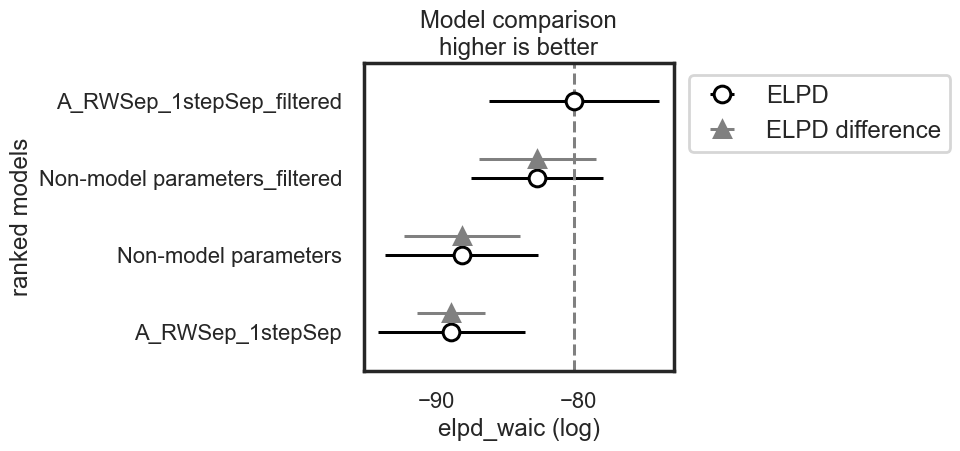

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df_compare = az.compare(bambi_alc_model_dict, ic='waic')
    display(df_compare)
    az.plot_compare(df_compare, insample_dev=False, plot_ic_diff=True, figsize=(4, 4));

In [ ]:
# Combination of model and non-model parameters GLM
# Only for best performing computational model above (A_RWSep_1stepSep)
best_perf_comp_model = best_models['alcohol'][0]
model_name = 'combined'

# Subset of data for model in the addictive cue block
_model_df = master_df.loc[
    (master_df['Group']=='alcohol') &
    (master_df['Model']==best_perf_comp_model) & 
    (master_df['Block']=='other')
].dropna(how='all', axis=1).dropna(how='any', axis=0, subset=dependent_var).reset_index(drop=True)

# Normalize the data
model_param_names = []
for param in (full_param_list+full_nonmodel_param_list+full_demo_list):
    if param in _model_df.columns:
        model_param_names.append(param)
_columns_to_use = [dependent_var] + model_param_names
_numerics = _model_df[_columns_to_use].select_dtypes(include=[np.number])
_nonnumerics = _model_df[_columns_to_use].select_dtypes(exclude=[np.number])
scaler = StandardScaler()
_normed_model_df = pd.concat([
    pd.DataFrame(
        scaler.fit_transform(_numerics), 
        columns=_numerics.columns
    ),
    _nonnumerics
], axis=1)

# Add dummy variables for categorical demographics
normed_model_df = pd.get_dummies(_normed_model_df, columns=['DEMO_sex', 'DEMO_edu'])
normed_model_df.columns = normed_model_df.columns.str.replace(' ', '_')

# Build the model equation
equation = dependent_var + ' ~ '
model_param_names = []
for param in full_param_list:
    if param in normed_model_df.columns:
        equation += param + ' + '
        model_param_names.append(param)
for param in full_nonmodel_param_list:
    if param in normed_model_df.columns:
        equation += param + ' + '
        model_param_names.append(param)
for demo in full_demo_list:
    for col in normed_model_df.columns:
        if demo in col:
            equation += col + ' + '
            model_param_names.append(col)
    # if demo in model_df.columns:
    #     if demo=='DEMO_age':
    #         equation += demo + ' + '
    #     else:
    #         equation += 'C(' + demo + ') + '
    #     model_param_names.append(demo)
equation = equation[:-3]
print(f'Number {i}:\t{model_name}\t{equation}')

# Fit the model with statsmodels
sm_results = smf.ols(formula=equation, data=normed_model_df).fit()
display(sm_results.summary())
statsmodels_alc_model_dict[model_name] = sm_results

if bambi_flag:
    # Fit the model with bambi
    bmb_model = bmb.Model(equation, normed_model_df, family=family)
    bmb_results = bmb_model.fit()
    ppc = bmb_model.predict(bmb_results, kind='pps')
    bambi_alc_model_dict[model_name] = bmb_results

# Filtering of the model (remove predictors with significance < 0.05)
filtered_equation = equation
least_sig = 1
while least_sig > sig_threshold:
    _sm_results = smf.ols(formula=filtered_equation, data=normed_model_df).fit()

    x = pd.read_html(_sm_results.summary().tables[1].as_html())[0]
    y = x.iloc[0].astype(str)
    y[0] = 'Predictor'
    x.columns = y
    x = x.iloc[1:]
    x = pd.concat([
        x['Predictor'],
        x[[elem for elem in x.columns if 'Predictor' not in elem]].astype(str).astype(float)
    ], axis=1)
    x = x[x['Predictor']!='Intercept']
    least_sig = x.sort_values(by='P>|t|', ascending=False)['P>|t|'].values[0]
    predictors = [elem for elem in x.sort_values(by='P>|t|', ascending=False)['Predictor'].values.astype(str) if 'Intercept' not in elem]
    if least_sig > sig_threshold:
        filtered_equation = dependent_var + ' ~ ' + ' + '.join(predictors[1:])
    else:
        filtered_equation = dependent_var + ' ~ ' + ' + '.join(predictors)
print(f'Number {i}:\t{model_name}\t{filtered_equation}')

# Fit the filtered model with statsmodels
filtered_sm_results = smf.ols(formula=filtered_equation, data=normed_model_df).fit()
display(filtered_sm_results.summary())
statsmodels_alc_model_dict[f'{model_name}_filtered'] = filtered_sm_results

if bambi_flag:
    # Fit the filtered model with bambi
    filtered_bmb_model = bmb.Model(filtered_equation, normed_model_df, family=family)
    filtered_bmb_results = filtered_bmb_model.fit()
    filtered_ppc = filtered_bmb_model.predict(filtered_bmb_results, kind='pps')
    bambi_alc_model_dict[f'{model_name}_filtered'] = filtered_bmb_results



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [ ]:
performance_df = pd.DataFrame(columns=['Model', 'R2', 'R2_adj', 'AIC', 'BIC'])
for model in statsmodels_alc_model_dict:
    sm_results = statsmodels_alc_model_dict[model]
    performance_df = pd.concat([
        performance_df,
        pd.DataFrame({
            'Model': [model],
            'R2': [sm_results.rsquared],
            'R2_adj': [sm_results.rsquared_adj],
            'AIC': [sm_results.aic],
            'BIC': [sm_results.bic]
        })
    ], axis=0)
performance_df = performance_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
performance_df

Model        R2    R2_adj         AIC         BIC
0              combined_filtered  0.356172  0.309349  153.853161  164.324884
1      A_RWSep_1stepSep_filtered  0.302526  0.251800  158.655259  169.126982
2  Non-model parameters_filtered  0.181426  0.152704  164.261118  170.544152
3           Non-model parameters  0.291073  0.128610  173.632466  198.764601
4               A_RWSep_1stepSep  0.410038  0.171244  174.610820  212.309022
5                       combined  0.473383  0.182358  175.795681  221.871262

In [ ]:
statsmodels_alc_model_dict['combined_filtered'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ASSIST_Alcohol   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     7.607
Date:                Tue, 28 Feb 2023   Prob (F-statistic):           5.95e-05
Time:                        10:48:24   Log-Likelihood:                -71.927
No. Observations:                  60   AIC:                             153.9
Df Residuals:                      55   BIC:                             164.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -2.776e-17      0.108  -2.57e-16      1.000      -0.217       0.217
alpha_neg                0.2707      0.120      2.256      0.028       0.030       0.511
beta                    -0.3692      0.110     -3.342      0.002      -0.591      -0.148
std_mood_ratings        -0.3619      0.110     -3.285      0.002      -0.583      -0.141
mean_craving_ratings     0.3982      0.121      3.296      0.002       0.156       0.640
==============================================================================
Omnibus:                        3.489   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.175   Jarque-Bera (JB):                2.546
Skew:                           0.408   Prob(JB):                        0.280
Kurtosis:                       3.594   Cond. No.                         1.66
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

rank  elpd_waic     p_waic  elpd_diff  \
combined_filtered                 0 -77.856740   5.130614   0.000000   
A_RWSep_1stepSep_filtered         1 -80.247187   4.951947   2.390447   
Non-model parameters_filtered     2 -82.861687   3.238822   5.004947   
Non-model parameters              3 -88.191834  10.176584  10.335094   
A_RWSep_1stepSep                  4 -88.925061  13.569747  11.068321   
combined                          5 -90.296515  16.301947  12.439776   

                                     weight        se       dse  warning scale  
combined_filtered              8.609451e-01  6.310062  0.000000     True   log  
A_RWSep_1stepSep_filtered      3.188033e-13  5.987387  2.307082     True   log  
Non-model parameters_filtered  1.390549e-01  4.650009  3.959174    False   log  
Non-model parameters           2.520075e-13  5.401670  3.776075     True   log  
A_RWSep_1stepSep               4.645623e-14  5.178642  3.397958     True   log  
combined                       0.000000e+00  5.340314  2.678384     True   log

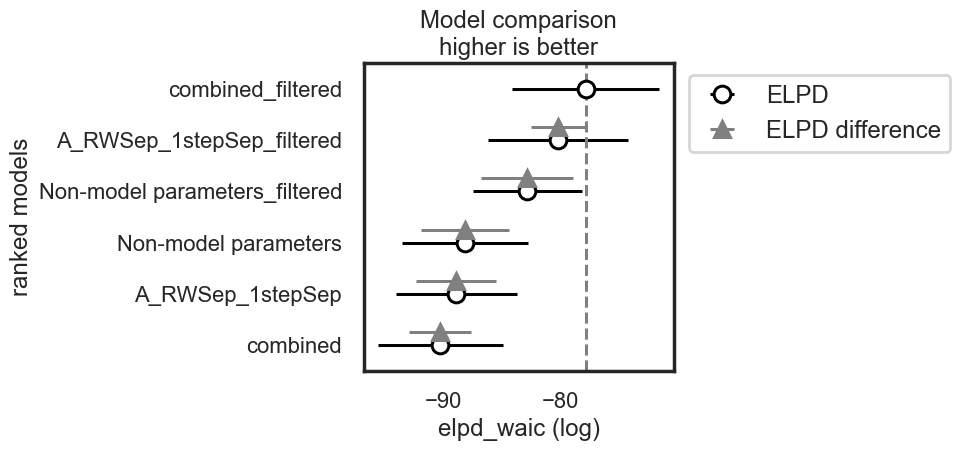

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df_compare = az.compare(bambi_alc_model_dict, ic='waic')
    display(df_compare)
    az.plot_compare(df_compare, insample_dev=False, plot_ic_diff=True, figsize=(4, 4));

Calculate R2 for all regressions

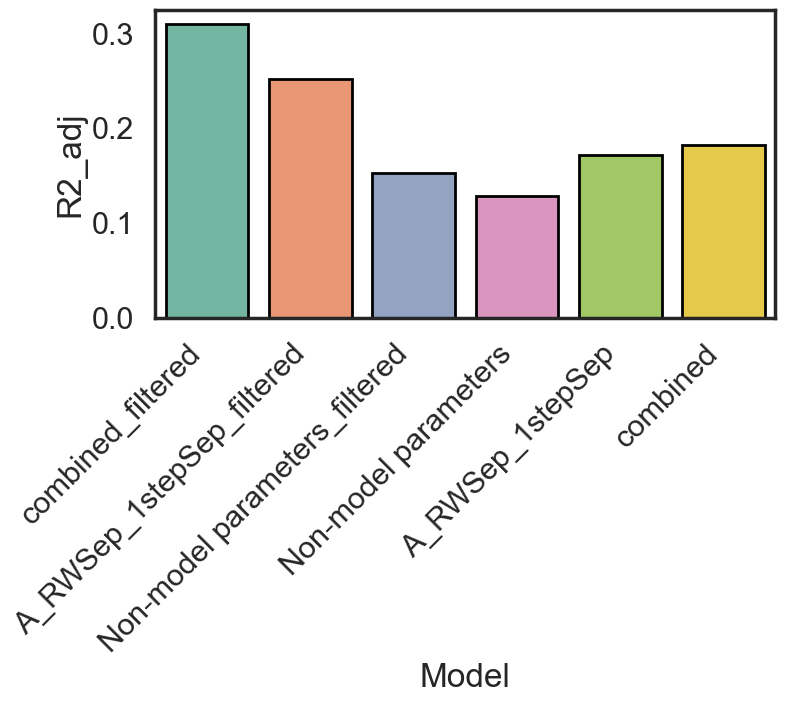

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x='Model', y='R2_adj', data=performance_df, dodge=False, ax=ax, palette='Set2', edgecolor='black', linewidth=2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');

Identify the most predictive variables

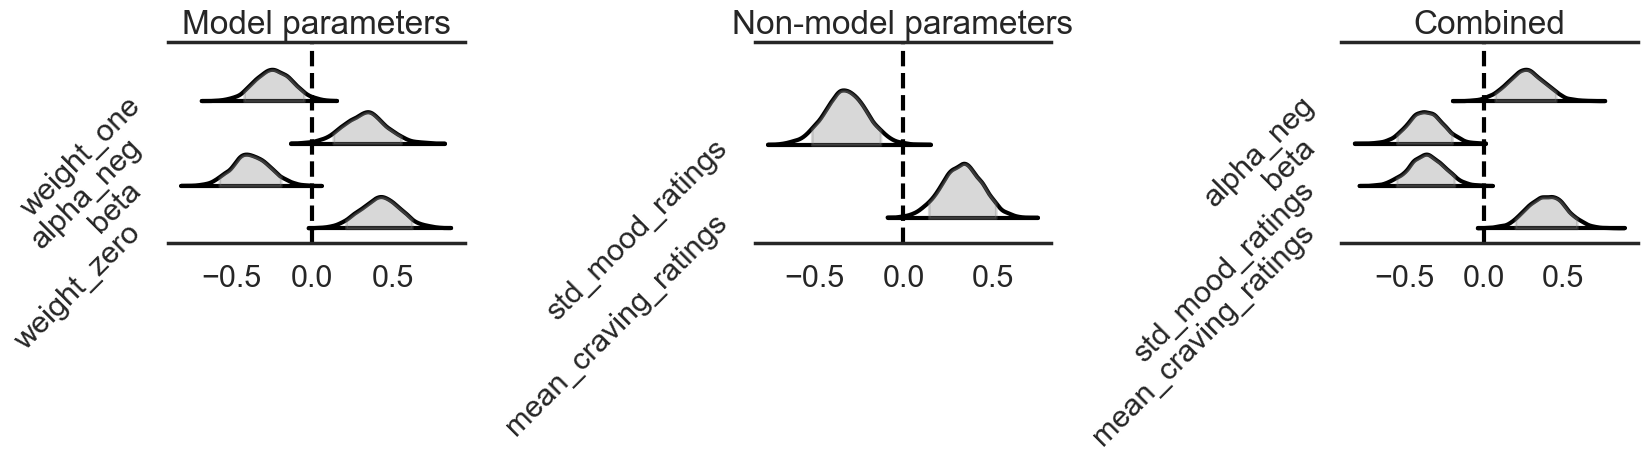

In [ ]:
fig, ax = plt.subplots(figsize=(17, 5), ncols=3, nrows=1)
i_count = -1
for i, model_name in enumerate(bambi_alc_model_dict.keys()):
    if 'filtered' not in model_name:
        continue
    if i>8:
        break
    else:
        i_count += 1
        if 'Non-model parameters' in model_name:
            ax[i_count].set_title('Non-model parameters')
        elif 'combined' in model_name:
            ax[i_count].set_title('Combined')
        else:
            ax[i_count].set_title('Model parameters')
    vars = []
    summary_model_df = az.summary(bambi_alc_model_dict[model_name])
    candidate_vars = np.array([
        elem for elem in az.summary(bambi_alc_model_dict[model_name]).index if elem in (full_param_list + full_demo_list + full_nonmodel_param_list)
    ])
    for var in candidate_vars:
        if np.abs(summary_model_df.loc[var]['hdi_3%'] + summary_model_df.loc[var]['hdi_97%']) > np.abs(summary_model_df.loc[var]['hdi_97%']):
            vars.append(var)
    az.plot_forest(
        bambi_alc_model_dict[model_name], 
        var_names=vars,
        figsize=(5,4), combined=True, 
        kind='ridgeplot', ridgeplot_alpha=0.3, 
        hdi_prob=0.89,
        # ridgeplot_quantiles=[.25, .5, .75],
        ridgeplot_overlap=1, 
        ridgeplot_truncate=False,
        colors='gray',
        ax=ax[i_count],
    )
    # plt.xlim(-15, 15)
    # ax[i_count].set_title(model_name)
    ax[i_count].axvline(0, color='k', linestyle='--')
    ax[i_count].set_yticklabels(ax[i_count].get_yticklabels(), rotation=45, ha='right')
plt.tight_layout()

Visualize the posterior predictive distributions for the best model

Text(0.05, 0.95, 'Non-model parameters')

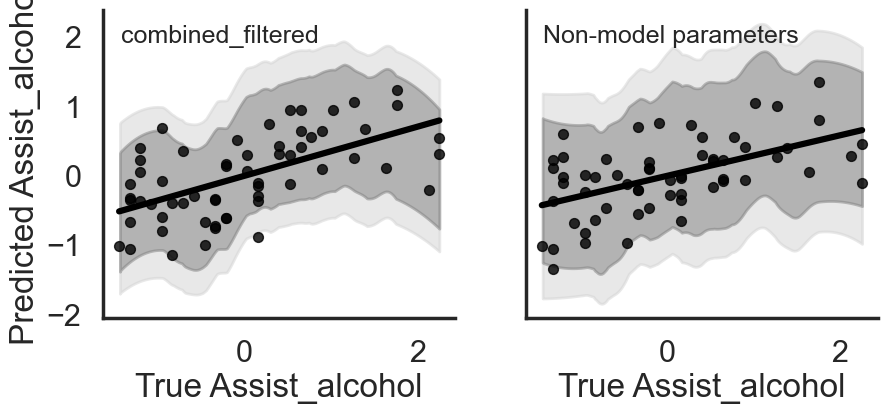

In [ ]:
best_model_name = performance_df.iloc[0]['Model']
best_model_results = bambi_alc_model_dict[best_model_name]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)
az.plot_hdi(
    best_model_results.observed_data[dependent_var].values,
    best_model_results.posterior_predictive[dependent_var].values,
    hdi_prob=0.84, smooth=True, color='lightgray', ax=ax[0]
)
az.plot_hdi(
    best_model_results.observed_data[dependent_var].values,
    best_model_results.posterior_predictive[dependent_var].values,
    hdi_prob=0.68, smooth=True, color='gray', ax=ax[0]
)
sns.regplot(
    x=best_model_results.observed_data[dependent_var].values,
    y=np.vstack(best_model_results.posterior_predictive[dependent_var].values).mean(axis=0),
    color='black', ci=0, ax=ax[0], scatter_kws=dict(s=50)
)
az.plot_hdi(
    best_model_results.observed_data[dependent_var].values,
    bambi_alc_model_dict['Non-model parameters'].posterior_predictive[dependent_var].values,
    hdi_prob=0.84, smooth=True, color='lightgray', ax=ax[1]
)
az.plot_hdi(
    best_model_results.observed_data[dependent_var].values,
    bambi_alc_model_dict['Non-model parameters'].posterior_predictive[dependent_var].values,
    hdi_prob=0.68, smooth=True, color='gray', ax=ax[1]
)
sns.regplot(
    x=best_model_results.observed_data[dependent_var].values,
    y=np.vstack(bambi_alc_model_dict['Non-model parameters'].posterior_predictive[dependent_var].values).mean(axis=0),
    color='black', ci=0, ax=ax[1], scatter_kws=dict(s=50)
)
sns.despine()
ax[0].set_xlabel(f'True {dependent_var.capitalize()}')
ax[0].set_ylabel(f'Predicted {dependent_var.capitalize()}')
ax[1].set_xlabel(f'True {dependent_var.capitalize()}')
ax[0].text(0.05, 0.95, f'{best_model_name}', transform=ax[0].transAxes, va='top', ha='left', fontsize=18)
ax[1].text(0.05, 0.95, 'Non-model parameters', transform=ax[1].transAxes, va='top', ha='left', fontsize=18)

Calculate the significance of improvement in predictions by using computational parameters

In [ ]:
predicted = np.hstack((
    np.vstack(best_model_results.posterior_predictive[dependent_var].values).mean(axis=0),
    np.vstack(bambi_alc_model_dict['Non-model parameters_filtered'].posterior_predictive[dependent_var].values).mean(axis=0)
))
true = np.hstack((
    best_model_results.observed_data[dependent_var].values,
    best_model_results.observed_data[dependent_var].values
))
model_labels = np.hstack((
    # np.repeat(r2_df.loc[0]['Model'], len(sample_model_df)),
    np.repeat(1, len(best_model_results.observed_data[dependent_var].values)),
    # np.repeat('model-free', len(sample_model_df))
    np.repeat(0, len(best_model_results.observed_data[dependent_var].values))
))
alc_predict_df = pd.DataFrame({
    'predicted': predicted,
    'true': true,
    'model': model_labels
})

equation = 'predicted ~ true * model'
print(equation)
alc_pred_model = bmb.Model(equation, alc_predict_df)
alc_results = alc_pred_model.fit()
# ppc_alt = model_alt.predict(results_alt, kind='pps')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


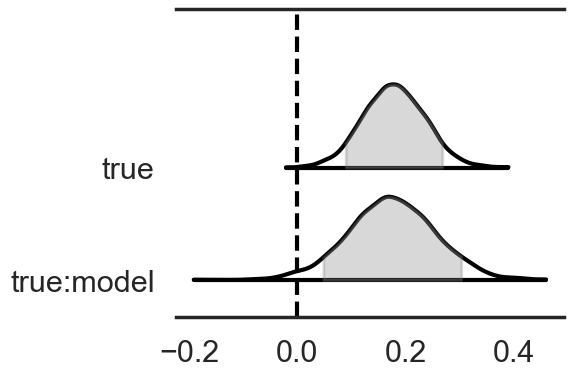

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
az.plot_forest(
    alc_results, 
    filter_vars='regex',
    var_names=['^true'],
    figsize=(5,2), combined=True, 
    kind='ridgeplot', ridgeplot_alpha=0.3, 
    hdi_prob=0.89,
    # ridgeplot_quantiles=[.25, .5, .75],
    ridgeplot_overlap=1, 
    ridgeplot_truncate=False,
    colors='gray',
    ax=ax,
)
ax.axvline(0, color='k', linestyle='--')
smf.ols(equation, alc_predict_df).fit().summary()

In [ ]:
smf.ols(equation, alc_predict_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              predicted   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     16.11
Date:                Tue, 28 Feb 2023   Prob (F-statistic):           8.08e-09
Time:                        10:15:22   Log-Likelihood:                -70.094
No. Observations:                 120   AIC:                             148.2
Df Residuals:                     116   BIC:                             159.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -9.37e-05      0.057     -0.002      0.999      -0.113       0.113
true           0.1783      0.057      3.129      0.002       0.065       0.291
model         -0.0006      0.081     -0.007      0.994      -0.160       0.159
true:model     0.1755      0.081      2.177      0.031       0.016       0.335
==============================================================================
Omnibus:                        3.761   Durbin-Watson:                   2.346
Prob(Omnibus):                  0.153   Jarque-Bera (JB):                2.214
Skew:                          -0.059   Prob(JB):                        0.331
Kurtosis:                       2.345   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.05, 0.84, 'Model-free')

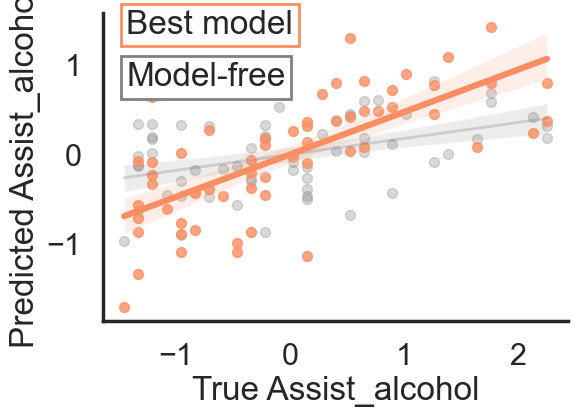

In [ ]:
best_model_results = bambi_alc_model_dict[r2_df.loc[0]['Model']]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), sharey=True)
sns.regplot(
    x=best_model_results.observed_data[dependent_var].values,
    y=np.vstack(bambi_alc_model_dict['Non-model parameters_filtered'].posterior_predictive[dependent_var].values).mean(axis=0),
    color='gray', ci=89, ax=ax, scatter_kws=dict(s=50, alpha=0.3), line_kws=dict(lw=2, alpha=0.3)
)
sns.regplot(
    x=best_model_results.observed_data[dependent_var].values,
    y=np.vstack(best_model_results.posterior_predictive[dependent_var].values).mean(axis=0),
    color=sns.palettes.color_palette('Set2')[1], ci=89, ax=ax, scatter_kws=dict(s=50)
)
sns.despine()
ax.set_xlabel(f'True {dependent_var.capitalize()}')
ax.set_ylabel(f'Predicted {dependent_var.capitalize()}')
ax.text(0.05, 1.01, f'Best model', transform=ax.transAxes, va='top', ha='left', bbox=dict(edgecolor=sns.palettes.color_palette('Set2')[1], facecolor='white'))
ax.text(0.05, 0.84, 'Model-free', transform=ax.transAxes, va='top', ha='left', bbox=dict(edgecolor='gray', facecolor='white'))

#### Standard statsmodels/bambi GLM by round

In [ ]:
# Set bambi flag on or off
bambi_flag = False

# Set significance threshold for stepwise regression
sig_threshold = 0.05

# Initialize empty dicts
round_statsmodels_alc_model_dict = {
    'Round 1': {},
    'Round 2': {}
}
round_bambi_alc_model_dict = {
    'Round 1': {},
    'Round 2': {}
}

In [ ]:
# Computational model parameters GLM
for i, model_name in enumerate(sorted(best_models['alcohol'])):
    for r in [1 ,2]:
        # Subset of data for model in the addictive cue block
        _model_df = master_df.loc[
            (master_df['Group']=='alcohol') &
            (master_df['Model']==model_name) & 
            (master_df['Block']=='other') &
            (master_df['Round']==r)
        ].dropna(how='all', axis=1).dropna(how='any', axis=0, subset=dependent_var).reset_index(drop=True)

        # Normalize the data
        model_param_names = []
        for param in (full_param_list+full_demo_list):
            if param in _model_df.columns:
                model_param_names.append(param)
        _columns_to_use = [dependent_var] + model_param_names
        _numerics = _model_df[_columns_to_use].select_dtypes(include=[np.number])
        _nonnumerics = _model_df[_columns_to_use].select_dtypes(exclude=[np.number])
        scaler = StandardScaler()
        _normed_model_df = pd.concat([
            pd.DataFrame(
                scaler.fit_transform(_numerics), 
                columns=_numerics.columns
            ),
            _nonnumerics
        ], axis=1)

        # Add dummy variables for categorical demographics
        normed_model_df = pd.get_dummies(_normed_model_df, columns=['DEMO_sex', 'DEMO_edu'])
        normed_model_df.columns = normed_model_df.columns.str.replace(' ', '_')
        
        # Build the model equation
        equation = dependent_var + ' ~ '
        model_param_names = []
        for param in full_param_list:
            if param in normed_model_df.columns:
                equation += param + ' + '
                model_param_names.append(param)
        for demo in full_demo_list:
            for col in normed_model_df.columns:
                if demo in col:
                    equation += col + ' + '
                    model_param_names.append(col)
        equation = equation[:-3]
        print(f'Round {r}, Number {i}:\t{model_name}\t{equation}')

        # Fit the model with statsmodels
        sm_results = smf.ols(formula=equation, data=normed_model_df).fit()
        display(sm_results.summary())
        round_statsmodels_alc_model_dict[f'Round {r}'][model_name] = sm_results

        if bambi_flag:
            # Fit the model with bambi
            bmb_model = bmb.Model(equation, normed_model_df, family=family)
            bmb_results = bmb_model.fit()
            ppc = bmb_model.predict(bmb_results, kind='pps')
            round_bambi_alc_model_dict[f'Round {r}'][model_name] = bmb_results
        
        # Filtering of the model (remove predictors with significance < 0.05)
        filtered_equation = equation
        least_sig = 1
        successful_filter = True
        while least_sig > sig_threshold:
            try:
                _sm_results = smf.ols(formula=filtered_equation, data=normed_model_df).fit()
            except PatsyError:
                successful_filter = False
                break
            x = pd.read_html(_sm_results.summary().tables[1].as_html())[0]
            y = x.iloc[0].astype(str)
            y[0] = 'Predictor'
            x.columns = y
            x = x.iloc[1:]
            x = pd.concat([
                x['Predictor'],
                x[[elem for elem in x.columns if 'Predictor' not in elem]].astype(str).astype(float)
            ], axis=1)
            x = x[x['Predictor']!='Intercept']
            least_sig = x.sort_values(by='P>|t|', ascending=False)['P>|t|'].values[0]
            predictors = [elem for elem in x.sort_values(by='P>|t|', ascending=False)['Predictor'].values.astype(str) if 'Intercept' not in elem]
            if least_sig > sig_threshold:
                filtered_equation = dependent_var + ' ~ ' + ' + '.join(predictors[1:])
            else:
                filtered_equation = dependent_var + ' ~ ' + ' + '.join(predictors)
        print(f'Round {r}. Number {i}:\t{model_name}\t{filtered_equation}')

        if successful_filter:
            # Fit the filtered model with statsmodels
            filtered_sm_results = smf.ols(formula=filtered_equation, data=normed_model_df).fit()
            display(filtered_sm_results.summary())
            round_statsmodels_alc_model_dict[f'Round {r}'][f'{model_name}_filtered'] = filtered_sm_results

            if bambi_flag:
                # Fit the filtered model with bambi
                filtered_bmb_model = bmb.Model(filtered_equation, normed_model_df, family=family)
                filtered_bmb_results = filtered_bmb_model.fit()
                filtered_ppc = filtered_bmb_model.predict(filtered_bmb_results, kind='pps')
                round_bambi_alc_model_dict[f'Round {r}'][f'{model_name}_filtered'] = filtered_bmb_results



Round 1, Number 0:	A_RWSep_1stepSep	ASSIST_Alcohol ~ alpha_pos + alpha_neg + beta + weight_zero + weight_one + weight_two + weight_three + weight_four + cec_weight + mod + DEMO_age + DEMO_sex_Female + DEMO_sex_Male + DEMO_sex_Other + DEMO_edu_College + DEMO_edu_Graduate + DEMO_edu_High_School + DEMO_edu_Some_college


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ASSIST_Alcohol   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.9965
Date:                Thu, 16 Mar 2023   Prob (F-statistic):              0.503
Time:                        11:10:20   Log-Likelihood:                -35.417
No. Observations:                  33   AIC:                             104.8
Df Residuals:                      16   BIC:                             130.3
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.1011      0.260     -0.389      0.702      -0.652       0.449
alpha_pos                 0.3706      0.246      1.508      0.151      -0.150       0.892
alpha_neg                 0.3813      0.423      0.900      0.381      -0.516       1.279
beta                     -0.3224      0.246     -1.311      0.208      -0.844       0.199
weight_zero               0.2012      0.317      0.635      0.535      -0.471       0.873
weight_one                0.4975      0.776      0.641      0.531      -1.148       2.143
weight_two               -0.2949      0.398     -0.740      0.470      -1.139       0.549
weight_three              0.1230      0.626      0.196      0.847      -1.205       1.451
weight_four               0.6474      0.675      0.959      0.352      -0.784       2.079
cec_weight                0.4767      0.494      0.964      0.349      -0.571       1.525
mod                      -0.1175      0.308     -0.382      0.708      -0.770       0.535
DEMO_age                  0.1668      0.223      0.747      0.466      -0.306       0.640
DEMO_sex_Female           0.4164      0.471      0.884      0.390      -0.582       1.414
DEMO_sex_Male            -0.1642      0.449     -0.366      0.719      -1.115       0.787
DEMO_sex_Other           -0.3533      0.974     -0.363      0.722      -2.419       1.712
DEMO_edu_College          0.1517      0.420      0.361      0.723      -0.740       1.043
DEMO_edu_Graduate         0.3927      0.440      0.893      0.385      -0.540       1.325
DEMO_edu_High_School     -0.3759      0.595     -0.632      0.536      -1.636       0.885
DEMO_edu_Some_college    -0.2696      0.483     -0.558      0.584      -1.293       0.754
==============================================================================
Omnibus:                        1.119   Durbin-Watson:                   2.249
Prob(Omnibus):                  0.572   Jarque-Bera (JB):                1.114
Skew:                           0.368   Prob(JB):                        0.573
Kurtosis:                       2.482   Cond. No.                     2.38e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.16e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Round 1. Number 0:	A_RWSep_1stepSep	ASSIST_Alcohol ~ weight_four + alpha_pos + beta


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ASSIST_Alcohol   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     4.508
Date:                Thu, 16 Mar 2023   Prob (F-statistic):             0.0103
Time:                        11:10:20   Log-Likelihood:                -40.509
No. Observations:                  33   AIC:                             89.02
Df Residuals:                      29   BIC:                             95.00
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1.193e-16      0.153  -7.78e-16      1.000      -0.314       0.314
weight_four     0.3581      0.169      2.118      0.043       0.012       0.704
alpha_pos       0.3781      0.156      2.426      0.022       0.059       0.697
beta           -0.4723      0.167     -2.832      0.008      -0.813      -0.131
==============================================================================
Omnibus:                        1.242   Durbin-Watson:                   2.281
Prob(Omnibus):                  0.537   Jarque-Bera (JB):                1.214
Skew:                           0.379   Prob(JB):                        0.545
Kurtosis:                       2.445   Cond. No.                         1.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Round 2, Number 0:	A_RWSep_1stepSep	ASSIST_Alcohol ~ alpha_pos + alpha_neg + beta + weight_zero + weight_one + weight_two + weight_three + weight_four + cec_weight + mod + DEMO_age + DEMO_sex_Female + DEMO_sex_Male + DEMO_edu_College + DEMO_edu_Graduate + DEMO_edu_High_School + DEMO_edu_Some_HS + DEMO_edu_Some_college


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ASSIST_Alcohol   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                 -0.626
Method:                 Least Squares   F-statistic:                    0.3741
Date:                Thu, 16 Mar 2023   Prob (F-statistic):              0.961
Time:                        11:10:20   Log-Likelihood:                -31.978
No. Observations:                  27   AIC:                             97.96
Df Residuals:                      10   BIC:                             120.0
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.0444      0.241     -0.184      0.858      -0.582       0.493
alpha_pos                 0.0653      0.431      0.152      0.882      -0.894       1.025
alpha_neg                 0.5876      0.511      1.150      0.277      -0.551       1.727
beta                     -0.4864      0.598     -0.814      0.435      -1.818       0.846
weight_zero               0.7753      0.827      0.937      0.371      -1.068       2.619
weight_one               -1.1235      0.982     -1.145      0.279      -3.311       1.064
weight_two                0.0002      1.596      0.000      1.000      -3.556       3.556
weight_three             -0.6785      0.718     -0.945      0.367      -2.278       0.922
weight_four              -0.5953      1.251     -0.476      0.644      -3.382       2.191
cec_weight               -0.2265      1.299     -0.174      0.865      -3.121       2.668
mod                       0.1320      1.130      0.117      0.909      -2.386       2.650
DEMO_age                  0.0551      0.522      0.106      0.918      -1.108       1.219
DEMO_sex_Female           0.1209      0.610      0.198      0.847      -1.239       1.480
DEMO_sex_Male            -0.1653      0.558     -0.296      0.773      -1.409       1.079
DEMO_edu_College          0.1498      0.850      0.176      0.864      -1.744       2.044
DEMO_edu_Graduate         0.4366      0.696      0.627      0.545      -1.115       1.988
DEMO_edu_High_School      0.4362      1.288      0.339      0.742      -2.435       3.307
DEMO_edu_Some_HS         -1.1132      1.497     -0.744      0.474      -4.449       2.223
DEMO_edu_Some_college     0.0462      0.765      0.060      0.953      -1.659       1.751
==============================================================================
Omnibus:                        3.078   Durbin-Watson:                   1.477
Prob(Omnibus):                  0.215   Jarque-Bera (JB):                2.095
Skew:                           0.680   Prob(JB):                        0.351
Kurtosis:                       3.100   Cond. No.                     2.19e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.94e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Round 2. Number 0:	A_RWSep_1stepSep	ASSIST_Alcohol ~ 


In [ ]:
# Non-model parameter GLM
model_name = 'Non-model parameters'

# Subset of data for model in the addictive cue block
for r in [1,2]:
    _model_df = master_df.loc[
        (master_df['Group']=='alcohol') &
        (master_df['Model']=='RWCEC') & 
        (master_df['Block']=='other') &
        (master_df['Round']==r)
    ].dropna(how='all', axis=1).dropna(how='any', axis=0, subset=dependent_var).reset_index(drop=True)

    # Normalize the data
    model_param_names = []
    for param in (full_nonmodel_param_list+full_demo_list):
        if param in _model_df.columns:
            model_param_names.append(param)
    _columns_to_use = [dependent_var] + model_param_names
    _numerics = _model_df[_columns_to_use].select_dtypes(include=[np.number])
    _nonnumerics = _model_df[_columns_to_use].select_dtypes(exclude=[np.number])
    scaler = StandardScaler()
    _normed_model_df = pd.concat([
        pd.DataFrame(
            scaler.fit_transform(_numerics), 
            columns=_numerics.columns
        ),
        _nonnumerics
    ], axis=1)

    # Add dummy variables for categorical demographics
    normed_model_df = pd.get_dummies(_normed_model_df, columns=['DEMO_sex', 'DEMO_edu'])
    normed_model_df.columns = normed_model_df.columns.str.replace(' ', '_')

    # Build the model equation
    equation = dependent_var + ' ~ '
    model_param_names = []
    for param in full_nonmodel_param_list:
        if param in normed_model_df.columns:
            equation += param + ' + '
            model_param_names.append(param)
    for demo in full_demo_list:
        for col in normed_model_df.columns:
            if demo in col:
                equation += col + ' + '
                model_param_names.append(col)
    equation = equation[:-3]
    print(f'Number {i}:\t{model_name}\t{equation}')

    # Fit the model with statsmodels
    sm_results = smf.ols(formula=equation, data=normed_model_df).fit()
    display(sm_results.summary())
    round_statsmodels_alc_model_dict[f'Round {r}'][model_name] = sm_results

    if bambi_flag:
        # Fit the model with bambi
        bmb_model = bmb.Model(equation, normed_model_df, family=family)
        bmb_results = bmb_model.fit()
        ppc = bmb_model.predict(bmb_results, kind='pps')
        round_bambi_alc_model_dict[f'Round {r}'][model_name] = bmb_results

    # Filtering of the model (remove predictors with significance < 0.05)
    filtered_equation = equation
    least_sig = 1
    successful_filter = True
    while least_sig > sig_threshold:
        try:
            _sm_results = smf.ols(formula=filtered_equation, data=normed_model_df).fit()

        x = pd.read_html(_sm_results.summary().tables[1].as_html())[0]
        y = x.iloc[0].astype(str)
        y[0] = 'Predictor'
        x.columns = y
        x = x.iloc[1:]
        x = pd.concat([
            x['Predictor'],
            x[[elem for elem in x.columns if 'Predictor' not in elem]].astype(str).astype(float)
        ], axis=1)
        x = x[x['Predictor']!='Intercept']
        least_sig = x.sort_values(by='P>|t|', ascending=False)['P>|t|'].values[0]
        predictors = [elem for elem in x.sort_values(by='P>|t|', ascending=False)['Predictor'].values.astype(str) if 'Intercept' not in elem]
        if least_sig > sig_threshold:
            filtered_equation = dependent_var + ' ~ ' + ' + '.join(predictors[1:])
        else:
            filtered_equation = dependent_var + ' ~ ' + ' + '.join(predictors)
    print(f'Number {i}:\t{model_name}\t{filtered_equation}')

    # Fit the filtered model with statsmodels
    filtered_sm_results = smf.ols(formula=filtered_equation, data=normed_model_df).fit()
    display(filtered_sm_results.summary())
    round_statsmodels_alc_model_dict[f'Round {r}'][f'{model_name}_filtered'] = filtered_sm_results

    if bambi_flag:
        # Fit the filtered model with bambi
        filtered_bmb_model = bmb.Model(filtered_equation, normed_model_df, family=family)
        filtered_bmb_results = filtered_bmb_model.fit()
        filtered_ppc = filtered_bmb_model.predict(filtered_bmb_results, kind='pps')
        round_bambi_alc_model_dict[f'Round {r}'][f'{model_name}_filtered'] = filtered_bmb_results



Number 0:	Non-model parameters	ASSIST_Alcohol ~ mean_craving_ratings + std_craving_ratings + mean_mood_ratings + std_mood_ratings + DEMO_age + DEMO_sex_Female + DEMO_sex_Male + DEMO_sex_Other + DEMO_edu_College + DEMO_edu_Graduate + DEMO_edu_High_School + DEMO_edu_Some_college


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ASSIST_Alcohol   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     1.490
Date:                Thu, 16 Mar 2023   Prob (F-statistic):              0.209
Time:                        11:03:31   Log-Likelihood:                -38.291
No. Observations:                  33   AIC:                             98.58
Df Residuals:                      22   BIC:                             115.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.1644      0.229     -0.718      0.480      -0.639       0.310
mean_craving_ratings     -0.0446      0.181     -0.246      0.808      -0.421       0.332
std_craving_ratings       0.2322      0.197      1.176      0.252      -0.177       0.642
mean_mood_ratings        -0.0070      0.196     -0.036      0.972      -0.414       0.400
std_mood_ratings         -0.4056      0.226     -1.794      0.087      -0.875       0.063
DEMO_age                  0.2033      0.203      1.002      0.327      -0.217       0.624
DEMO_sex_Female           0.5563      0.432      1.287      0.211      -0.340       1.453
DEMO_sex_Male            -0.2720      0.354     -0.768      0.451      -1.007       0.463
DEMO_sex_Other           -0.4487      0.815     -0.551      0.587      -2.138       1.241
DEMO_edu_College          0.3577      0.292      1.224      0.234      -0.248       0.964
DEMO_edu_Graduate         0.5756      0.336      1.715      0.100      -0.120       1.272
DEMO_edu_High_School     -0.4238      0.510     -0.830      0.415      -1.482       0.635
DEMO_edu_Some_college    -0.6739      0.459     -1.468      0.156      -1.626       0.278
==============================================================================
Omnibus:                        3.934   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.140   Jarque-Bera (JB):                1.614
Skew:                           0.049   Prob(JB):                        0.446
Kurtosis:                       1.921   Cond. No.                     2.75e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.6e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Number 0:	Non-model parameters	ASSIST_Alcohol ~ DEMO_edu_Some_college + DEMO_edu_Graduate + DEMO_sex_Female + DEMO_edu_High_School + DEMO_edu_College + std_mood_ratings


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ASSIST_Alcohol   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     2.670
Date:                Thu, 16 Mar 2023   Prob (F-statistic):             0.0437
Time:                        11:03:31   Log-Likelihood:                -40.196
No. Observations:                  33   AIC:                             92.39
Df Residuals:                      27   BIC:                             101.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.3775      0.186     -2.034      0.052      -0.758       0.003
DEMO_edu_Some_college    -0.5997      0.414     -1.449      0.159      -1.449       0.249
DEMO_edu_Graduate         0.4808      0.298      1.612      0.119      -0.131       1.093
DEMO_sex_Female           0.6618      0.390      1.697      0.101      -0.138       1.462
DEMO_edu_High_School     -0.6761      0.395     -1.711      0.099      -1.487       0.135
DEMO_edu_College          0.4175      0.231      1.808      0.082      -0.056       0.891
std_mood_ratings         -0.3483      0.186     -1.876      0.071      -0.729       0.033
==============================================================================
Omnibus:                        1.226   Durbin-Watson:                   2.343
Prob(Omnibus):                  0.542   Jarque-Bera (JB):                1.202
Skew:                           0.382   Prob(JB):                        0.548
Kurtosis:                       2.460   Cond. No.                     5.86e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.43e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Number 0:	Non-model parameters	ASSIST_Alcohol ~ mean_craving_ratings + std_craving_ratings + mean_mood_ratings + std_mood_ratings + DEMO_age + DEMO_sex_Female + DEMO_sex_Male + DEMO_edu_College + DEMO_edu_Graduate + DEMO_edu_High_School + DEMO_edu_Some_HS + DEMO_edu_Some_college


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ASSIST_Alcohol   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                 -0.177
Method:                 Least Squares   F-statistic:                    0.6085
Date:                Thu, 16 Mar 2023   Prob (F-statistic):              0.785
Time:                        11:03:31   Log-Likelihood:                -33.960
No. Observations:                  27   AIC:                             89.92
Df Residuals:                      16   BIC:                             104.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.1326      0.171      0.775      0.450      -0.230       0.496
mean_craving_ratings      0.3815      0.327      1.167      0.260      -0.311       1.074
std_craving_ratings      -0.2971      0.333     -0.891      0.386      -1.004       0.410
mean_mood_ratings         0.1258      0.338      0.372      0.715      -0.591       0.842
std_mood_ratings         -0.2304      0.391     -0.590      0.564      -1.059       0.598
DEMO_age                 -0.0186      0.260     -0.072      0.944      -0.571       0.533
DEMO_sex_Female           0.1501      0.284      0.528      0.605      -0.452       0.752
DEMO_sex_Male            -0.0174      0.261     -0.067      0.948      -0.571       0.536
DEMO_edu_College         -0.5609      0.468     -1.197      0.249      -1.554       0.432
DEMO_edu_Graduate         0.1760      0.536      0.328      0.747      -0.961       1.313
DEMO_edu_High_School      0.2794      0.777      0.360      0.724      -1.368       1.927
DEMO_edu_Some_HS          0.4583      1.145      0.400      0.694      -1.969       2.886
DEMO_edu_Some_college    -0.2202      0.443     -0.497      0.626      -1.159       0.719
==============================================================================
Omnibus:                        4.307   Durbin-Watson:                   1.603
Prob(Omnibus):                  0.116   Jarque-Bera (JB):                3.664
Skew:                           0.894   Prob(JB):                        0.160
Kurtosis:                       2.751   Cond. No.                     1.86e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.61e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Number 0:	Non-model parameters	ASSIST_Alcohol ~ DEMO_edu_College + mean_craving_ratings + std_craving_ratings


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ASSIST_Alcohol   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     2.225
Date:                Thu, 16 Mar 2023   Prob (F-statistic):              0.112
Time:                        11:03:32   Log-Likelihood:                -34.871
No. Observations:                  27   AIC:                             77.74
Df Residuals:                      23   BIC:                             82.92
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.2073      0.240      0.865      0.396      -0.288       0.703
DEMO_edu_College        -0.5597      0.416     -1.347      0.191      -1.419       0.300
mean_craving_ratings     0.3725      0.192      1.944      0.064      -0.024       0.769
std_craving_ratings     -0.4334      0.205     -2.117      0.045      -0.857      -0.010
==============================================================================
Omnibus:                        3.133   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.209   Jarque-Bera (JB):                2.526
Skew:                           0.631   Prob(JB):                        0.283
Kurtosis:                       2.191   Cond. No.                         2.79
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
performance_df = pd.DataFrame(columns=['Model', 'R2', 'R2_adj', 'AIC', 'BIC'])
for model in round_statsmodels_alc_model_dict['Round 1']:
    sm_results = round_statsmodels_alc_model_dict['Round 1'][model]
    performance_df = pd.concat([
        performance_df,
        pd.DataFrame({
            'Model': [model],
            'R2': [sm_results.rsquared],
            'R2_adj': [sm_results.rsquared_adj],
            'AIC': [sm_results.aic],
            'BIC': [sm_results.bic]
        })
    ], axis=0)
performance_df = performance_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
display(performance_df)

Model        R2    R2_adj         AIC         BIC
0      A_RWSep_1stepSep_filtered  0.373653  0.284175   88.210877   95.693415
1  Non-model parameters_filtered  0.330848  0.206931   92.392384  101.371429
2           Non-model parameters  0.403814  0.132821   98.582247  115.043830
3               A_RWSep_1stepSep  0.499124 -0.001752  104.833844  130.274472

In [ ]:
performance_df = pd.DataFrame(columns=['Model', 'R2', 'R2_adj', 'AIC', 'BIC'])
for model in round_statsmodels_alc_model_dict['Round 2']:
    sm_results = round_statsmodels_alc_model_dict['Round 2'][model]
    performance_df = pd.concat([
        performance_df,
        pd.DataFrame({
            'Model': [model],
            'R2': [sm_results.rsquared],
            'R2_adj': [sm_results.rsquared_adj],
            'AIC': [sm_results.aic],
            'BIC': [sm_results.bic]
        })
    ], axis=0)
performance_df = performance_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
display(performance_df)

Model        R2    R2_adj        AIC         BIC
0  Non-model parameters_filtered  0.224975  0.123885  77.741469   82.924817
1      A_RWSep_1stepSep_filtered  0.283304  0.068295  81.628892   90.699750
2           Non-model parameters  0.275541 -0.177246  89.919781  104.173987
3               A_RWSep_1stepSep  0.374458 -0.626410  97.955998  119.985225

rank  elpd_waic     p_waic  elpd_diff  \
A_RWSep_1stepSep_filtered         0 -80.247187   4.951947   0.000000   
Non-model parameters_filtered     1 -82.861687   3.238822   2.614500   
Non-model parameters              2 -88.191834  10.176584   7.944647   
A_RWSep_1stepSep                  3 -88.925061  13.569747   8.677873   

                                     weight        se       dse  warning scale  
A_RWSep_1stepSep_filtered      7.119969e-01  5.987387  0.000000     True   log  
Non-model parameters_filtered  2.880031e-01  4.650009  4.116017    False   log  
Non-model parameters           0.000000e+00  5.401670  4.083219     True   log  
A_RWSep_1stepSep               3.031464e-12  5.178642  2.386181     True   log

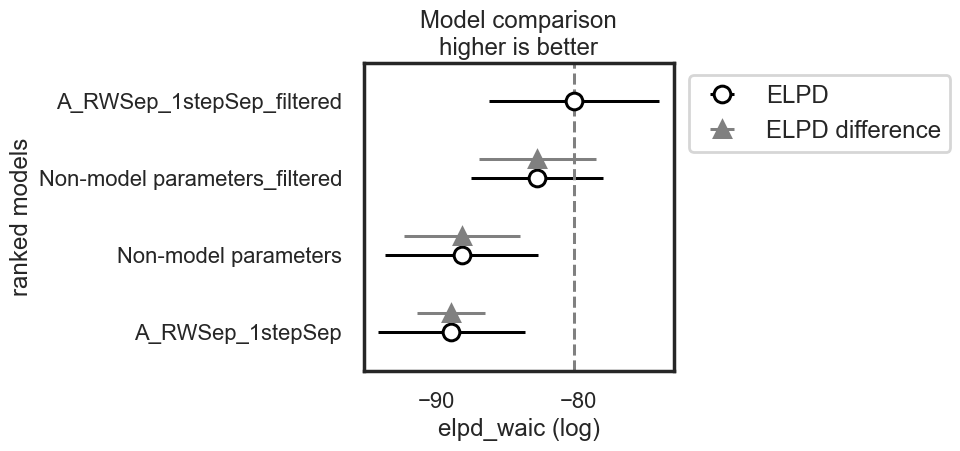

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df_compare = az.compare(bambi_alc_model_dict, ic='waic')
    display(df_compare)
    az.plot_compare(df_compare, insample_dev=False, plot_ic_diff=True, figsize=(4, 4));

In [ ]:
# Combination of model and non-model parameters GLM
# Only for best performing computational model above (A_RWSep_1stepSep)
best_perf_comp_model = best_models['alcohol'][0]
model_name = 'combined'

# Subset of data for model in the addictive cue block
_model_df = master_df.loc[
    (master_df['Group']=='alcohol') &
    (master_df['Model']==best_perf_comp_model) & 
    (master_df['Block']=='other')
].dropna(how='all', axis=1).dropna(how='any', axis=0, subset=dependent_var).reset_index(drop=True)

# Normalize the data
model_param_names = []
for param in (full_param_list+full_nonmodel_param_list+full_demo_list):
    if param in _model_df.columns:
        model_param_names.append(param)
_columns_to_use = [dependent_var] + model_param_names
_numerics = _model_df[_columns_to_use].select_dtypes(include=[np.number])
_nonnumerics = _model_df[_columns_to_use].select_dtypes(exclude=[np.number])
scaler = StandardScaler()
_normed_model_df = pd.concat([
    pd.DataFrame(
        scaler.fit_transform(_numerics), 
        columns=_numerics.columns
    ),
    _nonnumerics
], axis=1)

# Add dummy variables for categorical demographics
normed_model_df = pd.get_dummies(_normed_model_df, columns=['DEMO_sex', 'DEMO_edu'])
normed_model_df.columns = normed_model_df.columns.str.replace(' ', '_')

# Build the model equation
equation = dependent_var + ' ~ '
model_param_names = []
for param in full_param_list:
    if param in normed_model_df.columns:
        equation += param + ' + '
        model_param_names.append(param)
for param in full_nonmodel_param_list:
    if param in normed_model_df.columns:
        equation += param + ' + '
        model_param_names.append(param)
for demo in full_demo_list:
    for col in normed_model_df.columns:
        if demo in col:
            equation += col + ' + '
            model_param_names.append(col)
    # if demo in model_df.columns:
    #     if demo=='DEMO_age':
    #         equation += demo + ' + '
    #     else:
    #         equation += 'C(' + demo + ') + '
    #     model_param_names.append(demo)
equation = equation[:-3]
print(f'Number {i}:\t{model_name}\t{equation}')

# Fit the model with statsmodels
sm_results = smf.ols(formula=equation, data=normed_model_df).fit()
display(sm_results.summary())
statsmodels_alc_model_dict[model_name] = sm_results

if bambi_flag:
    # Fit the model with bambi
    bmb_model = bmb.Model(equation, normed_model_df, family=family)
    bmb_results = bmb_model.fit()
    ppc = bmb_model.predict(bmb_results, kind='pps')
    bambi_alc_model_dict[model_name] = bmb_results

# Filtering of the model (remove predictors with significance < 0.05)
filtered_equation = equation
least_sig = 1
while least_sig > sig_threshold:
    _sm_results = smf.ols(formula=filtered_equation, data=normed_model_df).fit()

    x = pd.read_html(_sm_results.summary().tables[1].as_html())[0]
    y = x.iloc[0].astype(str)
    y[0] = 'Predictor'
    x.columns = y
    x = x.iloc[1:]
    x = pd.concat([
        x['Predictor'],
        x[[elem for elem in x.columns if 'Predictor' not in elem]].astype(str).astype(float)
    ], axis=1)
    x = x[x['Predictor']!='Intercept']
    least_sig = x.sort_values(by='P>|t|', ascending=False)['P>|t|'].values[0]
    predictors = [elem for elem in x.sort_values(by='P>|t|', ascending=False)['Predictor'].values.astype(str) if 'Intercept' not in elem]
    if least_sig > sig_threshold:
        filtered_equation = dependent_var + ' ~ ' + ' + '.join(predictors[1:])
    else:
        filtered_equation = dependent_var + ' ~ ' + ' + '.join(predictors)
print(f'Number {i}:\t{model_name}\t{filtered_equation}')

# Fit the filtered model with statsmodels
filtered_sm_results = smf.ols(formula=filtered_equation, data=normed_model_df).fit()
display(filtered_sm_results.summary())
statsmodels_alc_model_dict[f'{model_name}_filtered'] = filtered_sm_results

if bambi_flag:
    # Fit the filtered model with bambi
    filtered_bmb_model = bmb.Model(filtered_equation, normed_model_df, family=family)
    filtered_bmb_results = filtered_bmb_model.fit()
    filtered_ppc = filtered_bmb_model.predict(filtered_bmb_results, kind='pps')
    bambi_alc_model_dict[f'{model_name}_filtered'] = filtered_bmb_results



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [ ]:
performance_df = pd.DataFrame(columns=['Model', 'R2', 'R2_adj', 'AIC', 'BIC'])
for model in statsmodels_alc_model_dict:
    sm_results = statsmodels_alc_model_dict[model]
    performance_df = pd.concat([
        performance_df,
        pd.DataFrame({
            'Model': [model],
            'R2': [sm_results.rsquared],
            'R2_adj': [sm_results.rsquared_adj],
            'AIC': [sm_results.aic],
            'BIC': [sm_results.bic]
        })
    ], axis=0)
performance_df = performance_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
performance_df

Model        R2    R2_adj         AIC         BIC
0              combined_filtered  0.356172  0.309349  153.853161  164.324884
1      A_RWSep_1stepSep_filtered  0.302526  0.251800  158.655259  169.126982
2  Non-model parameters_filtered  0.181426  0.152704  164.261118  170.544152
3           Non-model parameters  0.291073  0.128610  173.632466  198.764601
4               A_RWSep_1stepSep  0.410038  0.171244  174.610820  212.309022
5                       combined  0.473383  0.182358  175.795681  221.871262

In [ ]:
statsmodels_alc_model_dict['combined_filtered'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ASSIST_Alcohol   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     7.607
Date:                Tue, 28 Feb 2023   Prob (F-statistic):           5.95e-05
Time:                        10:48:24   Log-Likelihood:                -71.927
No. Observations:                  60   AIC:                             153.9
Df Residuals:                      55   BIC:                             164.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -2.776e-17      0.108  -2.57e-16      1.000      -0.217       0.217
alpha_neg                0.2707      0.120      2.256      0.028       0.030       0.511
beta                    -0.3692      0.110     -3.342      0.002      -0.591      -0.148
std_mood_ratings        -0.3619      0.110     -3.285      0.002      -0.583      -0.141
mean_craving_ratings     0.3982      0.121      3.296      0.002       0.156       0.640
==============================================================================
Omnibus:                        3.489   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.175   Jarque-Bera (JB):                2.546
Skew:                           0.408   Prob(JB):                        0.280
Kurtosis:                       3.594   Cond. No.                         1.66
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

rank  elpd_waic     p_waic  elpd_diff  \
combined_filtered                 0 -77.856740   5.130614   0.000000   
A_RWSep_1stepSep_filtered         1 -80.247187   4.951947   2.390447   
Non-model parameters_filtered     2 -82.861687   3.238822   5.004947   
Non-model parameters              3 -88.191834  10.176584  10.335094   
A_RWSep_1stepSep                  4 -88.925061  13.569747  11.068321   
combined                          5 -90.296515  16.301947  12.439776   

                                     weight        se       dse  warning scale  
combined_filtered              8.609451e-01  6.310062  0.000000     True   log  
A_RWSep_1stepSep_filtered      3.188033e-13  5.987387  2.307082     True   log  
Non-model parameters_filtered  1.390549e-01  4.650009  3.959174    False   log  
Non-model parameters           2.520075e-13  5.401670  3.776075     True   log  
A_RWSep_1stepSep               4.645623e-14  5.178642  3.397958     True   log  
combined                       0.000000e+00  5.340314  2.678384     True   log

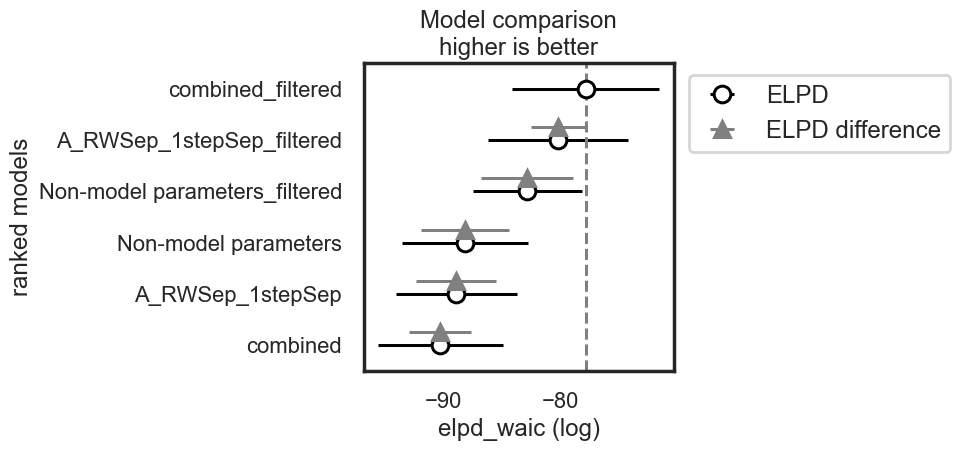

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df_compare = az.compare(bambi_alc_model_dict, ic='waic')
    display(df_compare)
    az.plot_compare(df_compare, insample_dev=False, plot_ic_diff=True, figsize=(4, 4));

Calculate R2 for all regressions

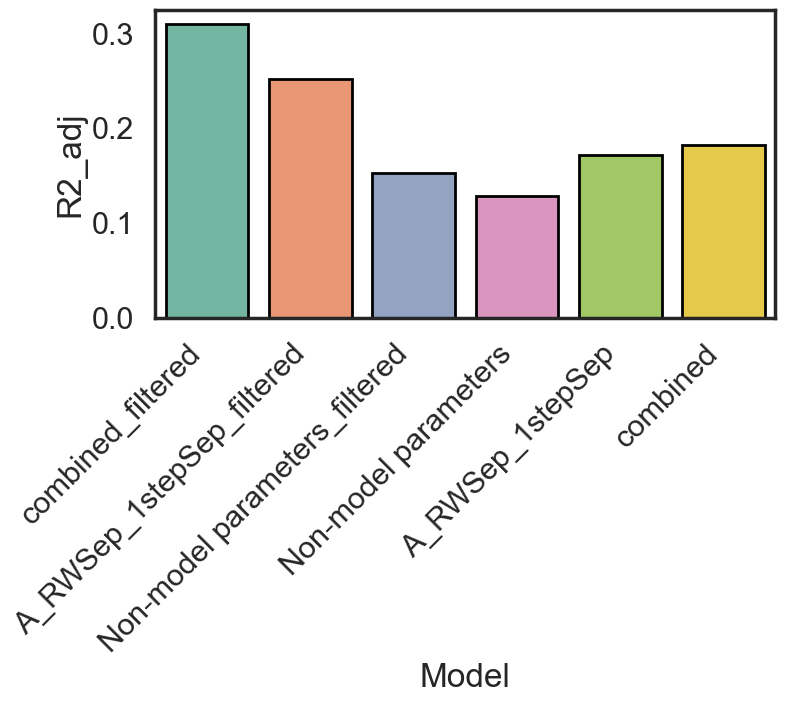

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x='Model', y='R2_adj', data=performance_df, dodge=False, ax=ax, palette='Set2', edgecolor='black', linewidth=2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');

Identify the most predictive variables

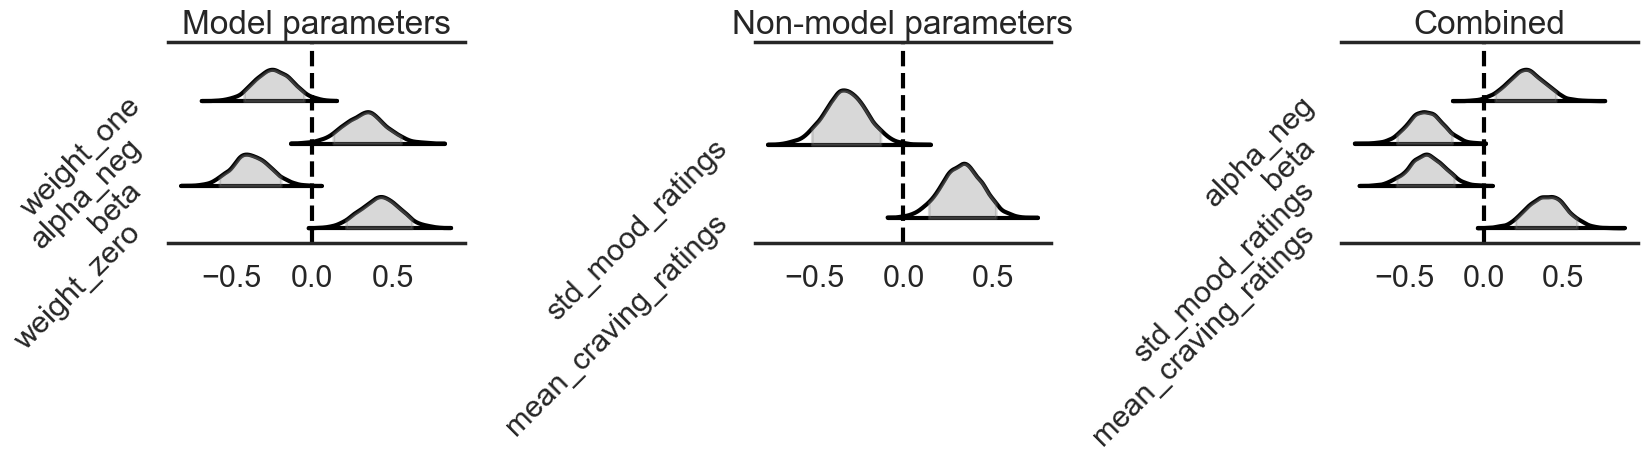

In [ ]:
fig, ax = plt.subplots(figsize=(17, 5), ncols=3, nrows=1)
i_count = -1
for i, model_name in enumerate(bambi_alc_model_dict.keys()):
    if 'filtered' not in model_name:
        continue
    if i>8:
        break
    else:
        i_count += 1
        if 'Non-model parameters' in model_name:
            ax[i_count].set_title('Non-model parameters')
        elif 'combined' in model_name:
            ax[i_count].set_title('Combined')
        else:
            ax[i_count].set_title('Model parameters')
    vars = []
    summary_model_df = az.summary(bambi_alc_model_dict[model_name])
    candidate_vars = np.array([
        elem for elem in az.summary(bambi_alc_model_dict[model_name]).index if elem in (full_param_list + full_demo_list + full_nonmodel_param_list)
    ])
    for var in candidate_vars:
        if np.abs(summary_model_df.loc[var]['hdi_3%'] + summary_model_df.loc[var]['hdi_97%']) > np.abs(summary_model_df.loc[var]['hdi_97%']):
            vars.append(var)
    az.plot_forest(
        bambi_alc_model_dict[model_name], 
        var_names=vars,
        figsize=(5,4), combined=True, 
        kind='ridgeplot', ridgeplot_alpha=0.3, 
        hdi_prob=0.89,
        # ridgeplot_quantiles=[.25, .5, .75],
        ridgeplot_overlap=1, 
        ridgeplot_truncate=False,
        colors='gray',
        ax=ax[i_count],
    )
    # plt.xlim(-15, 15)
    # ax[i_count].set_title(model_name)
    ax[i_count].axvline(0, color='k', linestyle='--')
    ax[i_count].set_yticklabels(ax[i_count].get_yticklabels(), rotation=45, ha='right')
plt.tight_layout()

Visualize the posterior predictive distributions for the best model

Text(0.05, 0.95, 'Non-model parameters')

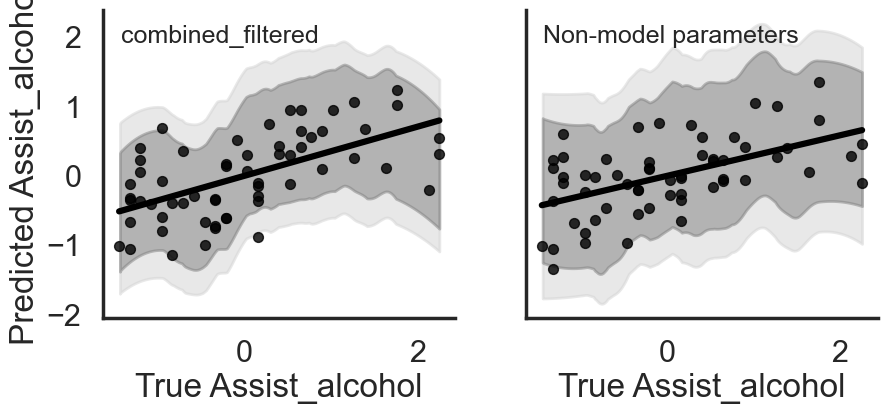

In [ ]:
best_model_name = performance_df.iloc[0]['Model']
best_model_results = bambi_alc_model_dict[best_model_name]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)
az.plot_hdi(
    best_model_results.observed_data[dependent_var].values,
    best_model_results.posterior_predictive[dependent_var].values,
    hdi_prob=0.84, smooth=True, color='lightgray', ax=ax[0]
)
az.plot_hdi(
    best_model_results.observed_data[dependent_var].values,
    best_model_results.posterior_predictive[dependent_var].values,
    hdi_prob=0.68, smooth=True, color='gray', ax=ax[0]
)
sns.regplot(
    x=best_model_results.observed_data[dependent_var].values,
    y=np.vstack(best_model_results.posterior_predictive[dependent_var].values).mean(axis=0),
    color='black', ci=0, ax=ax[0], scatter_kws=dict(s=50)
)
az.plot_hdi(
    best_model_results.observed_data[dependent_var].values,
    bambi_alc_model_dict['Non-model parameters'].posterior_predictive[dependent_var].values,
    hdi_prob=0.84, smooth=True, color='lightgray', ax=ax[1]
)
az.plot_hdi(
    best_model_results.observed_data[dependent_var].values,
    bambi_alc_model_dict['Non-model parameters'].posterior_predictive[dependent_var].values,
    hdi_prob=0.68, smooth=True, color='gray', ax=ax[1]
)
sns.regplot(
    x=best_model_results.observed_data[dependent_var].values,
    y=np.vstack(bambi_alc_model_dict['Non-model parameters'].posterior_predictive[dependent_var].values).mean(axis=0),
    color='black', ci=0, ax=ax[1], scatter_kws=dict(s=50)
)
sns.despine()
ax[0].set_xlabel(f'True {dependent_var.capitalize()}')
ax[0].set_ylabel(f'Predicted {dependent_var.capitalize()}')
ax[1].set_xlabel(f'True {dependent_var.capitalize()}')
ax[0].text(0.05, 0.95, f'{best_model_name}', transform=ax[0].transAxes, va='top', ha='left', fontsize=18)
ax[1].text(0.05, 0.95, 'Non-model parameters', transform=ax[1].transAxes, va='top', ha='left', fontsize=18)

Calculate the significance of improvement in predictions by using computational parameters

In [ ]:
predicted = np.hstack((
    np.vstack(best_model_results.posterior_predictive[dependent_var].values).mean(axis=0),
    np.vstack(bambi_alc_model_dict['Non-model parameters_filtered'].posterior_predictive[dependent_var].values).mean(axis=0)
))
true = np.hstack((
    best_model_results.observed_data[dependent_var].values,
    best_model_results.observed_data[dependent_var].values
))
model_labels = np.hstack((
    # np.repeat(r2_df.loc[0]['Model'], len(sample_model_df)),
    np.repeat(1, len(best_model_results.observed_data[dependent_var].values)),
    # np.repeat('model-free', len(sample_model_df))
    np.repeat(0, len(best_model_results.observed_data[dependent_var].values))
))
alc_predict_df = pd.DataFrame({
    'predicted': predicted,
    'true': true,
    'model': model_labels
})

equation = 'predicted ~ true * model'
print(equation)
alc_pred_model = bmb.Model(equation, alc_predict_df)
alc_results = alc_pred_model.fit()
# ppc_alt = model_alt.predict(results_alt, kind='pps')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


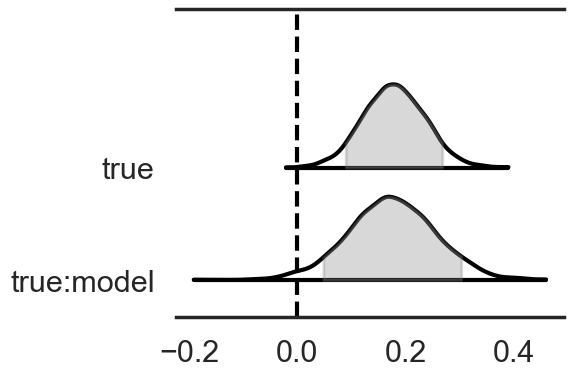

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
az.plot_forest(
    alc_results, 
    filter_vars='regex',
    var_names=['^true'],
    figsize=(5,2), combined=True, 
    kind='ridgeplot', ridgeplot_alpha=0.3, 
    hdi_prob=0.89,
    # ridgeplot_quantiles=[.25, .5, .75],
    ridgeplot_overlap=1, 
    ridgeplot_truncate=False,
    colors='gray',
    ax=ax,
)
ax.axvline(0, color='k', linestyle='--')

In [ ]:
smf.ols(equation, alc_predict_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              predicted   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     16.11
Date:                Tue, 28 Feb 2023   Prob (F-statistic):           8.08e-09
Time:                        10:15:22   Log-Likelihood:                -70.094
No. Observations:                 120   AIC:                             148.2
Df Residuals:                     116   BIC:                             159.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -9.37e-05      0.057     -0.002      0.999      -0.113       0.113
true           0.1783      0.057      3.129      0.002       0.065       0.291
model         -0.0006      0.081     -0.007      0.994      -0.160       0.159
true:model     0.1755      0.081      2.177      0.031       0.016       0.335
==============================================================================
Omnibus:                        3.761   Durbin-Watson:                   2.346
Prob(Omnibus):                  0.153   Jarque-Bera (JB):                2.214
Skew:                          -0.059   Prob(JB):                        0.331
Kurtosis:                       2.345   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.05, 0.84, 'Model-free')

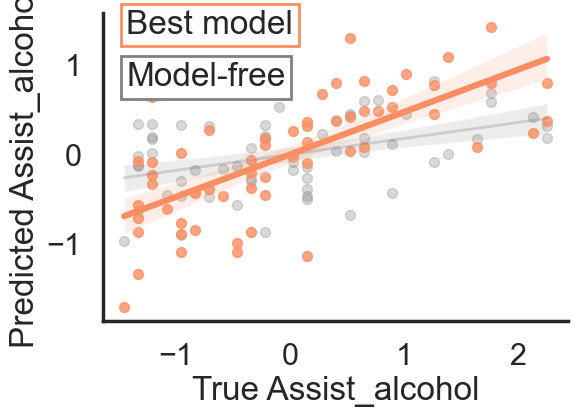

In [ ]:
best_model_results = bambi_alc_model_dict[r2_df.loc[0]['Model']]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), sharey=True)
sns.regplot(
    x=best_model_results.observed_data[dependent_var].values,
    y=np.vstack(bambi_alc_model_dict['Non-model parameters_filtered'].posterior_predictive[dependent_var].values).mean(axis=0),
    color='gray', ci=89, ax=ax, scatter_kws=dict(s=50, alpha=0.3), line_kws=dict(lw=2, alpha=0.3)
)
sns.regplot(
    x=best_model_results.observed_data[dependent_var].values,
    y=np.vstack(best_model_results.posterior_predictive[dependent_var].values).mean(axis=0),
    color=sns.palettes.color_palette('Set2')[1], ci=89, ax=ax, scatter_kws=dict(s=50)
)
sns.despine()
ax.set_xlabel(f'True {dependent_var.capitalize()}')
ax.set_ylabel(f'Predicted {dependent_var.capitalize()}')
ax.text(0.05, 1.01, f'Best model', transform=ax.transAxes, va='top', ha='left', bbox=dict(edgecolor=sns.palettes.color_palette('Set2')[1], facecolor='white'))
ax.text(0.05, 0.84, 'Model-free', transform=ax.transAxes, va='top', ha='left', bbox=dict(edgecolor='gray', facecolor='white'))

### Cannabis

In [ ]:
dependent_var = 'CAST_Cannabis'

full_demo_list = ['DEMO_age', 'DEMO_sex', 'DEMO_edu']

full_param_list = [
    'alpha', 'alpha_pos', 'alpha_neg',
    'beta',
    'weight_zero', 'weight_one', 'weight_two',
    'weight_three', 'weight_four', 'weight_five',
    'weight_six', 'cec_weight', 'mod',
    'bias', 'eps',
]

full_nonmodel_param_list = ['mean_craving_ratings', 'std_craving_ratings', 'mean_mood_ratings', 'std_mood_ratings']

family = 'gaussian'

#### Standard statsmodels/bambi GLM 

In [ ]:
# Set bambi flag on or off
bambi_flag = True

# Set significance threshold for stepwise regression
sig_threshold = 0.05

# Initialize empty dicts
statsmodels_cannabis_model_dict = {}
bambi_cannabis_model_dict = {}

In [ ]:
# Computational model parameters GLM
for i, model_name in enumerate(sorted(best_models['cannabis'])):
    # Subset of data for model in the addictive cue block
    _model_df = master_df.loc[
        (master_df['Group']=='cannabis') &
        (master_df['Model']==model_name) & 
        (master_df['Block']=='other')
    ].dropna(how='all', axis=1).dropna(how='any', axis=0, subset=dependent_var).reset_index(drop=True)

    # Normalize the data
    model_param_names = []
    for param in (full_param_list+full_demo_list):
        if param in _model_df.columns:
            model_param_names.append(param)
    _columns_to_use = [dependent_var] + model_param_names
    _numerics = _model_df[_columns_to_use].select_dtypes(include=[np.number])
    _nonnumerics = _model_df[_columns_to_use].select_dtypes(exclude=[np.number])
    scaler = StandardScaler()
    _normed_model_df = pd.concat([
        pd.DataFrame(
            scaler.fit_transform(_numerics), 
            columns=_numerics.columns
        ),
        _nonnumerics
    ], axis=1)

    # Add dummy variables for categorical demographics
    normed_model_df = pd.get_dummies(_normed_model_df, columns=['DEMO_sex', 'DEMO_edu'])
    normed_model_df.columns = normed_model_df.columns.str.replace(' ', '_')
    
    # Build the model equation
    equation = dependent_var + ' ~ '
    model_param_names = []
    for param in full_param_list:
        if param in normed_model_df.columns:
            equation += param + ' + '
            model_param_names.append(param)
    for demo in full_demo_list:
        for col in normed_model_df.columns:
            if demo in col:
                equation += col + ' + '
                model_param_names.append(col)
    equation = equation[:-3]
    print(f'Number {i}:\t{model_name}\t{equation}')

    # Fit the model with statsmodels
    sm_results = smf.ols(formula=equation, data=normed_model_df).fit()
    display(sm_results.summary())
    statsmodels_cannabis_model_dict[model_name] = sm_results

    if bambi_flag:
        # Fit the model with bambi
        bmb_model = bmb.Model(equation, normed_model_df, family=family)
        bmb_results = bmb_model.fit()
        ppc = bmb_model.predict(bmb_results, kind='pps')
        bambi_cannabis_model_dict[model_name] = bmb_results
    
    # Filtering of the model (remove predictors with significance < 0.05)
    filtered_equation = equation
    least_sig = 1
    failed = False
    while least_sig > sig_threshold:
        try:
            _sm_results = smf.ols(formula=filtered_equation, data=normed_model_df).fit()
        except PatsyError:
            failed = True
            print(f'Model {model_name} failed to converge. No significant predictors found.')
            break

        x = pd.read_html(_sm_results.summary().tables[1].as_html())[0]
        y = x.iloc[0].astype(str)
        y[0] = 'Predictor'
        x.columns = y
        x = x.iloc[1:]
        x = pd.concat([
            x['Predictor'],
            x[[elem for elem in x.columns if 'Predictor' not in elem]].astype(str).astype(float)
        ], axis=1)
        x = x[x['Predictor']!='Intercept']
        least_sig = x.sort_values(by='P>|t|', ascending=False)['P>|t|'].values[0]
        predictors = [elem for elem in x.sort_values(by='P>|t|', ascending=False)['Predictor'].values.astype(str) if 'Intercept' not in elem]
        if least_sig > sig_threshold:
            filtered_equation = dependent_var + ' ~ ' + ' + '.join(predictors[1:])
        else:
            filtered_equation = dependent_var + ' ~ ' + ' + '.join(predictors)
    print(f'Number {i}:\t{model_name}\t{filtered_equation}')

    # Fit the filtered model with statsmodels
    if not failed:
        filtered_sm_results = smf.ols(formula=filtered_equation, data=normed_model_df).fit()
        display(filtered_sm_results.summary())
        statsmodels_cannabis_model_dict[f'{model_name}_filtered'] = filtered_sm_results

        if bambi_flag:
            # Fit the filtered model with bambi
            filtered_bmb_model = bmb.Model(filtered_equation, normed_model_df, family=family)
            filtered_bmb_results = filtered_bmb_model.fit()
            filtered_ppc = filtered_bmb_model.predict(filtered_bmb_results, kind='pps')
            bambi_cannabis_model_dict[f'{model_name}_filtered'] = filtered_bmb_results



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [ ]:
# Non-model parameter GLM
model_name = 'Non-model parameters'

# Subset of data for model in the addictive cue block
_model_df = master_df.loc[
    (master_df['Group']=='cannabis') &
    (master_df['Model']=='RWCEC') & 
    (master_df['Block']=='other')
].dropna(how='all', axis=1).dropna(how='any', axis=0, subset=dependent_var).reset_index(drop=True)

# Normalize the data
model_param_names = []
for param in (full_nonmodel_param_list+full_demo_list):
    if param in _model_df.columns:
        model_param_names.append(param)
_columns_to_use = [dependent_var] + model_param_names
_numerics = _model_df[_columns_to_use].select_dtypes(include=[np.number])
_nonnumerics = _model_df[_columns_to_use].select_dtypes(exclude=[np.number])
scaler = StandardScaler()
_normed_model_df = pd.concat([
    pd.DataFrame(
        scaler.fit_transform(_numerics), 
        columns=_numerics.columns
    ),
    _nonnumerics
], axis=1)

# Add dummy variables for categorical demographics
normed_model_df = pd.get_dummies(_normed_model_df, columns=['DEMO_sex', 'DEMO_edu'])
normed_model_df.columns = normed_model_df.columns.str.replace(' ', '_')

# Build the model equation
equation = dependent_var + ' ~ '
model_param_names = []
for param in full_nonmodel_param_list:
    if param in normed_model_df.columns:
        equation += param + ' + '
        model_param_names.append(param)
for demo in full_demo_list:
    for col in normed_model_df.columns:
        if demo in col:
            equation += col + ' + '
            model_param_names.append(col)
equation = equation[:-3]
print(f'Number {i}:\t{model_name}\t{equation}')

# Fit the model with statsmodels
sm_results = smf.ols(formula=equation, data=normed_model_df).fit()
display(sm_results.summary())
statsmodels_cannabis_model_dict[model_name] = sm_results

if bambi_flag:
    # Fit the model with bambi
    bmb_model = bmb.Model(equation, normed_model_df, family=family)
    bmb_results = bmb_model.fit()
    ppc = bmb_model.predict(bmb_results, kind='pps')
    bambi_cannabis_model_dict[model_name] = bmb_results

# Filtering of the model (remove predictors with significance < 0.05)
filtered_equation = equation
least_sig = 1
failed = False
while least_sig > sig_threshold:
    try:
        _sm_results = smf.ols(formula=filtered_equation, data=normed_model_df).fit()
    except PatsyError:
        failed = True
        print(f'Model {model_name} failed to converge. No significant predictors found.')
        break

    x = pd.read_html(_sm_results.summary().tables[1].as_html())[0]
    y = x.iloc[0].astype(str)
    y[0] = 'Predictor'
    x.columns = y
    x = x.iloc[1:]
    x = pd.concat([
        x['Predictor'],
        x[[elem for elem in x.columns if 'Predictor' not in elem]].astype(str).astype(float)
    ], axis=1)
    x = x[x['Predictor']!='Intercept']
    least_sig = x.sort_values(by='P>|t|', ascending=False)['P>|t|'].values[0]
    predictors = [elem for elem in x.sort_values(by='P>|t|', ascending=False)['Predictor'].values.astype(str) if 'Intercept' not in elem]
    if least_sig > sig_threshold:
        filtered_equation = dependent_var + ' ~ ' + ' + '.join(predictors[1:])
    else:
        filtered_equation = dependent_var + ' ~ ' + ' + '.join(predictors)
print(f'Number {i}:\t{model_name}\t{filtered_equation}')

if not failed:
    # Fit the filtered model with statsmodels
    filtered_sm_results = smf.ols(formula=filtered_equation, data=normed_model_df).fit()
    display(filtered_sm_results.summary())
    statsmodels_cannabis_model_dict[f'{model_name}_filtered'] = filtered_sm_results

    if bambi_flag:
        # Fit the filtered model with bambi
        filtered_bmb_model = bmb.Model(filtered_equation, normed_model_df, family=family)
        filtered_bmb_results = filtered_bmb_model.fit()
        filtered_ppc = filtered_bmb_model.predict(filtered_bmb_results, kind='pps')
        bambi_cannabis_model_dict[f'{model_name}_filtered'] = filtered_bmb_results



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [ ]:
performance_df = pd.DataFrame(columns=['Model', 'R2', 'R2_adj', 'AIC', 'BIC'])
for model in statsmodels_cannabis_model_dict:
    sm_results = statsmodels_cannabis_model_dict[model]
    performance_df = pd.concat([
        performance_df,
        pd.DataFrame({
            'Model': [model],
            'R2': [sm_results.rsquared],
            'R2_adj': [sm_results.rsquared_adj],
            'AIC': [sm_results.aic],
            'BIC': [sm_results.bic]
        })
    ], axis=0)
performance_df = performance_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
performance_df

Model        R2    R2_adj         AIC         BIC
0       A_RW_2stepDecay_filtered  0.408843  0.365850  148.732202  159.203925
1                A_RW_2stepDecay  0.522723  0.400865  151.893140  179.119619
2  Non-model parameters_filtered  0.256146  0.230046  158.517995  164.801028
3           Non-model parameters  0.407748  0.301143  158.843225  179.786671

rank   elpd_loo      p_loo  elpd_diff  \
A_RW_2stepDecay_filtered          0 -76.239276   6.146268   0.000000   
A_RW_2stepDecay                   1 -80.070336  14.461266   3.831060   
Non-model parameters_filtered     2 -80.868704   4.678837   4.629428   
Non-model parameters              3 -82.179813  10.951331   5.940537   

                                     weight         se       dse  warning  \
A_RW_2stepDecay_filtered       5.854273e-01   8.638662  0.000000     True   
A_RW_2stepDecay                2.280253e-01  11.008982  3.804451     True   
Non-model parameters_filtered  1.865473e-01   6.603211  4.954317    False   
Non-model parameters           1.165734e-14   7.771880  4.096567     True   

                              scale  
A_RW_2stepDecay_filtered        log  
A_RW_2stepDecay                 log  
Non-model parameters_filtered   log  
Non-model parameters            log

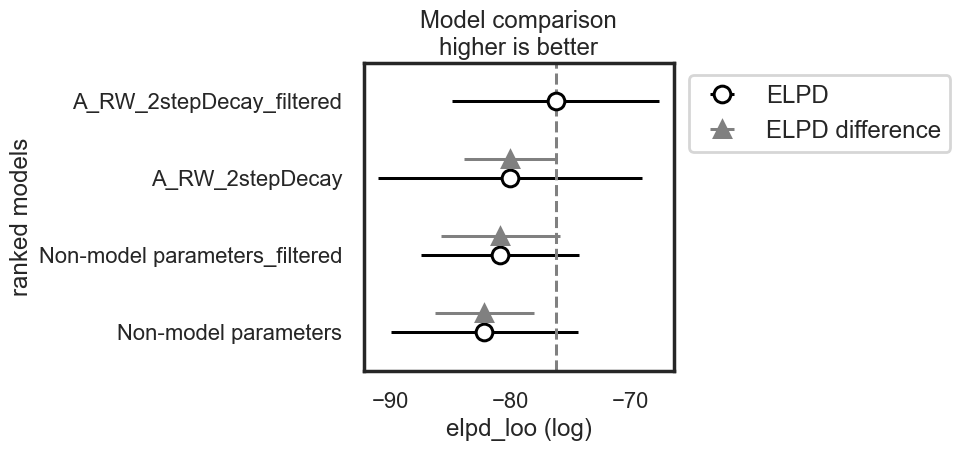

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df_compare = az.compare(bambi_cannabis_model_dict, ic='loo')
    display(df_compare)
    az.plot_compare(df_compare, insample_dev=False, plot_ic_diff=True, figsize=(4, 4));

In [ ]:
# Combination of model and non-model parameters GLM
# Only for best performing computational model above (A_RWSep_1stepDecay)
best_perf_comp_model = best_models['cannabis'][0]
model_name = 'combined'

# Subset of data for model in the addictive cue block
_model_df = master_df.loc[
    (master_df['Group']=='cannabis') &
    (master_df['Model']==best_perf_comp_model) & 
    (master_df['Block']=='other')
].dropna(how='all', axis=1).dropna(how='any', axis=0, subset=dependent_var).reset_index(drop=True)

# Normalize the data
model_param_names = []
for param in (full_param_list+full_nonmodel_param_list+full_demo_list):
    if param in _model_df.columns:
        model_param_names.append(param)
_columns_to_use = [dependent_var] + model_param_names
_numerics = _model_df[_columns_to_use].select_dtypes(include=[np.number])
_nonnumerics = _model_df[_columns_to_use].select_dtypes(exclude=[np.number])
scaler = StandardScaler()
_normed_model_df = pd.concat([
    pd.DataFrame(
        scaler.fit_transform(_numerics), 
        columns=_numerics.columns
    ),
    _nonnumerics
], axis=1)

# Add dummy variables for categorical demographics
normed_model_df = pd.get_dummies(_normed_model_df, columns=['DEMO_sex', 'DEMO_edu'])
normed_model_df.columns = normed_model_df.columns.str.replace(' ', '_')

# Build the model equation
equation = dependent_var + ' ~ '
model_param_names = []
for param in full_param_list:
    if param in normed_model_df.columns:
        equation += param + ' + '
        model_param_names.append(param)
for param in full_nonmodel_param_list:
    if param in normed_model_df.columns:
        equation += param + ' + '
        model_param_names.append(param)
for demo in full_demo_list:
    for col in normed_model_df.columns:
        if demo in col:
            equation += col + ' + '
            model_param_names.append(col)
    # if demo in model_df.columns:
    #     if demo=='DEMO_age':
    #         equation += demo + ' + '
    #     else:
    #         equation += 'C(' + demo + ') + '
    #     model_param_names.append(demo)
equation = equation[:-3]
print(f'Number {i}:\t{model_name}\t{equation}')

# Fit the model with statsmodels
sm_results = smf.ols(formula=equation, data=normed_model_df).fit()
display(sm_results.summary())
statsmodels_cannabis_model_dict[model_name] = sm_results

if bambi_flag:
    # Fit the model with bambi
    bmb_model = bmb.Model(equation, normed_model_df, family=family)
    bmb_results = bmb_model.fit()
    ppc = bmb_model.predict(bmb_results, kind='pps')
    bambi_cannabis_model_dict[model_name] = bmb_results

# Filtering of the model (remove predictors with significance < 0.05)
filtered_equation = equation
least_sig = 1
while least_sig > sig_threshold:
    _sm_results = smf.ols(formula=filtered_equation, data=normed_model_df).fit()

    x = pd.read_html(_sm_results.summary().tables[1].as_html())[0]
    y = x.iloc[0].astype(str)
    y[0] = 'Predictor'
    x.columns = y
    x = x.iloc[1:]
    x = pd.concat([
        x['Predictor'],
        x[[elem for elem in x.columns if 'Predictor' not in elem]].astype(str).astype(float)
    ], axis=1)
    x = x[x['Predictor']!='Intercept']
    least_sig = x.sort_values(by='P>|t|', ascending=False)['P>|t|'].values[0]
    predictors = [elem for elem in x.sort_values(by='P>|t|', ascending=False)['Predictor'].values.astype(str) if 'Intercept' not in elem]
    if least_sig > sig_threshold:
        filtered_equation = dependent_var + ' ~ ' + ' + '.join(predictors[1:])
    else:
        filtered_equation = dependent_var + ' ~ ' + ' + '.join(predictors)
print(f'Number {i}:\t{model_name}\t{filtered_equation}')

# Fit the filtered model with statsmodels
filtered_sm_results = smf.ols(formula=filtered_equation, data=normed_model_df).fit()
display(filtered_sm_results.summary())
statsmodels_cannabis_model_dict[f'{model_name}_filtered'] = filtered_sm_results

if bambi_flag:
    # Fit the filtered model with bambi
    filtered_bmb_model = bmb.Model(filtered_equation, normed_model_df, family=family)
    filtered_bmb_results = filtered_bmb_model.fit()
    filtered_ppc = filtered_bmb_model.predict(filtered_bmb_results, kind='pps')
    bambi_cannabis_model_dict[f'{model_name}_filtered'] = filtered_bmb_results



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [ ]:
performance_df = pd.DataFrame(columns=['Model', 'R2', 'R2_adj', 'AIC', 'BIC'])
for model in statsmodels_cannabis_model_dict:
    sm_results = statsmodels_cannabis_model_dict[model]
    performance_df = pd.concat([
        performance_df,
        pd.DataFrame({
            'Model': [model],
            'R2': [sm_results.rsquared],
            'R2_adj': [sm_results.rsquared_adj],
            'AIC': [sm_results.aic],
            'BIC': [sm_results.bic]
        })
    ], axis=0)
performance_df = performance_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
performance_df

Model        R2    R2_adj         AIC         BIC
0              combined_filtered  0.461725  0.422578  143.109454  153.581177
1                       combined  0.624222  0.484398  145.547210  181.151068
2       A_RW_2stepDecay_filtered  0.408843  0.365850  148.732202  159.203925
3                A_RW_2stepDecay  0.522723  0.400865  151.893140  179.119619
4  Non-model parameters_filtered  0.256146  0.230046  158.517995  164.801028
5           Non-model parameters  0.407748  0.301143  158.843225  179.786671

In [ ]:
statsmodels_cannabis_model_dict['combined_filtered'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          CAST_Cannabis   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     11.79
Date:                Tue, 28 Feb 2023   Prob (F-statistic):           5.49e-07
Time:                        10:53:55   Log-Likelihood:                -66.555
No. Observations:                  60   AIC:                             143.1
Df Residuals:                      55   BIC:                             153.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             3.469e-18      0.099   3.51e-17      1.000      -0.198       0.198
alpha                   -0.4237      0.152     -2.785      0.007      -0.729      -0.119
weight_one              -0.4070      0.111     -3.656      0.001      -0.630      -0.184
mod                      0.5357      0.147      3.646      0.001       0.241       0.830
mean_craving_ratings     0.6547      0.133      4.941      0.000       0.389       0.920
==============================================================================
Omnibus:                       14.231   Durbin-Watson:                   2.441
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               19.358
Skew:                           0.879   Prob(JB):                     6.26e-05
Kurtosis:                       5.157   Cond. No.                         3.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

rank   elpd_loo      p_loo  elpd_diff  \
combined_filtered                 0 -72.766336   5.342687   0.000000   
A_RW_2stepDecay_filtered          1 -76.239276   6.146268   3.472940   
combined                          2 -77.597899  16.799078   4.831563   
A_RW_2stepDecay                   3 -80.070336  14.461266   7.304000   
Non-model parameters_filtered     4 -80.868704   4.678837   8.102368   
Non-model parameters              5 -82.179813  10.951331   9.413477   

                                     weight         se       dse  warning  \
combined_filtered              7.157083e-01   8.254363  0.000000    False   
A_RW_2stepDecay_filtered       0.000000e+00   8.638662  1.861711     True   
combined                       1.688785e-01   9.337375  4.035202     True   
A_RW_2stepDecay                0.000000e+00  11.008982  4.516700     True   
Non-model parameters_filtered  1.154132e-01   6.603211  5.384607    False   
Non-model parameters           6.006307e-14   7.771880  4.398369     True   

                              scale  
combined_filtered               log  
A_RW_2stepDecay_filtered        log  
combined                        log  
A_RW_2stepDecay                 log  
Non-model parameters_filtered   log  
Non-model parameters            log

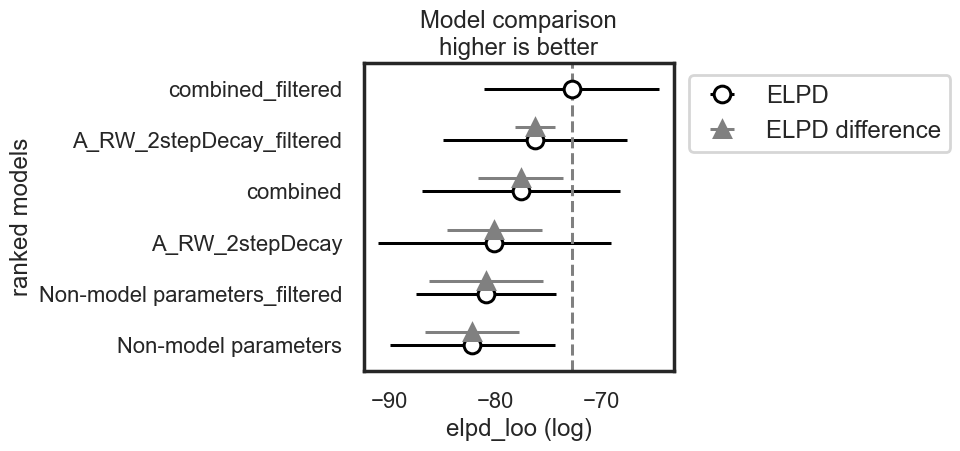

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df_compare = az.compare(bambi_cannabis_model_dict, ic='loo')
    display(df_compare)
    az.plot_compare(df_compare, insample_dev=False, plot_ic_diff=True, figsize=(4, 4));

Calculate R2 for all regressions

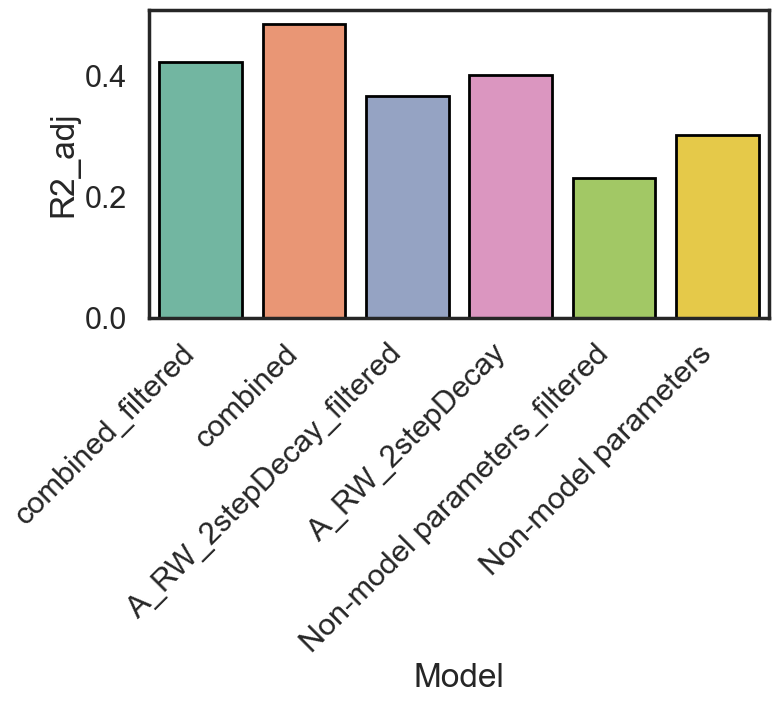

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x='Model', y='R2_adj', data=performance_df, dodge=False, ax=ax, palette='Set2', edgecolor='black', linewidth=2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');

Identify the most predictive variables

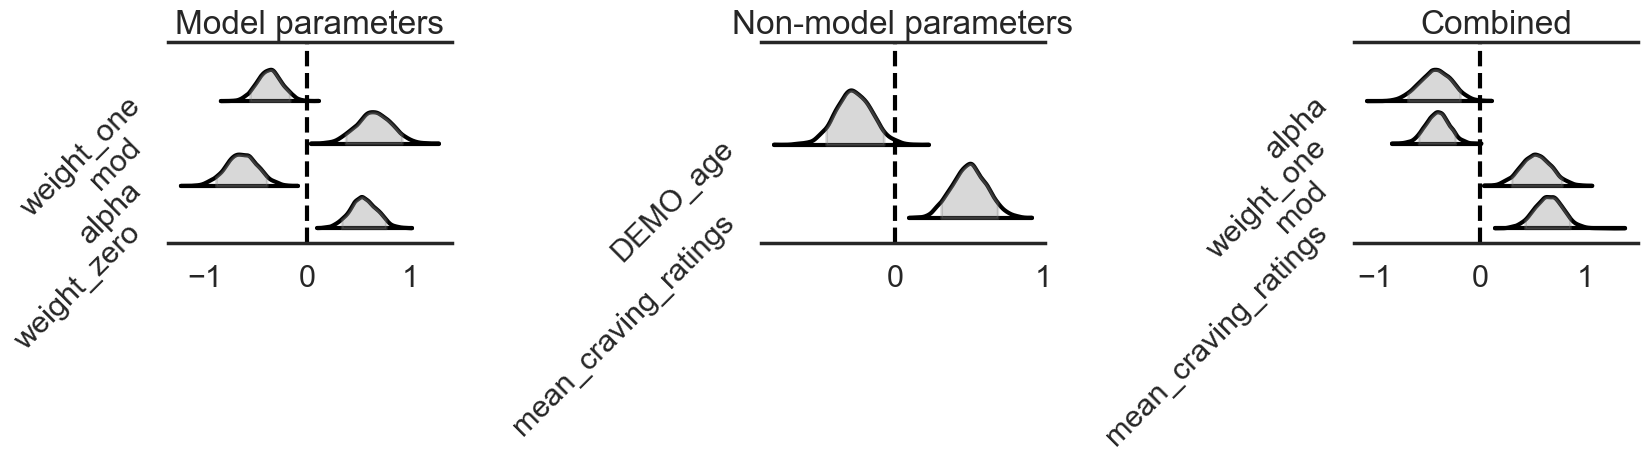

In [ ]:
fig, ax = plt.subplots(figsize=(17, 5), ncols=3, nrows=1)
i_count = -1
for i, model_name in enumerate(bambi_cannabis_model_dict.keys()):
    if 'filtered' not in model_name:
        continue
    if i>8:
        break
    else:
        i_count += 1
        if 'Non-model parameters' in model_name:
            ax[i_count].set_title('Non-model parameters')
        elif 'combined' in model_name:
            ax[i_count].set_title('Combined')
        else:
            ax[i_count].set_title('Model parameters')
    vars = []
    summary_model_df = az.summary(bambi_cannabis_model_dict[model_name])
    candidate_vars = np.array([
        elem for elem in az.summary(bambi_cannabis_model_dict[model_name]).index if elem in (full_param_list + full_demo_list + full_nonmodel_param_list)
    ])
    for var in candidate_vars:
        if np.abs(summary_model_df.loc[var]['hdi_3%'] + summary_model_df.loc[var]['hdi_97%']) > np.abs(summary_model_df.loc[var]['hdi_97%']):
            vars.append(var)
    az.plot_forest(
        bambi_cannabis_model_dict[model_name], 
        var_names=vars,
        figsize=(5,4), combined=True, 
        kind='ridgeplot', ridgeplot_alpha=0.3, 
        hdi_prob=0.89,
        # ridgeplot_quantiles=[.25, .5, .75],
        ridgeplot_overlap=1, 
        ridgeplot_truncate=False,
        colors='gray',
        ax=ax[i_count],
    )
    # plt.xlim(-15, 15)
    # ax[i_count].set_title(model_name)
    ax[i_count].axvline(0, color='k', linestyle='--')
    ax[i_count].set_yticklabels(ax[i_count].get_yticklabels(), rotation=45, ha='right')
plt.tight_layout()

Visualize the posterior predictive distributions for the best model

Text(0.05, 0.95, 'Non-model parameters')

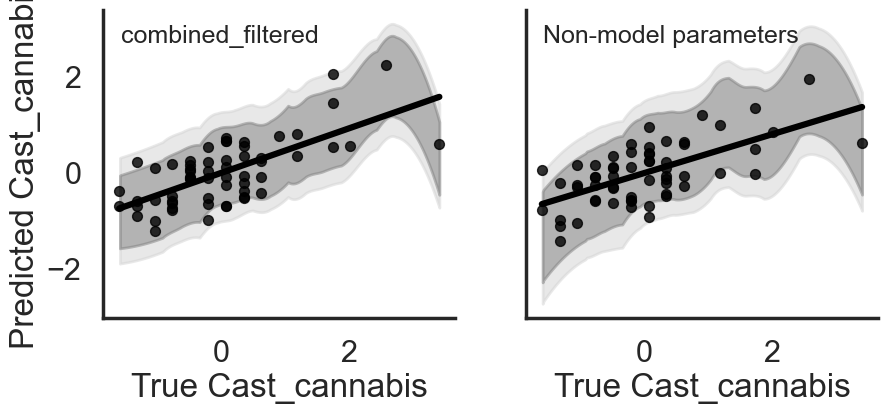

In [ ]:
best_model_name = performance_df.iloc[0]['Model']
best_model_results = bambi_cannabis_model_dict[best_model_name]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)
az.plot_hdi(
    best_model_results.observed_data[dependent_var].values,
    best_model_results.posterior_predictive[dependent_var].values,
    hdi_prob=0.84, smooth=True, color='lightgray', ax=ax[0]
)
az.plot_hdi(
    best_model_results.observed_data[dependent_var].values,
    best_model_results.posterior_predictive[dependent_var].values,
    hdi_prob=0.68, smooth=True, color='gray', ax=ax[0]
)
sns.regplot(
    x=best_model_results.observed_data[dependent_var].values,
    y=np.vstack(best_model_results.posterior_predictive[dependent_var].values).mean(axis=0),
    color='black', ci=0, ax=ax[0], scatter_kws=dict(s=50)
)
az.plot_hdi(
    best_model_results.observed_data[dependent_var].values,
    bambi_cannabis_model_dict['Non-model parameters'].posterior_predictive[dependent_var].values,
    hdi_prob=0.84, smooth=True, color='lightgray', ax=ax[1]
)
az.plot_hdi(
    best_model_results.observed_data[dependent_var].values,
    bambi_cannabis_model_dict['Non-model parameters'].posterior_predictive[dependent_var].values,
    hdi_prob=0.68, smooth=True, color='gray', ax=ax[1]
)
sns.regplot(
    x=best_model_results.observed_data[dependent_var].values,
    y=np.vstack(bambi_cannabis_model_dict['Non-model parameters'].posterior_predictive[dependent_var].values).mean(axis=0),
    color='black', ci=0, ax=ax[1], scatter_kws=dict(s=50)
)
sns.despine()
ax[0].set_xlabel(f'True {dependent_var.capitalize()}')
ax[0].set_ylabel(f'Predicted {dependent_var.capitalize()}')
ax[1].set_xlabel(f'True {dependent_var.capitalize()}')
ax[0].text(0.05, 0.95, f'{best_model_name}', transform=ax[0].transAxes, va='top', ha='left', fontsize=18)
ax[1].text(0.05, 0.95, 'Non-model parameters', transform=ax[1].transAxes, va='top', ha='left', fontsize=18)

Calculate the significance of improvement in predictions by using computational parameters

In [ ]:
predicted = np.hstack((
    np.vstack(best_model_results.posterior_predictive[dependent_var].values).mean(axis=0),
    np.vstack(bambi_cannabis_model_dict['Non-model parameters_filtered'].posterior_predictive[dependent_var].values).mean(axis=0)
))
true = np.hstack((
    best_model_results.observed_data[dependent_var].values,
    best_model_results.observed_data[dependent_var].values
))
model_labels = np.hstack((
    # np.repeat(r2_df.loc[0]['Model'], len(sample_model_df)),
    np.repeat(1, len(best_model_results.observed_data[dependent_var].values)),
    # np.repeat('model-free', len(sample_model_df))
    np.repeat(0, len(best_model_results.observed_data[dependent_var].values))
))
cannabis_predict_df = pd.DataFrame({
    'predicted': predicted,
    'true': true,
    'model': model_labels
})

equation = 'predicted ~ true * model'
print(equation)
cannabis_pred_model = bmb.Model(equation, cannabis_predict_df)
cannabis_results = cannabis_pred_model.fit()
# ppc_alt = model_alt.predict(results_alt, kind='pps')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


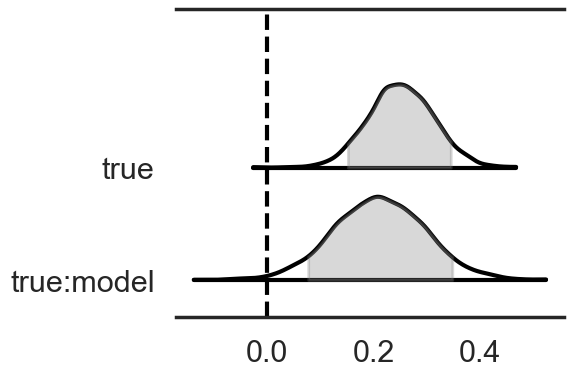

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
az.plot_forest(
    cannabis_results, 
    filter_vars='regex',
    var_names=['^true'],
    figsize=(5,2), combined=True, 
    kind='ridgeplot', ridgeplot_alpha=0.3, 
    hdi_prob=0.89,
    # ridgeplot_quantiles=[.25, .5, .75],
    ridgeplot_overlap=1, 
    ridgeplot_truncate=False,
    colors='gray',
    ax=ax,
)
ax.axvline(0, color='k', linestyle='--')

In [ ]:
smf.ols(equation, cannabis_predict_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              predicted   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     24.93
Date:                Tue, 28 Feb 2023   Prob (F-statistic):           1.61e-12
Time:                        10:20:45   Log-Likelihood:                -78.247
No. Observations:                 120   AIC:                             164.5
Df Residuals:                     116   BIC:                             175.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0046      0.061      0.075      0.941      -0.116       0.125
true           0.2521      0.061      4.134      0.000       0.131       0.373
model         -0.0024      0.086     -0.028      0.978      -0.173       0.168
true:model     0.2111      0.086      2.447      0.016       0.040       0.382
==============================================================================
Omnibus:                        1.848   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.397   Jarque-Bera (JB):                1.410
Skew:                          -0.020   Prob(JB):                        0.494
Kurtosis:                       2.470   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.05, 0.84, 'Model-free')

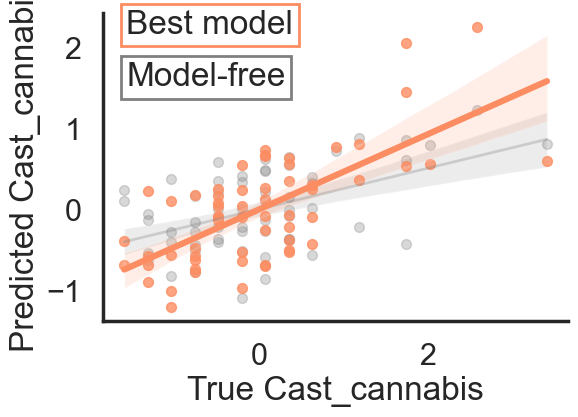

In [ ]:
best_model_results = bambi_cannabis_model_dict[best_model_name]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), sharey=True)
sns.regplot(
    x=best_model_results.observed_data[dependent_var].values,
    y=np.vstack(bambi_cannabis_model_dict['Non-model parameters_filtered'].posterior_predictive[dependent_var].values).mean(axis=0),
    color='gray', ci=89, ax=ax, scatter_kws=dict(s=50, alpha=0.3), line_kws=dict(lw=2, alpha=0.3)
)
sns.regplot(
    x=best_model_results.observed_data[dependent_var].values,
    y=np.vstack(best_model_results.posterior_predictive[dependent_var].values).mean(axis=0),
    color=sns.palettes.color_palette('Set2')[1], ci=89, ax=ax, scatter_kws=dict(s=50)
)
sns.despine()
ax.set_xlabel(f'True {dependent_var.capitalize()}')
ax.set_ylabel(f'Predicted {dependent_var.capitalize()}')
ax.text(0.05, 1.01, f'Best model', transform=ax.transAxes, va='top', ha='left', bbox=dict(edgecolor=sns.palettes.color_palette('Set2')[1], facecolor='white'))
ax.text(0.05, 0.84, 'Model-free', transform=ax.transAxes, va='top', ha='left', bbox=dict(edgecolor='gray', facecolor='white'))

### Binge eating

In [ ]:
dependent_var = 'edeq_global_x'

full_demo_list = ['DEMO_age', 'DEMO_sex', 'DEMO_edu']

full_param_list = [
    'alpha', 'alpha_pos', 'alpha_neg',
    'beta',
    'weight_zero', 'weight_one', 'weight_two',
    'weight_three', 'weight_four', 'weight_five',
    'weight_six', 'cec_weight', 'mod',
    'bias', 'eps',
]

full_nonmodel_param_list = ['mean_craving_ratings', 'std_craving_ratings', 'mean_mood_ratings', 'std_mood_ratings']

family = 'gaussian'

#### Standard statsmodels/bambi GLM 

In [ ]:
# Set bambi flag on or off
bambi_flag = True

# Set significance threshold for stepwise regression
sig_threshold = 0.05

# Initialize empty dicts
statsmodels_binge_model_dict = {}
bambi_binge_model_dict = {}

In [ ]:
# Computational model parameters GLM
for i, model_name in enumerate(sorted(best_models['binge'])):
    # Subset of data for model in the addictive cue block
    _model_df = master_df.loc[
        (master_df['Group']=='binge') &
        (master_df['Model']==model_name) & 
        (master_df['Block']=='other')
    ].dropna(how='all', axis=1).dropna(how='any', axis=0, subset=dependent_var).reset_index(drop=True)

    # Normalize the data
    model_param_names = []
    for param in (full_param_list+full_demo_list):
        if param in _model_df.columns:
            model_param_names.append(param)
    _columns_to_use = [dependent_var] + model_param_names
    _numerics = _model_df[_columns_to_use].select_dtypes(include=[np.number])
    _nonnumerics = _model_df[_columns_to_use].select_dtypes(exclude=[np.number])
    scaler = StandardScaler()
    _normed_model_df = pd.concat([
        pd.DataFrame(
            scaler.fit_transform(_numerics), 
            columns=_numerics.columns
        ),
        _nonnumerics
    ], axis=1)

    # Add dummy variables for categorical demographics
    normed_model_df = pd.get_dummies(_normed_model_df, columns=['DEMO_sex', 'DEMO_edu'])
    normed_model_df.columns = normed_model_df.columns.str.replace(' ', '_')
    
    # Build the model equation
    equation = dependent_var + ' ~ '
    model_param_names = []
    for param in full_param_list:
        if param in normed_model_df.columns:
            equation += param + ' + '
            model_param_names.append(param)
    for demo in full_demo_list:
        for col in normed_model_df.columns:
            if demo in col:
                equation += col + ' + '
                model_param_names.append(col)
    equation = equation[:-3]
    print(f'Number {i}:\t{model_name}\t{equation}')

    # Fit the model with statsmodels
    sm_results = smf.ols(formula=equation, data=normed_model_df).fit()
    display(sm_results.summary())
    statsmodels_binge_model_dict[model_name] = sm_results

    if bambi_flag:
        # Fit the model with bambi
        bmb_model = bmb.Model(equation, normed_model_df, family=family)
        bmb_results = bmb_model.fit()
        ppc = bmb_model.predict(bmb_results, kind='pps')
        bambi_binge_model_dict[model_name] = bmb_results
    
    # Filtering of the model (remove predictors with significance < 0.05)
    filtered_equation = equation
    least_sig = 1
    failed = False
    while least_sig > sig_threshold:
        try:
            _sm_results = smf.ols(formula=filtered_equation, data=normed_model_df).fit()
        except PatsyError:
            failed = True
            print(f'Model {model_name} failed to fit with filtered equation: {filtered_equation}')
            break

        x = pd.read_html(_sm_results.summary().tables[1].as_html())[0]
        y = x.iloc[0].astype(str)
        y[0] = 'Predictor'
        x.columns = y
        x = x.iloc[1:]
        x = pd.concat([
            x['Predictor'],
            x[[elem for elem in x.columns if 'Predictor' not in elem]].astype(str).astype(float)
        ], axis=1)
        x = x[x['Predictor']!='Intercept']
        least_sig = x.sort_values(by='P>|t|', ascending=False)['P>|t|'].values[0]
        predictors = [elem for elem in x.sort_values(by='P>|t|', ascending=False)['Predictor'].values.astype(str) if 'Intercept' not in elem]
        if least_sig > sig_threshold:
            filtered_equation = dependent_var + ' ~ ' + ' + '.join(predictors[1:])
        else:
            filtered_equation = dependent_var + ' ~ ' + ' + '.join(predictors)
    print(f'Number {i}:\t{model_name}\t{filtered_equation}')

    if not failed:
        # Fit the filtered model with statsmodels
        filtered_sm_results = smf.ols(formula=filtered_equation, data=normed_model_df).fit()
        display(filtered_sm_results.summary())
        statsmodels_binge_model_dict[f'{model_name}_filtered'] = filtered_sm_results

        if bambi_flag:
            # Fit the filtered model with bambi
            filtered_bmb_model = bmb.Model(filtered_equation, normed_model_df, family=family)
            filtered_bmb_results = filtered_bmb_model.fit()
            filtered_ppc = filtered_bmb_model.predict(filtered_bmb_results, kind='pps')
            bambi_binge_model_dict[f'{model_name}_filtered'] = filtered_bmb_results



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


In [ ]:
# Non-model parameter GLM
model_name = 'Non-model parameters'

# Subset of data for model in the addictive cue block
_model_df = master_df.loc[
    (master_df['Group']=='binge') &
    (master_df['Model']=='RWCEC') & 
    (master_df['Block']=='other')
].dropna(how='all', axis=1).dropna(how='any', axis=0, subset=dependent_var).reset_index(drop=True)

# Normalize the data
model_param_names = []
for param in (full_nonmodel_param_list+full_demo_list):
    if param in _model_df.columns:
        model_param_names.append(param)
_columns_to_use = [dependent_var] + model_param_names
_numerics = _model_df[_columns_to_use].select_dtypes(include=[np.number])
_nonnumerics = _model_df[_columns_to_use].select_dtypes(exclude=[np.number])
scaler = StandardScaler()
_normed_model_df = pd.concat([
    pd.DataFrame(
        scaler.fit_transform(_numerics), 
        columns=_numerics.columns
    ),
    _nonnumerics
], axis=1)

# Add dummy variables for categorical demographics
normed_model_df = pd.get_dummies(_normed_model_df, columns=['DEMO_sex', 'DEMO_edu'])
normed_model_df.columns = normed_model_df.columns.str.replace(' ', '_')

# Build the model equation
equation = dependent_var + ' ~ '
model_param_names = []
for param in full_nonmodel_param_list:
    if param in normed_model_df.columns:
        equation += param + ' + '
        model_param_names.append(param)
for demo in full_demo_list:
    for col in normed_model_df.columns:
        if demo in col:
            equation += col + ' + '
            model_param_names.append(col)
equation = equation[:-3]
print(f'Number {i}:\t{model_name}\t{equation}')

# Fit the model with statsmodels
sm_results = smf.ols(formula=equation, data=normed_model_df).fit()
display(sm_results.summary())
statsmodels_binge_model_dict[model_name] = sm_results

if bambi_flag:
    # Fit the model with bambi
    bmb_model = bmb.Model(equation, normed_model_df, family=family)
    bmb_results = bmb_model.fit()
    ppc = bmb_model.predict(bmb_results, kind='pps')
    bambi_binge_model_dict[model_name] = bmb_results

# Filtering of the model (remove predictors with significance < 0.05)
filtered_equation = equation
least_sig = 1
failed = False
while least_sig > sig_threshold:
    try:
        _sm_results = smf.ols(formula=filtered_equation, data=normed_model_df).fit()
    except PatsyError:
        failed = True
        print(f'Model {model_name} failed to converge. No significant predictors found.')
        break

    x = pd.read_html(_sm_results.summary().tables[1].as_html())[0]
    y = x.iloc[0].astype(str)
    y[0] = 'Predictor'
    x.columns = y
    x = x.iloc[1:]
    x = pd.concat([
        x['Predictor'],
        x[[elem for elem in x.columns if 'Predictor' not in elem]].astype(str).astype(float)
    ], axis=1)
    x = x[x['Predictor']!='Intercept']
    least_sig = x.sort_values(by='P>|t|', ascending=False)['P>|t|'].values[0]
    predictors = [elem for elem in x.sort_values(by='P>|t|', ascending=False)['Predictor'].values.astype(str) if 'Intercept' not in elem]
    if least_sig > sig_threshold:
        filtered_equation = dependent_var + ' ~ ' + ' + '.join(predictors[1:])
    else:
        filtered_equation = dependent_var + ' ~ ' + ' + '.join(predictors)
print(f'Number {i}:\t{model_name}\t{filtered_equation}')

if not failed:
    # Fit the filtered model with statsmodels
    filtered_sm_results = smf.ols(formula=filtered_equation, data=normed_model_df).fit()
    display(filtered_sm_results.summary())
    statsmodels_binge_model_dict[f'{model_name}_filtered'] = filtered_sm_results

    if bambi_flag:
        # Fit the filtered model with bambi
        filtered_bmb_model = bmb.Model(filtered_equation, normed_model_df, family=family)
        filtered_bmb_results = filtered_bmb_model.fit()
        filtered_ppc = filtered_bmb_model.predict(filtered_bmb_results, kind='pps')
        bambi_binge_model_dict[f'{model_name}_filtered'] = filtered_bmb_results



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [ ]:
performance_df = pd.DataFrame(columns=['Model', 'R2', 'R2_adj', 'AIC', 'BIC'])
for model in statsmodels_binge_model_dict:
    sm_results = statsmodels_binge_model_dict[model]
    performance_df = pd.concat([
        performance_df,
        pd.DataFrame({
            'Model': [model],
            'R2': [sm_results.rsquared],
            'R2_adj': [sm_results.rsquared_adj],
            'AIC': [sm_results.aic],
            'BIC': [sm_results.bic]
        })
    ], axis=0)
performance_df = performance_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
performance_df

Model        R2    R2_adj         AIC         BIC
0  A_Rew_RWSep_2stepMean_filtered  0.237298  0.188872  184.555291  195.652830
1   Non-model parameters_filtered  0.062685  0.048483  192.573611  197.012626
2           A_Rew_RWSep_2stepMean  0.300134  0.115264  198.708692  232.001307
3            Non-model parameters  0.205439  0.066042  199.337974  223.752558

rank    elpd_loo      p_loo  elpd_diff  \
A_Rew_RWSep_2stepMean_filtered     0  -93.341409   5.379472   0.000000   
Non-model parameters_filtered      1  -97.329579   2.847199   3.988170   
A_Rew_RWSep_2stepMean              2 -102.756828  14.741246   9.415419   
Non-model parameters               3 -103.220749  12.667698   9.879341   

                                  weight        se       dse  warning scale  
A_Rew_RWSep_2stepMean_filtered  0.892395  4.495293  0.000000    False   log  
Non-model parameters_filtered   0.107605  5.233059  3.276091    False   log  
A_Rew_RWSep_2stepMean           0.000000  4.897350  2.073939     True   log  
Non-model parameters            0.000000  4.880784  3.742846     True   log

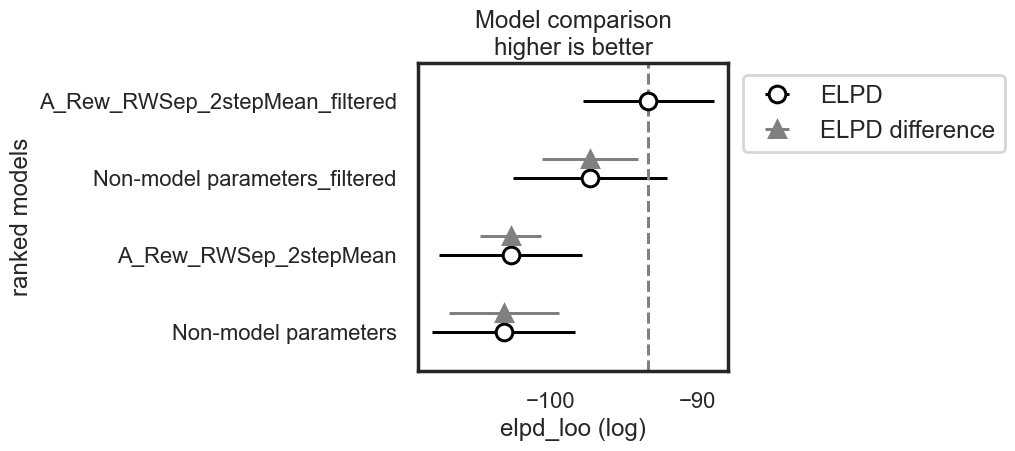

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df_compare = az.compare(bambi_binge_model_dict, ic='loo')
    display(df_compare)
    az.plot_compare(df_compare, insample_dev=False, plot_ic_diff=True, figsize=(4, 4));

In [ ]:
# Combination of model and non-model parameters GLM
# Only for best performing computational model above (A_RWSep_1stepDecay)
best_perf_comp_model = best_models['binge'][0]
model_name = 'combined'

# Subset of data for model in the addictive cue block
_model_df = master_df.loc[
    (master_df['Group']=='binge') &
    (master_df['Model']==best_perf_comp_model) & 
    (master_df['Block']=='other')
].dropna(how='all', axis=1).dropna(how='any', axis=0, subset=dependent_var).reset_index(drop=True)

# Normalize the data
model_param_names = []
for param in (full_param_list+full_nonmodel_param_list+full_demo_list):
    if param in _model_df.columns:
        model_param_names.append(param)
_columns_to_use = [dependent_var] + model_param_names
_numerics = _model_df[_columns_to_use].select_dtypes(include=[np.number])
_nonnumerics = _model_df[_columns_to_use].select_dtypes(exclude=[np.number])
scaler = StandardScaler()
_normed_model_df = pd.concat([
    pd.DataFrame(
        scaler.fit_transform(_numerics), 
        columns=_numerics.columns
    ),
    _nonnumerics
], axis=1)

# Add dummy variables for categorical demographics
normed_model_df = pd.get_dummies(_normed_model_df, columns=['DEMO_sex', 'DEMO_edu'])
normed_model_df.columns = normed_model_df.columns.str.replace(' ', '_')

# Build the model equation
equation = dependent_var + ' ~ '
model_param_names = []
for param in full_param_list:
    if param in normed_model_df.columns:
        equation += param + ' + '
        model_param_names.append(param)
for param in full_nonmodel_param_list:
    if param in normed_model_df.columns:
        equation += param + ' + '
        model_param_names.append(param)
for demo in full_demo_list:
    for col in normed_model_df.columns:
        if demo in col:
            equation += col + ' + '
            model_param_names.append(col)
equation = equation[:-3]
print(f'Number {i}:\t{model_name}\t{equation}')

# Fit the model with statsmodels
sm_results = smf.ols(formula=equation, data=normed_model_df).fit()
display(sm_results.summary())
statsmodels_binge_model_dict[model_name] = sm_results

if bambi_flag:
    # Fit the model with bambi
    bmb_model = bmb.Model(equation, normed_model_df, family=family)
    bmb_results = bmb_model.fit()
    ppc = bmb_model.predict(bmb_results, kind='pps')
    bambi_binge_model_dict[model_name] = bmb_results

# Filtering of the model (remove predictors with significance < 0.05)
filtered_equation = equation
least_sig = 1
failed = False
while least_sig > sig_threshold:
    try:
        _sm_results = smf.ols(formula=filtered_equation, data=normed_model_df).fit()
    except PatsyError:
        failed = True
        print(f'Model {model_name} failed to converge. No significant predictors found.')
        break

    x = pd.read_html(_sm_results.summary().tables[1].as_html())[0]
    y = x.iloc[0].astype(str)
    y[0] = 'Predictor'
    x.columns = y
    x = x.iloc[1:]
    x = pd.concat([
        x['Predictor'],
        x[[elem for elem in x.columns if 'Predictor' not in elem]].astype(str).astype(float)
    ], axis=1)
    x = x[x['Predictor']!='Intercept']
    least_sig = x.sort_values(by='P>|t|', ascending=False)['P>|t|'].values[0]
    predictors = [elem for elem in x.sort_values(by='P>|t|', ascending=False)['Predictor'].values.astype(str) if 'Intercept' not in elem]
    if least_sig > sig_threshold:
        filtered_equation = dependent_var + ' ~ ' + ' + '.join(predictors[1:])
    else:
        filtered_equation = dependent_var + ' ~ ' + ' + '.join(predictors)
print(f'Number {i}:\t{model_name}\t{filtered_equation}')

if not failed:
    # Fit the filtered model with statsmodels
    filtered_sm_results = smf.ols(formula=filtered_equation, data=normed_model_df).fit()
    display(filtered_sm_results.summary())
    statsmodels_binge_model_dict[f'{model_name}_filtered'] = filtered_sm_results

    if bambi_flag:
        # Fit the filtered model with bambi
        filtered_bmb_model = bmb.Model(filtered_equation, normed_model_df, family=family)
        filtered_bmb_results = filtered_bmb_model.fit()
        filtered_ppc = filtered_bmb_model.predict(filtered_bmb_results, kind='pps')
        bambi_binge_model_dict[f'{model_name}_filtered'] = filtered_bmb_results



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [ ]:
performance_df = pd.DataFrame(columns=['Model', 'R2', 'R2_adj', 'AIC', 'BIC'])
for model in statsmodels_binge_model_dict:
    sm_results = statsmodels_binge_model_dict[model]
    performance_df = pd.concat([
        performance_df,
        pd.DataFrame({
            'Model': [model],
            'R2': [sm_results.rsquared],
            'R2_adj': [sm_results.rsquared_adj],
            'AIC': [sm_results.aic],
            'BIC': [sm_results.bic]
        })
    ], axis=0)
performance_df = performance_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
performance_df

Model        R2    R2_adj         AIC         BIC
0  A_Rew_RWSep_2stepMean_filtered  0.237298  0.188872  184.555291  195.652830
1               combined_filtered  0.237298  0.188872  184.555291  195.652830
2   Non-model parameters_filtered  0.062685  0.048483  192.573611  197.012626
3           A_Rew_RWSep_2stepMean  0.300134  0.115264  198.708692  232.001307
4                        combined  0.377372  0.148652  198.756793  240.927439
5            Non-model parameters  0.205439  0.066042  199.337974  223.752558

In [ ]:
statsmodels_binge_model_dict['A_Rew_RWSep_2stepMean_filtered'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          edeq_global_x   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     4.900
Date:                Tue, 28 Feb 2023   Prob (F-statistic):            0.00167
Time:                        10:58:46   Log-Likelihood:                -87.278
No. Observations:                  68   AIC:                             184.6
Df Residuals:                      63   BIC:                             195.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0572      0.077     -0.744      0.459      -0.211       0.096
beta               -0.2601      0.115     -2.252      0.028      -0.491      -0.029
alpha_pos          -0.2609      0.112     -2.320      0.024      -0.486      -0.036
DEMO_sex_Female     0.2633      0.112      2.347      0.022       0.039       0.487
DEMO_sex_Male      -0.3205      0.134     -2.389      0.020      -0.589      -0.052
DEMO_age            0.3497      0.116      3.022      0.004       0.118       0.581
==============================================================================
Omnibus:                        3.863   Durbin-Watson:                   1.673
Prob(Omnibus):                  0.145   Jarque-Bera (JB):                1.924
Skew:                          -0.002   Prob(JB):                        0.382
Kurtosis:                       2.176   Cond. No.                     7.78e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.76e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

rank    elpd_loo      p_loo  elpd_diff  \
A_Rew_RWSep_2stepMean_filtered     0  -93.341409   5.379472   0.000000   
combined_filtered                  1  -93.425758   5.518291   0.084349   
Non-model parameters_filtered      2  -97.329579   2.847199   3.988170   
A_Rew_RWSep_2stepMean              3 -102.756828  14.741246   9.415419   
Non-model parameters               4 -103.220749  12.667698   9.879341   
combined                           5 -105.310491  19.855731  11.969082   

                                      weight        se       dse  warning  \
A_Rew_RWSep_2stepMean_filtered  8.923019e-01  4.495293  0.000000    False   
combined_filtered               2.775558e-16  4.554540  0.085243    False   
Non-model parameters_filtered   1.076981e-01  5.233059  3.276091    False   
A_Rew_RWSep_2stepMean           2.669866e-14  4.897350  2.073939     True   
Non-model parameters            0.000000e+00  4.880784  3.742846     True   
combined                        5.584422e-14  5.344818  3.742616     True   

                               scale  
A_Rew_RWSep_2stepMean_filtered   log  
combined_filtered                log  
Non-model parameters_filtered    log  
A_Rew_RWSep_2stepMean            log  
Non-model parameters             log  
combined                         log

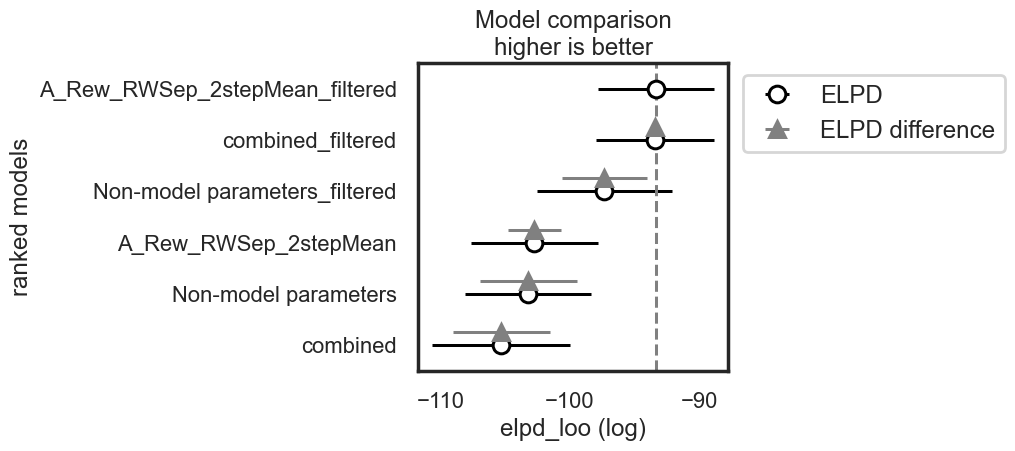

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df_compare = az.compare(bambi_binge_model_dict, ic='loo')
    display(df_compare)
    az.plot_compare(df_compare, insample_dev=False, plot_ic_diff=True, figsize=(4, 4));

Calculate R2 for all regressions

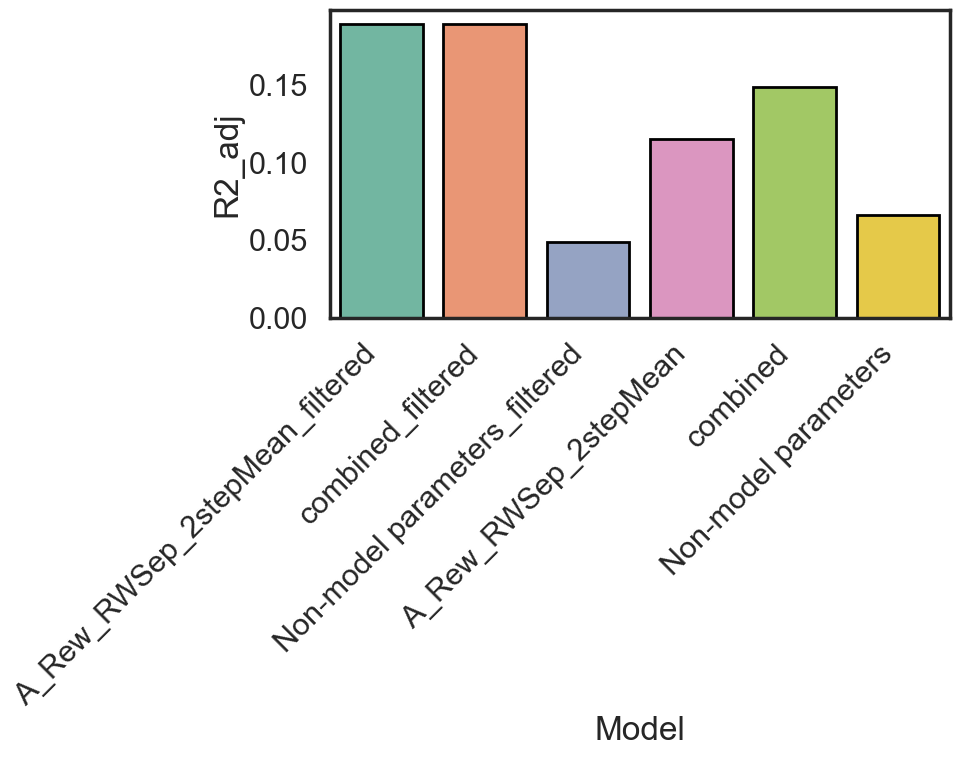

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x='Model', y='R2_adj', data=performance_df, dodge=False, ax=ax, palette='Set2', edgecolor='black', linewidth=2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');

Identify the most predictive variables

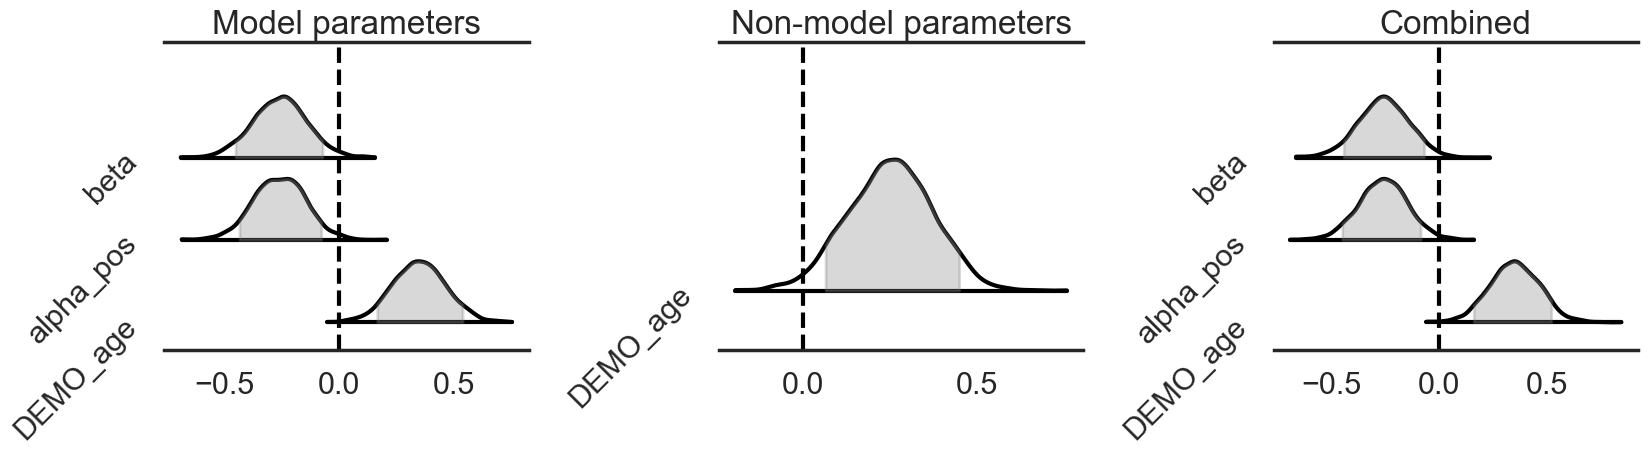

In [ ]:
fig, ax = plt.subplots(figsize=(17, 5), ncols=3, nrows=1)
i_count = -1
for i, model_name in enumerate(bambi_binge_model_dict.keys()):
    if 'filtered' not in model_name:
        continue
    if i>8:
        break
    else:
        i_count += 1
        if 'Non-model parameters' in model_name:
            ax[i_count].set_title('Non-model parameters')
        elif 'combined' in model_name:
            ax[i_count].set_title('Combined')
        else:
            ax[i_count].set_title('Model parameters')
    vars = []
    summary_model_df = az.summary(bambi_binge_model_dict[model_name])
    candidate_vars = np.array([
        elem for elem in az.summary(bambi_binge_model_dict[model_name]).index if elem in (full_param_list + full_demo_list + full_nonmodel_param_list)
    ])
    for var in candidate_vars:
        if np.abs(summary_model_df.loc[var]['hdi_3%'] + summary_model_df.loc[var]['hdi_97%']) > np.abs(summary_model_df.loc[var]['hdi_97%']):
            vars.append(var)
    az.plot_forest(
        bambi_binge_model_dict[model_name], 
        var_names=vars,
        figsize=(5,4), combined=True, 
        kind='ridgeplot', ridgeplot_alpha=0.3, 
        hdi_prob=0.89,
        # ridgeplot_quantiles=[.25, .5, .75],
        ridgeplot_overlap=1, 
        ridgeplot_truncate=False,
        colors='gray',
        ax=ax[i_count],
    )
    # plt.xlim(-15, 15)
    # ax[i_count].set_title(model_name)
    ax[i_count].axvline(0, color='k', linestyle='--')
    ax[i_count].set_yticklabels(ax[i_count].get_yticklabels(), rotation=45, ha='right')
plt.tight_layout()

Visualize the posterior predictive distributions for the best model

Text(0.05, 0.95, 'Non-model parameters')

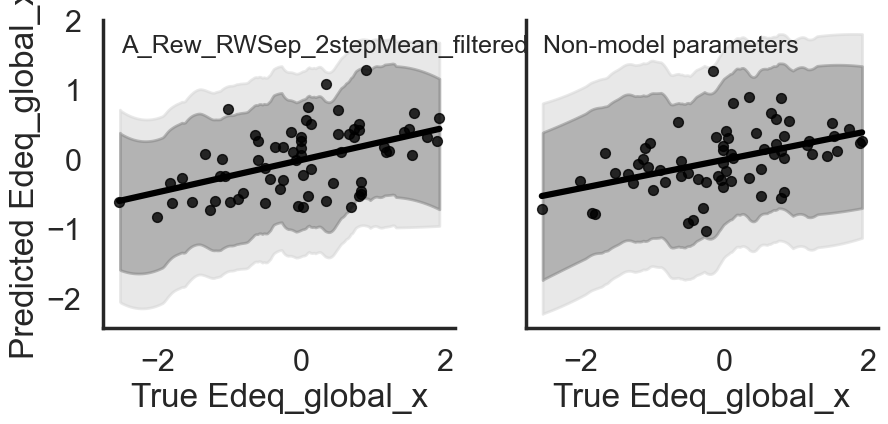

In [ ]:
best_model_name = performance_df.iloc[0]['Model']
best_model_results = bambi_binge_model_dict[best_model_name]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)
az.plot_hdi(
    best_model_results.observed_data[dependent_var].values,
    best_model_results.posterior_predictive[dependent_var].values,
    hdi_prob=0.84, smooth=True, color='lightgray', ax=ax[0]
)
az.plot_hdi(
    best_model_results.observed_data[dependent_var].values,
    best_model_results.posterior_predictive[dependent_var].values,
    hdi_prob=0.68, smooth=True, color='gray', ax=ax[0]
)
sns.regplot(
    x=best_model_results.observed_data[dependent_var].values,
    y=np.vstack(best_model_results.posterior_predictive[dependent_var].values).mean(axis=0),
    color='black', ci=0, ax=ax[0], scatter_kws=dict(s=50)
)
az.plot_hdi(
    best_model_results.observed_data[dependent_var].values,
    bambi_binge_model_dict['Non-model parameters'].posterior_predictive[dependent_var].values,
    hdi_prob=0.84, smooth=True, color='lightgray', ax=ax[1]
)
az.plot_hdi(
    best_model_results.observed_data[dependent_var].values,
    bambi_binge_model_dict['Non-model parameters'].posterior_predictive[dependent_var].values,
    hdi_prob=0.68, smooth=True, color='gray', ax=ax[1]
)
sns.regplot(
    x=best_model_results.observed_data[dependent_var].values,
    y=np.vstack(bambi_binge_model_dict['Non-model parameters'].posterior_predictive[dependent_var].values).mean(axis=0),
    color='black', ci=0, ax=ax[1], scatter_kws=dict(s=50)
)
sns.despine()
ax[0].set_xlabel(f'True {dependent_var.capitalize()}')
ax[0].set_ylabel(f'Predicted {dependent_var.capitalize()}')
ax[1].set_xlabel(f'True {dependent_var.capitalize()}')
ax[0].text(0.05, 0.95, f'{best_model_name}', transform=ax[0].transAxes, va='top', ha='left', fontsize=18)
ax[1].text(0.05, 0.95, 'Non-model parameters', transform=ax[1].transAxes, va='top', ha='left', fontsize=18)

Calculate the significance of improvement in predictions by using computational parameters

In [ ]:
predicted = np.hstack((
    np.vstack(best_model_results.posterior_predictive[dependent_var].values).mean(axis=0),
    np.vstack(bambi_binge_model_dict['Non-model parameters_filtered'].posterior_predictive[dependent_var].values).mean(axis=0)
))
true = np.hstack((
    best_model_results.observed_data[dependent_var].values,
    best_model_results.observed_data[dependent_var].values
))
model_labels = np.hstack((
    # np.repeat(r2_df.loc[0]['Model'], len(sample_model_df)),
    np.repeat(1, len(best_model_results.observed_data[dependent_var].values)),
    # np.repeat('model-free', len(sample_model_df))
    np.repeat(0, len(best_model_results.observed_data[dependent_var].values))
))
binge_predict_df = pd.DataFrame({
    'predicted': predicted,
    'true': true,
    'model': model_labels
})

equation = 'predicted ~ true * model'
print(equation)
binge_pred_model = bmb.Model(equation, binge_predict_df)
binge_results = binge_pred_model.fit()
# ppc_alt = model_alt.predict(results_alt, kind='pps')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


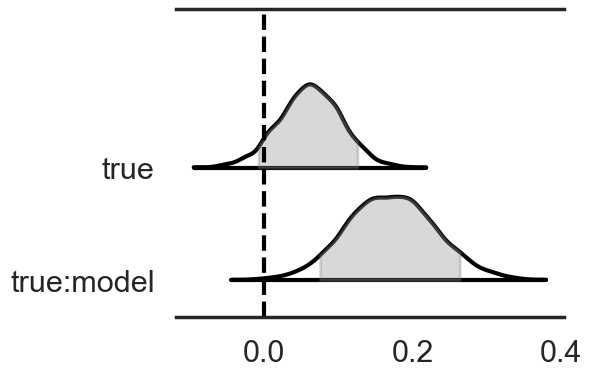

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
az.plot_forest(
    binge_results, 
    filter_vars='regex',
    var_names=['^true'],
    figsize=(5,2), combined=True, 
    kind='ridgeplot', ridgeplot_alpha=0.3, 
    hdi_prob=0.89,
    # ridgeplot_quantiles=[.25, .5, .75],
    ridgeplot_overlap=1, 
    ridgeplot_truncate=False,
    colors='gray',
    ax=ax,
)
ax.axvline(0, color='k', linestyle='--')

In [ ]:
smf.ols(equation, binge_predict_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              predicted   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     10.67
Date:                Tue, 28 Feb 2023   Prob (F-statistic):           2.49e-06
Time:                        10:24:51   Log-Likelihood:                -48.507
No. Observations:                 136   AIC:                             105.0
Df Residuals:                     132   BIC:                             116.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0010      0.043      0.023      0.982      -0.083       0.085
true           0.0612      0.043      1.438      0.153      -0.023       0.145
model         -0.0028      0.060     -0.046      0.963      -0.122       0.116
true:model     0.1717      0.060      2.853      0.005       0.053       0.291
==============================================================================
Omnibus:                        4.100   Durbin-Watson:                   1.634
Prob(Omnibus):                  0.129   Jarque-Bera (JB):                3.617
Skew:                           0.313   Prob(JB):                        0.164
Kurtosis:                       3.496   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.05, 0.84, 'Model-free')

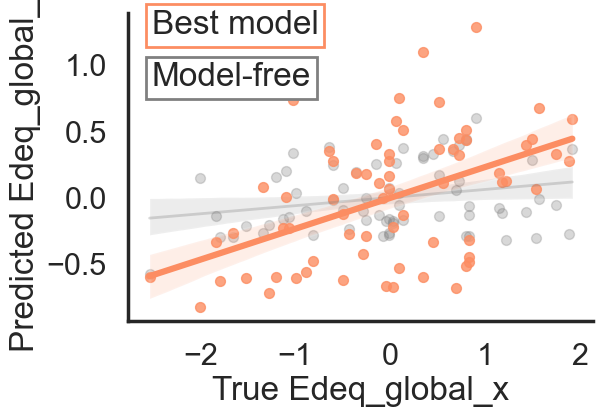

In [ ]:
best_model_results = bambi_binge_model_dict[best_model_name]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), sharey=True)
sns.regplot(
    x=best_model_results.observed_data[dependent_var].values,
    y=np.vstack(bambi_binge_model_dict['Non-model parameters_filtered'].posterior_predictive[dependent_var].values).mean(axis=0),
    color='gray', ci=89, ax=ax, scatter_kws=dict(s=50, alpha=0.3), line_kws=dict(lw=2, alpha=0.3)
)
sns.regplot(
    x=best_model_results.observed_data[dependent_var].values,
    y=np.vstack(best_model_results.posterior_predictive[dependent_var].values).mean(axis=0),
    color=sns.palettes.color_palette('Set2')[1], ci=89, ax=ax, scatter_kws=dict(s=50)
)
sns.despine()
ax.set_xlabel(f'True {dependent_var.capitalize()}')
ax.set_ylabel(f'Predicted {dependent_var.capitalize()}')
ax.text(0.05, 1.01, f'Best model', transform=ax.transAxes, va='top', ha='left', bbox=dict(edgecolor=sns.palettes.color_palette('Set2')[1], facecolor='white'))
ax.text(0.05, 0.84, 'Model-free', transform=ax.transAxes, va='top', ha='left', bbox=dict(edgecolor='gray', facecolor='white'))

### Social media

In [ ]:
dependent_var = 'smu_total'

full_demo_list = ['DEMO_age', 'DEMO_sex', 'DEMO_edu']

full_param_list = [
    'alpha', 'alpha_pos', 'alpha_neg',
    'beta',
    'weight_zero', 'weight_one', 'weight_two',
    'weight_three', 'weight_four', 'weight_five',
    'weight_six', 'cec_weight', 'mod',
    'bias', 'eps',
]

full_nonmodel_param_list = ['mean_craving_ratings', 'std_craving_ratings', 'mean_mood_ratings', 'std_mood_ratings']

family = 'gaussian'

#### Standard statsmodels/bambi GLM 

In [ ]:
# Set bambi flag on or off
bambi_flag = True

# Set significance threshold for stepwise regression
sig_threshold = 0.1

# Initialize empty dicts
statsmodels_social_model_dict = {}
bambi_social_model_dict = {}

In [ ]:
# Computational model parameters GLM
for i, model_name in enumerate(sorted(best_models['social'])):
    # Subset of data for model in the addictive cue block
    _model_df = master_df.loc[
        (master_df['Group']=='social') &
        (master_df['Model']==model_name) & 
        (master_df['Block']=='other')
    ].dropna(how='all', axis=1).dropna(how='any', axis=0, subset=dependent_var).reset_index(drop=True)

    # Normalize the data
    model_param_names = []
    for param in (full_param_list+full_demo_list):
        if param in _model_df.columns:
            model_param_names.append(param)
    _columns_to_use = [dependent_var] + model_param_names
    _numerics = _model_df[_columns_to_use].select_dtypes(include=[np.number])
    _nonnumerics = _model_df[_columns_to_use].select_dtypes(exclude=[np.number])
    scaler = StandardScaler()
    _normed_model_df = pd.concat([
        pd.DataFrame(
            scaler.fit_transform(_numerics), 
            columns=_numerics.columns
        ),
        _nonnumerics
    ], axis=1)

    # Add dummy variables for categorical demographics
    normed_model_df = pd.get_dummies(_normed_model_df, columns=['DEMO_sex', 'DEMO_edu'])
    normed_model_df.columns = normed_model_df.columns.str.replace(' ', '_')
    
    # Build the model equation
    equation = dependent_var + ' ~ '
    model_param_names = []
    for param in full_param_list:
        if param in normed_model_df.columns:
            equation += param + ' + '
            model_param_names.append(param)
    for demo in full_demo_list:
        for col in normed_model_df.columns:
            if demo in col:
                equation += col + ' + '
                model_param_names.append(col)
    equation = equation[:-3]
    print(f'Number {i}:\t{model_name}\t{equation}')

    # Fit the model with statsmodels
    sm_results = smf.ols(formula=equation, data=normed_model_df).fit()
    display(sm_results.summary())
    statsmodels_social_model_dict[model_name] = sm_results

    if bambi_flag:
        # Fit the model with bambi
        bmb_model = bmb.Model(equation, normed_model_df, family=family)
        bmb_results = bmb_model.fit()
        ppc = bmb_model.predict(bmb_results, kind='pps')
        bambi_social_model_dict[model_name] = bmb_results
    
    # Filtering of the model (remove predictors with significance < 0.05)
    filtered_equation = equation
    least_sig = 1
    failed = False
    while least_sig > sig_threshold:
        try:
            _sm_results = smf.ols(formula=filtered_equation, data=normed_model_df).fit()
        except:
            failed = True
            print(f'Model {model_name} failed to converge. No significant predictors.')
            break

        x = pd.read_html(_sm_results.summary().tables[1].as_html())[0]
        y = x.iloc[0].astype(str)
        y[0] = 'Predictor'
        x.columns = y
        x = x.iloc[1:]
        x = pd.concat([
            x['Predictor'],
            x[[elem for elem in x.columns if 'Predictor' not in elem]].astype(str).astype(float)
        ], axis=1)
        x = x[x['Predictor']!='Intercept']
        least_sig = x.sort_values(by='P>|t|', ascending=False)['P>|t|'].values[0]
        predictors = [elem for elem in x.sort_values(by='P>|t|', ascending=False)['Predictor'].values.astype(str) if 'Intercept' not in elem]
        if least_sig > sig_threshold:
            filtered_equation = dependent_var + ' ~ ' + ' + '.join(predictors[1:])
        else:
            filtered_equation = dependent_var + ' ~ ' + ' + '.join(predictors)
    print(f'Number {i}:\t{model_name}\t{filtered_equation}')

    if not failed:
        # Fit the filtered model with statsmodels
        filtered_sm_results = smf.ols(formula=filtered_equation, data=normed_model_df).fit()
        display(filtered_sm_results.summary())
        statsmodels_social_model_dict[f'{model_name}_filtered'] = filtered_sm_results

        if bambi_flag:
            # Fit the filtered model with bambi
            filtered_bmb_model = bmb.Model(filtered_equation, normed_model_df, family=family)
            filtered_bmb_results = filtered_bmb_model.fit()
            filtered_ppc = filtered_bmb_model.predict(filtered_bmb_results, kind='pps')
            bambi_social_model_dict[f'{model_name}_filtered'] = filtered_bmb_results



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [ ]:
# Non-model parameter GLM
model_name = 'Non-model parameters'

# Subset of data for model in the addictive cue block
_model_df = master_df.loc[
    (master_df['Group']=='social') &
    (master_df['Model']=='RWCEC') & 
    (master_df['Block']=='other')
].dropna(how='all', axis=1).dropna(how='any', axis=0, subset=dependent_var).reset_index(drop=True)

# Normalize the data
model_param_names = []
for param in (full_nonmodel_param_list+full_demo_list):
    if param in _model_df.columns:
        model_param_names.append(param)
_columns_to_use = [dependent_var] + model_param_names
_numerics = _model_df[_columns_to_use].select_dtypes(include=[np.number])
_nonnumerics = _model_df[_columns_to_use].select_dtypes(exclude=[np.number])
scaler = StandardScaler()
_normed_model_df = pd.concat([
    pd.DataFrame(
        scaler.fit_transform(_numerics), 
        columns=_numerics.columns
    ),
    _nonnumerics
], axis=1)

# Add dummy variables for categorical demographics
normed_model_df = pd.get_dummies(_normed_model_df, columns=['DEMO_sex', 'DEMO_edu'])
normed_model_df.columns = normed_model_df.columns.str.replace(' ', '_')

# Build the model equation
equation = dependent_var + ' ~ '
model_param_names = []
for param in full_nonmodel_param_list:
    if param in normed_model_df.columns:
        equation += param + ' + '
        model_param_names.append(param)
for demo in full_demo_list:
    for col in normed_model_df.columns:
        if demo in col:
            equation += col + ' + '
            model_param_names.append(col)
equation = equation[:-3]
print(f'Number {i}:\t{model_name}\t{equation}')

# Fit the model with statsmodels
sm_results = smf.ols(formula=equation, data=normed_model_df).fit()
display(sm_results.summary())
statsmodels_social_model_dict[model_name] = sm_results

if bambi_flag:
    # Fit the model with bambi
    bmb_model = bmb.Model(equation, normed_model_df, family=family)
    bmb_results = bmb_model.fit()
    ppc = bmb_model.predict(bmb_results, kind='pps')
    bambi_social_model_dict[model_name] = bmb_results

# Filtering of the model (remove predictors with significance < 0.05)
filtered_equation = equation
least_sig = 1
failed = False
while least_sig > sig_threshold:
    try:
        _sm_results = smf.ols(formula=filtered_equation, data=normed_model_df).fit()
    except PatsyError:
        print(f'Model {model_name} failed to converge. No significant predictors.')
        failed = True
        break

    x = pd.read_html(_sm_results.summary().tables[1].as_html())[0]
    y = x.iloc[0].astype(str)
    y[0] = 'Predictor'
    x.columns = y
    x = x.iloc[1:]
    x = pd.concat([
        x['Predictor'],
        x[[elem for elem in x.columns if 'Predictor' not in elem]].astype(str).astype(float)
    ], axis=1)
    x = x[x['Predictor']!='Intercept']
    least_sig = x.sort_values(by='P>|t|', ascending=False)['P>|t|'].values[0]
    predictors = [elem for elem in x.sort_values(by='P>|t|', ascending=False)['Predictor'].values.astype(str) if 'Intercept' not in elem]
    if least_sig > sig_threshold:
        filtered_equation = dependent_var + ' ~ ' + ' + '.join(predictors[1:])
    else:
        filtered_equation = dependent_var + ' ~ ' + ' + '.join(predictors)
print(f'Number {i}:\t{model_name}\t{filtered_equation}')

if not failed:
    # Fit the filtered model with statsmodels
    filtered_sm_results = smf.ols(formula=filtered_equation, data=normed_model_df).fit()
    display(filtered_sm_results.summary())
    statsmodels_social_model_dict[f'{model_name}_filtered'] = filtered_sm_results

    if bambi_flag:
        # Fit the filtered model with bambi
        filtered_bmb_model = bmb.Model(filtered_equation, normed_model_df, family=family)
        filtered_bmb_results = filtered_bmb_model.fit()
        filtered_ppc = filtered_bmb_model.predict(filtered_bmb_results, kind='pps')
        bambi_social_model_dict[f'{model_name}_filtered'] = filtered_bmb_results



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


Model Non-model parameters failed to converge. No significant predictors.
Number 0:	Non-model parameters	smu_total ~ 


In [ ]:
performance_df = pd.DataFrame(columns=['Model', 'R2', 'R2_adj', 'AIC', 'BIC'])
for model in statsmodels_social_model_dict:
    sm_results = statsmodels_social_model_dict[model]
    performance_df = pd.concat([
        performance_df,
        pd.DataFrame({
            'Model': [model],
            'R2': [sm_results.rsquared],
            'R2_adj': [sm_results.rsquared_adj],
            'AIC': [sm_results.aic],
            'BIC': [sm_results.bic]
        })
    ], axis=0)
performance_df = performance_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
performance_df

Model        R2    R2_adj         AIC         BIC
0  A_Mult_RWSep_2stepMean_filtered  0.146433  0.106732  129.259113  134.745037
1             Non-model parameters  0.224855  0.031069  138.825901  157.112315
2           A_Mult_RWSep_2stepMean  0.300394  0.016179  142.109396  167.710376

rank   elpd_loo      p_loo  elpd_diff  \
A_Mult_RWSep_2stepMean_filtered     0 -65.450262   3.002479   0.000000   
Non-model parameters                1 -71.586238   9.459483   6.135976   
A_Mult_RWSep_2stepMean              2 -73.725864  12.024261   8.275603   

                                       weight        se       dse  warning  \
A_Mult_RWSep_2stepMean_filtered  1.000000e+00  4.351171  0.000000     True   
Non-model parameters             4.274359e-15  4.659490  3.265028    False   
A_Mult_RWSep_2stepMean           0.000000e+00  4.704694  3.134322     True   

                                scale  
A_Mult_RWSep_2stepMean_filtered   log  
Non-model parameters              log  
A_Mult_RWSep_2stepMean            log

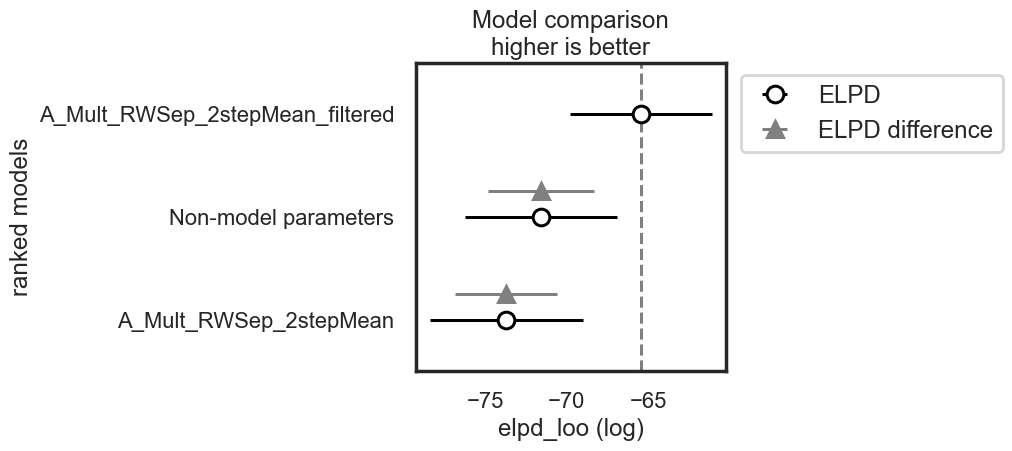

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df_compare = az.compare(bambi_social_model_dict, ic='loo')
    display(df_compare)
    az.plot_compare(df_compare, insample_dev=False, plot_ic_diff=True, figsize=(4, 4));

In [ ]:
# Combination of model and non-model parameters GLM
# Only for best performing computational model above (A_RWSep_1stepDecay)
best_perf_comp_model = best_models['social'][0]
model_name = 'combined'

# Subset of data for model in the addictive cue block
_model_df = master_df.loc[
    (master_df['Group']=='social') &
    (master_df['Model']==best_perf_comp_model) & 
    (master_df['Block']=='other')
].dropna(how='all', axis=1).dropna(how='any', axis=0, subset=dependent_var).reset_index(drop=True)

# Normalize the data
model_param_names = []
for param in (full_param_list+full_nonmodel_param_list+full_demo_list):
    if param in _model_df.columns:
        model_param_names.append(param)
_columns_to_use = [dependent_var] + model_param_names
_numerics = _model_df[_columns_to_use].select_dtypes(include=[np.number])
_nonnumerics = _model_df[_columns_to_use].select_dtypes(exclude=[np.number])
scaler = StandardScaler()
_normed_model_df = pd.concat([
    pd.DataFrame(
        scaler.fit_transform(_numerics), 
        columns=_numerics.columns
    ),
    _nonnumerics
], axis=1)

# Add dummy variables for categorical demographics
normed_model_df = pd.get_dummies(_normed_model_df, columns=['DEMO_sex', 'DEMO_edu'])
normed_model_df.columns = normed_model_df.columns.str.replace(' ', '_')

# Build the model equation
equation = dependent_var + ' ~ '
model_param_names = []
for param in full_param_list:
    if param in normed_model_df.columns:
        equation += param + ' + '
        model_param_names.append(param)
for param in full_nonmodel_param_list:
    if param in normed_model_df.columns:
        equation += param + ' + '
        model_param_names.append(param)
for demo in full_demo_list:
    for col in normed_model_df.columns:
        if demo in col:
            equation += col + ' + '
            model_param_names.append(col)
equation = equation[:-3]
print(f'Number {i}:\t{model_name}\t{equation}')

# Fit the model with statsmodels
sm_results = smf.ols(formula=equation, data=normed_model_df).fit()
display(sm_results.summary())
statsmodels_social_model_dict[model_name] = sm_results

if bambi_flag:
    # Fit the model with bambi
    bmb_model = bmb.Model(equation, normed_model_df, family=family)
    bmb_results = bmb_model.fit()
    ppc = bmb_model.predict(bmb_results, kind='pps')
    bambi_social_model_dict[model_name] = bmb_results

# Filtering of the model (remove predictors with significance < 0.05)
filtered_equation = equation
least_sig = 1
failed = False
while least_sig > sig_threshold:
    try:
        _sm_results = smf.ols(formula=filtered_equation, data=normed_model_df).fit()
    except PatsyError:
        failed = True
        print(f'Model {model_name} failed to fit with filtered equation:\n{filtered_equation}')
        break

    x = pd.read_html(_sm_results.summary().tables[1].as_html())[0]
    y = x.iloc[0].astype(str)
    y[0] = 'Predictor'
    x.columns = y
    x = x.iloc[1:]
    x = pd.concat([
        x['Predictor'],
        x[[elem for elem in x.columns if 'Predictor' not in elem]].astype(str).astype(float)
    ], axis=1)
    x = x[x['Predictor']!='Intercept']
    least_sig = x.sort_values(by='P>|t|', ascending=False)['P>|t|'].values[0]
    predictors = [elem for elem in x.sort_values(by='P>|t|', ascending=False)['Predictor'].values.astype(str) if 'Intercept' not in elem]
    if least_sig > sig_threshold:
        filtered_equation = dependent_var + ' ~ ' + ' + '.join(predictors[1:])
    else:
        filtered_equation = dependent_var + ' ~ ' + ' + '.join(predictors)
print(f'Number {i}:\t{model_name}\t{filtered_equation}')

if not failed:
    # Fit the filtered model with statsmodels
    filtered_sm_results = smf.ols(formula=filtered_equation, data=normed_model_df).fit()
    display(filtered_sm_results.summary())
    statsmodels_social_model_dict[f'{model_name}_filtered'] = filtered_sm_results

    if bambi_flag:
        # Fit the filtered model with bambi
        filtered_bmb_model = bmb.Model(filtered_equation, normed_model_df, family=family)
        filtered_bmb_results = filtered_bmb_model.fit()
        filtered_ppc = filtered_bmb_model.predict(filtered_bmb_results, kind='pps')
        bambi_social_model_dict[f'{model_name}_filtered'] = filtered_bmb_results



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [ ]:
performance_df = pd.DataFrame(columns=['Model', 'R2', 'R2_adj', 'AIC', 'BIC'])
for model in statsmodels_social_model_dict:
    sm_results = statsmodels_social_model_dict[model]
    performance_df = pd.concat([
        performance_df,
        pd.DataFrame({
            'Model': [model],
            'R2': [sm_results.rsquared],
            'R2_adj': [sm_results.rsquared_adj],
            'AIC': [sm_results.aic],
            'BIC': [sm_results.bic]
        })
    ], axis=0)
performance_df = performance_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
performance_df

Model        R2    R2_adj         AIC         BIC
0  A_Mult_RWSep_2stepMean_filtered  0.146433  0.106732  129.259113  134.745037
1                combined_filtered  0.285221  0.153551  131.096401  145.725533
2             Non-model parameters  0.224855  0.031069  138.825901  157.112315
3                         combined  0.429487  0.083104  140.726278  173.641823
4           A_Mult_RWSep_2stepMean  0.300394  0.016179  142.109396  167.710376

In [ ]:
statsmodels_social_model_dict['A_Mult_RWSep_2stepMean_filtered'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              smu_total   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     3.688
Date:                Tue, 28 Feb 2023   Prob (F-statistic):             0.0332
Time:                        11:04:05   Log-Likelihood:                -61.630
No. Observations:                  46   AIC:                             129.3
Df Residuals:                      43   BIC:                             134.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.094e-16      0.141  -1.49e-15      1.000      -0.284       0.284
mod           -0.3819      0.204     -1.872      0.068      -0.793       0.030
cec_weight     0.5535      0.204      2.713      0.010       0.142       0.965
==============================================================================
Omnibus:                        1.229   Durbin-Watson:                   2.217
Prob(Omnibus):                  0.541   Jarque-Bera (JB):                1.140
Skew:                          -0.364   Prob(JB):                        0.566
Kurtosis:                       2.745   Cond. No.                         2.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

rank  elpd_waic     p_waic  elpd_diff  \
A_Mult_RWSep_2stepMean_filtered     0 -65.227967   2.780184   0.000000   
combined_filtered                   1 -67.063274   7.656520   1.835307   
Non-model parameters                2 -71.026740   8.899985   5.798773   
A_Mult_RWSep_2stepMean              3 -72.340561  10.638958   7.112593   
combined                            4 -73.157189  13.654407   7.929222   

                                       weight        se       dse  warning  \
A_Mult_RWSep_2stepMean_filtered  6.818412e-01  4.331141  0.000000     True   
combined_filtered                3.181588e-01  4.786911  3.182616     True   
Non-model parameters             0.000000e+00  4.564086  3.198452     True   
A_Mult_RWSep_2stepMean           0.000000e+00  4.508628  3.010725     True   
combined                         6.661338e-15  4.058016  2.983054     True   

                                scale  
A_Mult_RWSep_2stepMean_filtered   log  
combined_filtered                 log  
Non-model parameters              log  
A_Mult_RWSep_2stepMean            log  
combined                          log

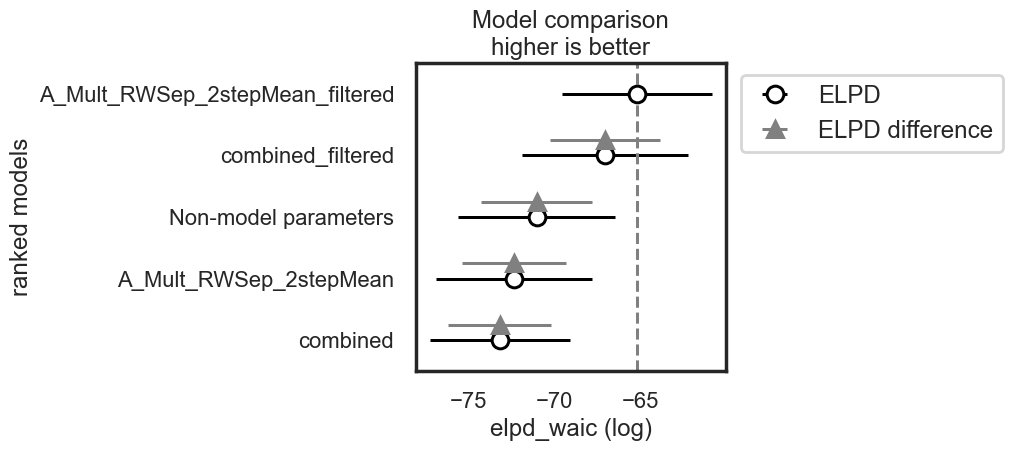

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df_compare = az.compare(bambi_social_model_dict, ic='waic')
    display(df_compare)
    az.plot_compare(df_compare, insample_dev=False, plot_ic_diff=True, figsize=(4, 4));

Calculate R2 for all regressions

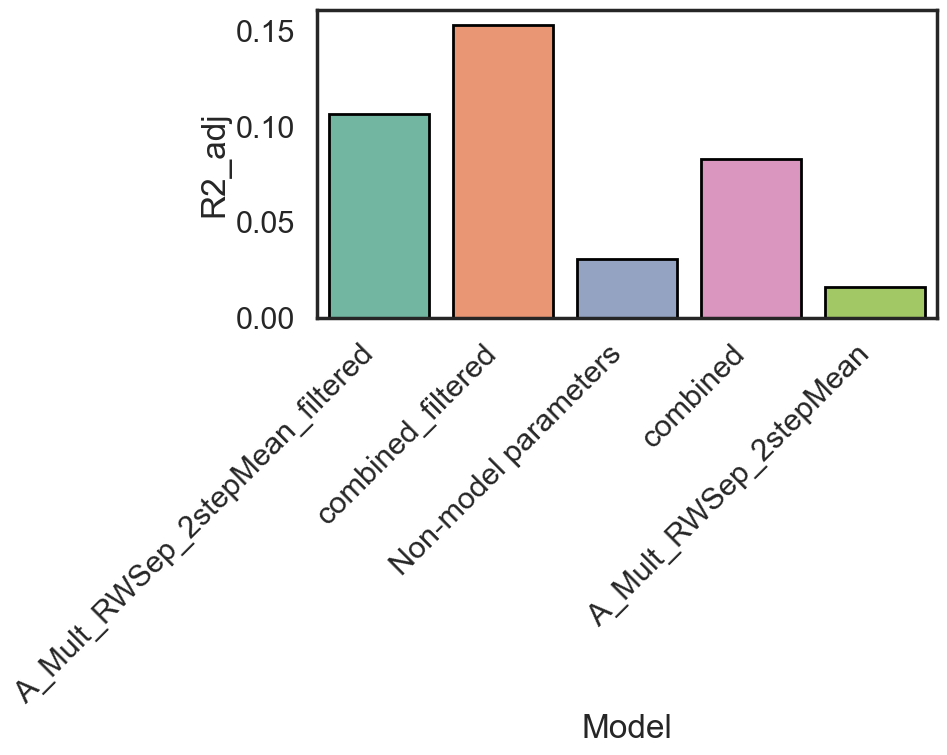

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x='Model', y='R2_adj', data=performance_df, dodge=False, ax=ax, palette='Set2', edgecolor='black', linewidth=2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');

Identify the most predictive variables

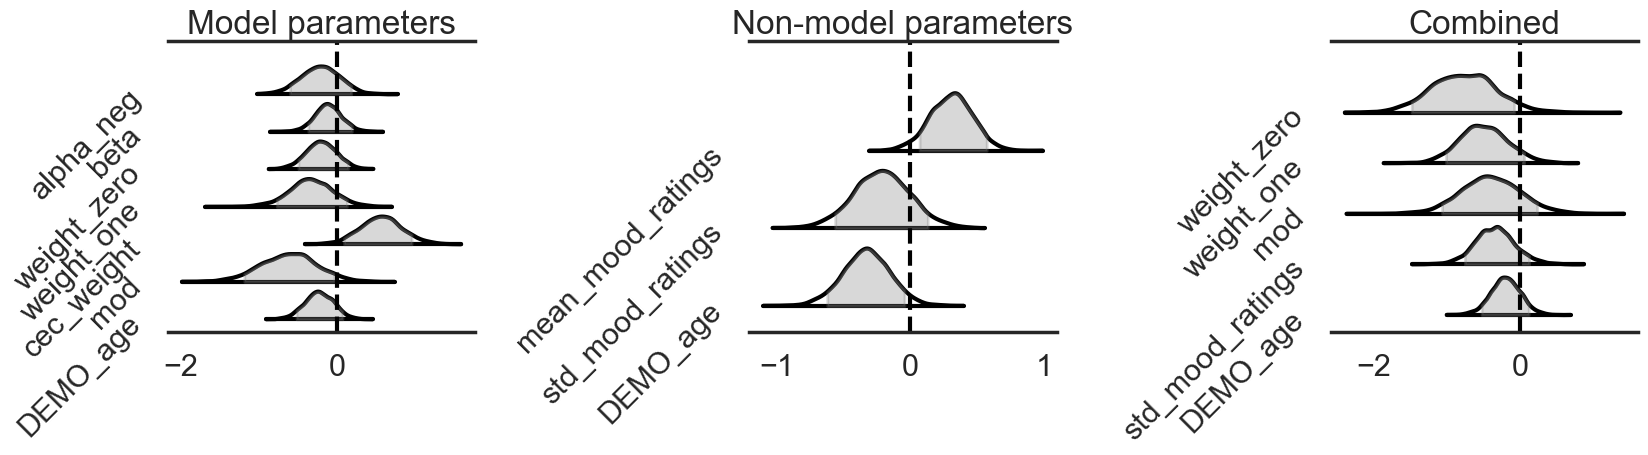

In [ ]:
fig, ax = plt.subplots(figsize=(17, 5), ncols=3, nrows=1)
i_count = -1
for i, model_name in enumerate(bambi_social_model_dict.keys()):
    if 'filtered' in model_name:
        continue
    if i>8:
        break
    else:
        i_count += 1
        if 'Non-model parameters' in model_name:
            ax[i_count].set_title('Non-model parameters')
        elif 'combined' in model_name:
            ax[i_count].set_title('Combined')
        else:
            ax[i_count].set_title('Model parameters')
    vars = []
    summary_model_df = az.summary(bambi_social_model_dict[model_name])
    candidate_vars = np.array([
        elem for elem in az.summary(bambi_social_model_dict[model_name]).index if elem in (full_param_list + full_demo_list + full_nonmodel_param_list)
    ])
    for var in candidate_vars:
        if np.abs(summary_model_df.loc[var]['hdi_3%'] + summary_model_df.loc[var]['hdi_97%']) > np.abs(summary_model_df.loc[var]['hdi_97%']):
            vars.append(var)
    az.plot_forest(
        bambi_social_model_dict[model_name], 
        var_names=vars,
        figsize=(5,4), combined=True, 
        kind='ridgeplot', ridgeplot_alpha=0.3, 
        hdi_prob=0.89,
        # ridgeplot_quantiles=[.25, .5, .75],
        ridgeplot_overlap=1, 
        ridgeplot_truncate=False,
        colors='gray',
        ax=ax[i_count],
    )
    # plt.xlim(-15, 15)
    # ax[i_count].set_title(model_name)
    ax[i_count].axvline(0, color='k', linestyle='--')
    ax[i_count].set_yticklabels(ax[i_count].get_yticklabels(), rotation=45, ha='right')
plt.tight_layout()

Visualize the posterior predictive distributions for the best model

Text(0.05, 0.95, 'Non-model parameters')

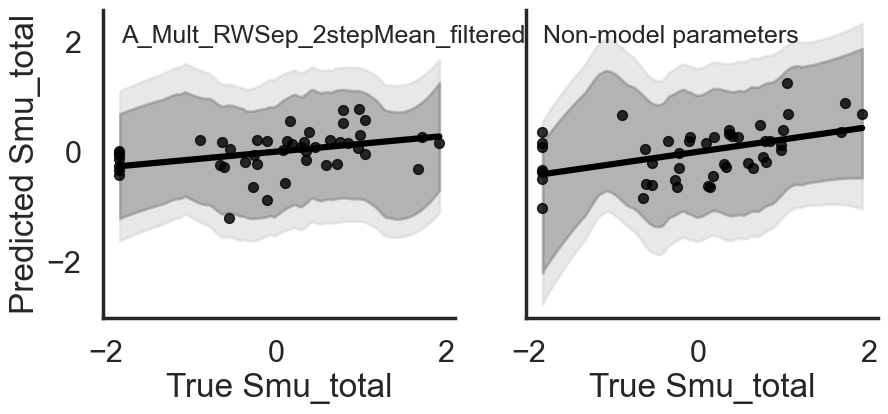

In [ ]:
best_model_name = performance_df.iloc[0]['Model']
best_model_results = bambi_social_model_dict[best_model_name]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)
az.plot_hdi(
    best_model_results.observed_data[dependent_var].values,
    best_model_results.posterior_predictive[dependent_var].values,
    hdi_prob=0.84, smooth=True, color='lightgray', ax=ax[0]
)
az.plot_hdi(
    best_model_results.observed_data[dependent_var].values,
    best_model_results.posterior_predictive[dependent_var].values,
    hdi_prob=0.68, smooth=True, color='gray', ax=ax[0]
)
sns.regplot(
    x=best_model_results.observed_data[dependent_var].values,
    y=np.vstack(best_model_results.posterior_predictive[dependent_var].values).mean(axis=0),
    color='black', ci=0, ax=ax[0], scatter_kws=dict(s=50)
)
az.plot_hdi(
    best_model_results.observed_data[dependent_var].values,
    bambi_social_model_dict['Non-model parameters'].posterior_predictive[dependent_var].values,
    hdi_prob=0.84, smooth=True, color='lightgray', ax=ax[1]
)
az.plot_hdi(
    best_model_results.observed_data[dependent_var].values,
    bambi_social_model_dict['Non-model parameters'].posterior_predictive[dependent_var].values,
    hdi_prob=0.68, smooth=True, color='gray', ax=ax[1]
)
sns.regplot(
    x=best_model_results.observed_data[dependent_var].values,
    y=np.vstack(bambi_social_model_dict['Non-model parameters'].posterior_predictive[dependent_var].values).mean(axis=0),
    color='black', ci=0, ax=ax[1], scatter_kws=dict(s=50)
)
sns.despine()
ax[0].set_xlabel(f'True {dependent_var.capitalize()}')
ax[0].set_ylabel(f'Predicted {dependent_var.capitalize()}')
ax[1].set_xlabel(f'True {dependent_var.capitalize()}')
ax[0].text(0.05, 0.95, f'{best_model_name}', transform=ax[0].transAxes, va='top', ha='left', fontsize=18)
ax[1].text(0.05, 0.95, 'Non-model parameters', transform=ax[1].transAxes, va='top', ha='left', fontsize=18)

Calculate the significance of improvement in predictions by using computational parameters

In [ ]:
predicted = np.hstack((
    np.vstack(best_model_results.posterior_predictive[dependent_var].values).mean(axis=0),
    np.vstack(bambi_social_model_dict['Non-model parameters'].posterior_predictive[dependent_var].values).mean(axis=0)
))
true = np.hstack((
    best_model_results.observed_data[dependent_var].values,
    best_model_results.observed_data[dependent_var].values
))
model_labels = np.hstack((
    # np.repeat(r2_df.loc[0]['Model'], len(sample_model_df)),
    np.repeat(1, len(best_model_results.observed_data[dependent_var].values)),
    # np.repeat('model-free', len(sample_model_df))
    np.repeat(0, len(best_model_results.observed_data[dependent_var].values))
))
social_predict_df = pd.DataFrame({
    'predicted': predicted,
    'true': true,
    'model': model_labels
})

equation = 'predicted ~ true * model'
print(equation)
social_pred_model = bmb.Model(equation, social_predict_df)
social_results = social_pred_model.fit()
# ppc_alt = model_alt.predict(results_alt, kind='pps')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


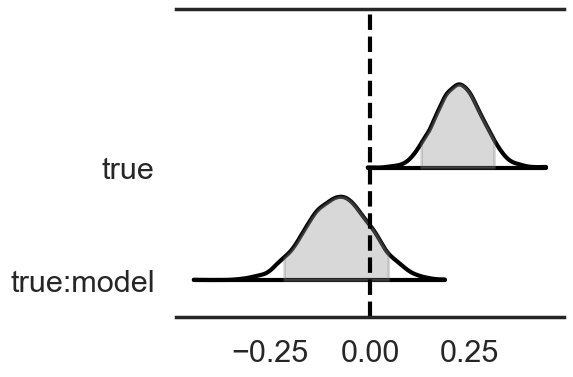

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
az.plot_forest(
    social_results, 
    filter_vars='regex',
    var_names=['^true'],
    figsize=(5,2), combined=True, 
    kind='ridgeplot', ridgeplot_alpha=0.3, 
    hdi_prob=0.89,
    # ridgeplot_quantiles=[.25, .5, .75],
    ridgeplot_overlap=1, 
    ridgeplot_truncate=False,
    colors='gray',
    ax=ax,
)
ax.axvline(0, color='k', linestyle='--')

In [ ]:
smf.ols(equation, social_predict_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              predicted   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     7.045
Date:                Tue, 28 Feb 2023   Prob (F-statistic):           0.000267
Time:                        10:32:38   Log-Likelihood:                -42.270
No. Observations:                  92   AIC:                             92.54
Df Residuals:                      88   BIC:                             102.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0003      0.058      0.006      0.995      -0.114       0.115
true           0.2233      0.058      3.867      0.000       0.109       0.338
model         -0.0004      0.082     -0.005      0.996      -0.163       0.162
true:model    -0.0797      0.082     -0.976      0.332      -0.242       0.083
==============================================================================
Omnibus:                        1.375   Durbin-Watson:                   2.273
Prob(Omnibus):                  0.503   Jarque-Bera (JB):                0.853
Skew:                          -0.190   Prob(JB):                        0.653
Kurtosis:                       3.279   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.05, 0.84, 'Model-free')

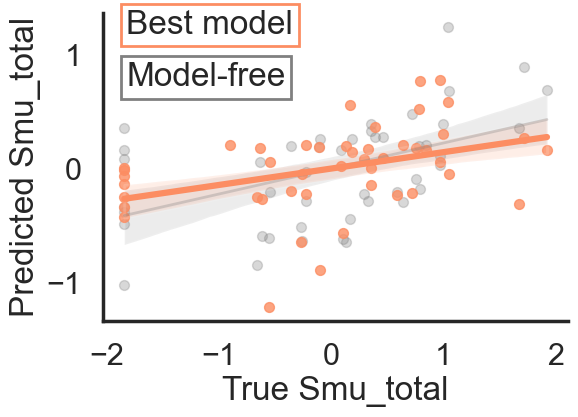

In [ ]:
best_model_results = bambi_social_model_dict[best_model_name]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), sharey=True)
sns.regplot(
    x=best_model_results.observed_data[dependent_var].values,
    y=np.vstack(bambi_social_model_dict['Non-model parameters'].posterior_predictive[dependent_var].values).mean(axis=0),
    color='gray', ci=89, ax=ax, scatter_kws=dict(s=50, alpha=0.3), line_kws=dict(lw=2, alpha=0.3)
)
sns.regplot(
    x=best_model_results.observed_data[dependent_var].values,
    y=np.vstack(best_model_results.posterior_predictive[dependent_var].values).mean(axis=0),
    color=sns.palettes.color_palette('Set2')[1], ci=89, ax=ax, scatter_kws=dict(s=50)
)
sns.despine()
ax.set_xlabel(f'True {dependent_var.capitalize()}')
ax.set_ylabel(f'Predicted {dependent_var.capitalize()}')
ax.text(0.05, 1.01, f'Best model', transform=ax.transAxes, va='top', ha='left', bbox=dict(edgecolor=sns.palettes.color_palette('Set2')[1], facecolor='white'))
ax.text(0.05, 0.84, 'Model-free', transform=ax.transAxes, va='top', ha='left', bbox=dict(edgecolor='gray', facecolor='white'))